In [3]:
#import pandas as pd
import os
from IPython.display import display, HTML


# From kernel kaggle
import numpy as np
import pandas as pd
import time
import gc
from contextlib import contextmanager
#from lightgbm import LGBMClassifier
#from xgboost import XGBClassifier
#from sklearn.metrics import roc_auc_score
#from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re


In [4]:
# Setting pandas options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

# Setting warnings options
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

# Data description

* __application_{train|test}.csv__
    * This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
    * Static data for all applications. One row represents one loan in our data sample.
* __bureau.csv__
    * All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
    * For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.
* __bureau_balance.csv__
    * Monthly balances of previous credits in Credit Bureau.
    * This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.
* __POS_CASH_balance.csv__
    * Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
    * This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.
* __credit_card_balance.csv__
    * Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
    * This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.
* __previous_application.csv__
    * All previous applications for Home Credit loans of clients who have loans in our sample.
    * There is one row for each previous application related to loans in our data sample.
* __installments_payments.csv__
    * Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
    * There is a) one row for every payment that was made plus b) one row each for missed payment.
    * One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

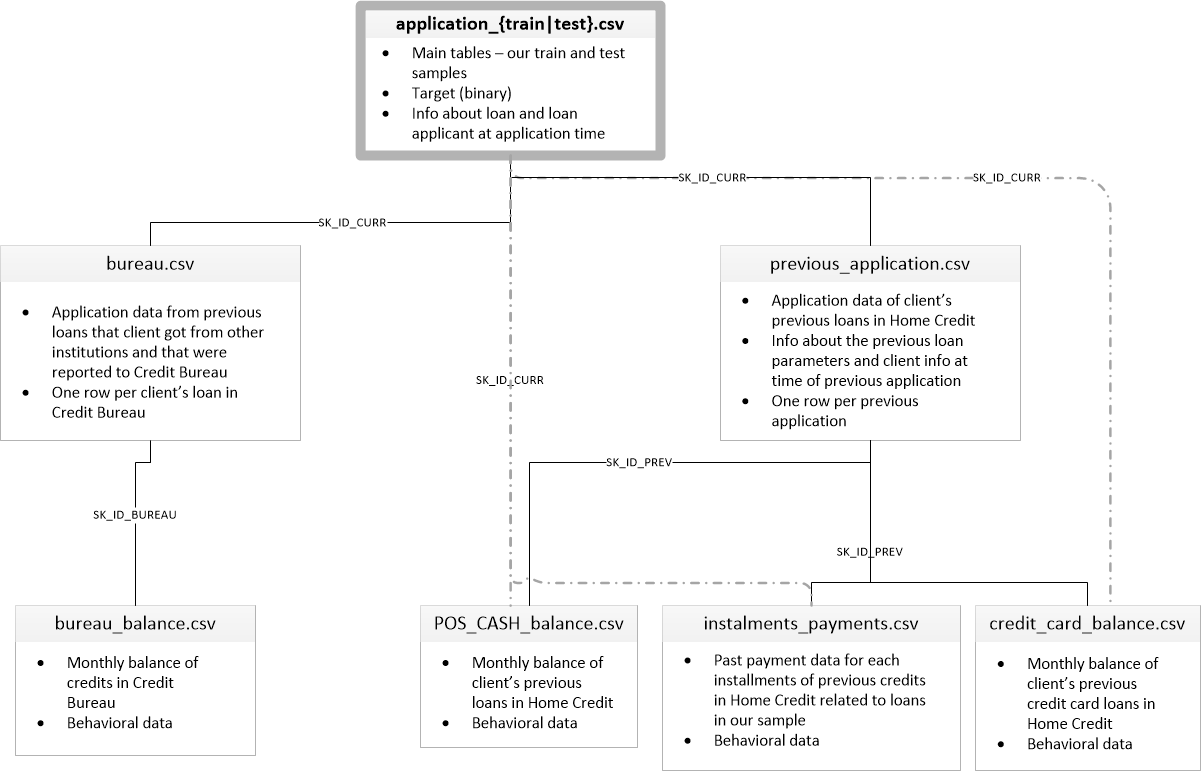

\+ __HomeCredit_columns_description.csv__ ==> This file contains descriptions for the columns in the various data files.

# Data loading and preview

In [7]:
# path to folder with data
path = './Projet+Mise+en+prod+-+home-credit-default-risk/'

In [112]:
# data files within this folder
files = []
for filename in os.listdir(path):
    files.append(filename.split('.')[0])
files

['application_test',
 'application_train',
 'bureau',
 'bureau_balance',
 'credit_card_balance',
 'HomeCredit_columns_description',
 'installments_payments',
 'POS_CASH_balance',
 'previous_application',
 'sample_submission']

In [113]:
# removal of the unnecessary files from the list
files.remove('HomeCredit_columns_description')
files.remove('sample_submission')
files

['application_test',
 'application_train',
 'bureau',
 'bureau_balance',
 'credit_card_balance',
 'installments_payments',
 'POS_CASH_balance',
 'previous_application']

In [114]:
# Creation of dfs from these files and quick look at their content
for filename in files:
    print(filename)
    globals()[filename] = pd.read_csv(path+'{}.csv'.format(filename))
    print('shape =', globals()[filename].shape)
    display(HTML(globals()[filename].head(2).to_html()))
    print('-'*100)
    print('-'*100)

application_test
shape = (48744, 121)


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
application_train
shape = (307511, 122)


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
bureau
shape = (1716428, 17)


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
bureau_balance
shape = (27299925, 3)


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
credit_card_balance
shape = (3840312, 23)


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
installments_payments
shape = (13605401, 8)


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
POS_CASH_balance
shape = (10001358, 8)


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
previous_application
shape = (1670214, 37)


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------


# Analysis of data + analysis and adaptation of kaggle kernels for data preprocessing
kaggle kernels = 
* https://www.kaggle.com/anlgvrk/home-credit-xgboost-dsmlbc4-gr2
* https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features/script
* https://www.kaggle.com/araul3927/home-credit-risk-fe-to-predictivemodel
* https://www.kaggle.com/kbakshi98/exploring-loan-repayment-prediction
* https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction
* https://www.kaggle.com/danilz/merge-all-data-base-glm-vs-xgb-explained-0-763

* https://notebook.community/Diyago/Machine-Learning-scripts/classification/Kaggle%20Home%20Credit%20Default%20Risk/lightGBM%20


## General functions 
### from kaggle kernels

In [10]:
# Defining one-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


# Defining Sin-cos transformation for cyclic features
def encode(df, col, max_val):
    df[col + '_SIN'] = np.sin(2 * np.pi * df[col]/max_val)
    df[col + '_COS'] = np.cos(2 * np.pi * df[col]/max_val)
    return df


# Defining dynamic rare encoding for column categories
def dyn_rare_encoder(df, columns, rare_percent):
    for col in columns:
        tmp = df[col].value_counts() / len(df) * 100
        rare_labels = tmp[tmp < rare_percent].index
        df[col] = np.where(df[col].isin(rare_labels), 'Other', df[col])
    return df


############## Remark ##############
#nan_as_category: boolean, optional (default=True)
    #If True includes NaNs as one of the categories and also applies target encoding for this subgroup.

### From this notebook -- for EDA

In [11]:
def analyse_col_distr(df):
    '''Function to provide information
    for each feature of a df in terms of
    NaN, unique values, distribution'''
    num_feat_with_nan = []
    cat_feat_with_nan = []
    discrete_feat_with_nan = []
    print('df shape = {}'.format(df.shape))
    print('nb of duplicates = {}'.format(df.duplicated().sum()))
    for col in df.columns:
        print('-'*40)
        print('-'*40)
        print(col, ' -- dtype = ', df[col].dtype)
        print('-'*20)
        print('Nb of Nan = {} out of {}'.format(df[col].isna().sum(), df.shape[0]))
        print('-'*20)
        if df[col].dtype == object or df[col].dtype == bool:
            if df[col].isna().sum() > 0:
                cat_feat_with_nan.append(col)
            print('Nb unique values = {}'.format(len(df[col].unique().tolist())))
            print('--- Valeurs uniques :')
            if len(df[col].unique().tolist()) < 15:
                print(df[col].value_counts(dropna=False))
            else:
                plt.figure(figsize=(6,4))
                plt.title(col, fontsize=16, color='darkred', weight=800)
                g = sns.countplot(x=col, data=df)
                g.tick_params(axis='x', rotation=90)
        if df[col].dtype == 'int64':
            if len(df[col].unique().tolist()) < 15:
                if df[col].isna().sum() > 0:
                    cat_feat_with_nan.append(col)
                print('categorical-like')
                print('Nb unique values = {}'.format(len(df[col].unique().tolist())))
                print(df[col].value_counts(dropna=False))
            elif len(df[col].unique().tolist()) > 100:
                if df[col].isna().sum() > 0:
                    num_feat_with_nan.append(col)
                print('continuous-like')
                plt.figure(figsize=(6,4))
                plt.title(col, fontsize=16, color='darkred', weight=800)
                g = sns.histplot(x=col, data=df, kde=True)
                g.tick_params(axis='x', rotation=90)
            else:
                if df[col].isna().sum() > 0:
                    discrete_feat_with_nan.append(col)
                print('discrete-like')
                plt.figure(figsize=(6,4))
                plt.title(col, fontsize=16, color='darkred', weight=800)
                g = sns.countplot(x=col, data=df)
                g.tick_params(axis='x', rotation=90)
        if df[col].dtype == float:
            if df[col].isna().sum() > 0:
                num_feat_with_nan.append(col)
            plt.figure(figsize=(6,4))
            plt.title(col, fontsize=16, color='darkred', weight=800)
            g = sns.histplot(x=col, data=df, kde=True)
            g.tick_params(axis='x', rotation=90)
    print('-' * 100)
    print('-' * 100)
    print('numeric features with NaN are {}'.format(num_feat_with_nan))
    print('-'*40)
    print('categorical features with NaN are {}'.format(cat_feat_with_nan))
    print('-'*40)
    print('discrete features with NaN are {}'.format(discrete_feat_with_nan))

def simplified_analyse_col_distr(df):
    '''Function to provide information
    for each feature of a df in terms of NaN,
    and of unique values for categorical features'''
    num_feat_with_nan = []
    num_or_cat_feat_with_nan = []
    cat_feat_with_nan = []
    print('df shape = {}'.format(df.shape))
    print('nb of duplicates = {}'.format(df.duplicated().sum()))
    for col in df.columns:
        print('-'*40)
        print('-'*40)
        print(col, ' -- dtype = ', df[col].dtype)
        print('-'*20)
        print('Nb of Nan = {} out of {}'.format(df[col].isna().sum(), df.shape[0]))
        print('-'*20)
        if df[col].dtype == object or df[col].dtype == bool:
            if df[col].isna().sum() > 0:
                cat_feat_with_nan.append(col)
            print('Nb unique values = {}'.format(len(df[col].unique().tolist())))
            print('--- Valeurs uniques :')
            if len(df[col].unique().tolist()) < 30:
                print(df[col].value_counts(dropna=False))
            else:
                print('More than 30 unique values')
        if df[col].dtype == 'int64':
            print('min =', np.min(df[col]))
            print('max =', np.max(df[col]))
            print('mean =', np.mean(df[col]))
            print('std =', np.std(df[col]))
            print('nan_std =', np.nanstd(df[col]))
            print('Relative_nan_std =', (np.nanstd(df[col])*100)/np.mean(df[col]))
            if df[col].isna().sum() > 0:
                num_or_cat_feat_with_nan = [].append(col)
        if df[col].dtype == float:
            print('min =', np.min(df[col]))
            print('max =', np.max(df[col]))
            print('mean =', np.mean(df[col]))
            print('std =', np.std(df[col]))
            print('nan_std =', np.nanstd(df[col]))
            print('Relative_nan_std =', (np.nanstd(df[col])*100)/np.mean(df[col]))
            if df[col].isna().sum() > 0:
                num_feat_with_nan.append(col)
    print('-' * 100)
    print('-' * 100)
    print('numeric features with NaN are {}'.format(num_feat_with_nan))
    print('-'*40)
    print('categorical features with NaN are {}'.format(cat_feat_with_nan))
    print('-'*40)
    print('int64 features with NaN are {}'.format(num_or_cat_feat_with_nan))

In [12]:
def check_encoded_cat_cols(df, cat_cols):
    print('nb of categorical columns created though OHE = ', len(cat_cols))
    print('-' * 20)
    print(cat_cols)
    print('-' * 100)
    cat_cols_uniq_val_list = []
    cat_cols_nan_list = []
    for col in cat_cols:
        print(col)
        print('Nb of Nan = {} out of {}'.format(df[col].isna().sum(), df.shape[0]))
        print('Nb of unique values = {}'.format(len(df[col].unique().tolist())))
        cat_cols_nan_list.append(df[col].isna().sum())
        cat_cols_uniq_val_list.append(len(df[col].unique().tolist()))
        print('-'*20)
    print('-' * 100)
    print('nb of cat_cols with NaN =', sum(1 for nb_nan in cat_cols_nan_list if nb_nan > 0))
    if np.max(cat_cols_uniq_val_list) > 2:
        print('OHE issue with {} new cat_cols generated'\
              .format(sum(1 for nb_uniq_val in cat_cols_uniq_val_list if nb_uniq_val > 2)))
    else: print('No OHE issue!!')

In [13]:
def check_nan(df):
    for col in df.columns.tolist():
        print('nan in', col, ':', df[col].isna().sum(),
              '(ratio of', round(df[col].isna().sum()/df.shape[0], 2), ')')

## 'application_train' Data
--> Test of bits of code from kaggle kernels, step by step + other verifications/analyses

### Loading data and detailed preview

In [117]:
df = pd.read_csv(path+'application_train.csv')
print("Train df shape: {}".format(df.shape))

Train df shape: (307511, 122)


In [118]:
df.head(2)

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0      100002       1         Cash loans           M            N               Y             0          202500.0    406597.5      24700.5         351000.0   Unaccompanied          Working  Secondary / secondary special  Single / not married  House / apartment                    0.018801       -9461           -637            -3648.0            -2120          NaN           1               1                0                 1           1           0        Laborers              1.0   
1      100003       0         Cash loans           F            N               N             0          270000.0   1293502.5      35698.5        1129500.0          Family    State servant               Higher education               Married  House / apartment                    0.003541      -16765          -1188            -1186.0             -291          NaN           1               1                0                 1           1           0      Core staff              2.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY       ORGANIZATION_TYPE  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  \
0                     2                            2                  WEDNESDAY                       10                           0                           0                            0                       0                       0                        0  Business Entity Type 3      0.083037      0.262949      0.139376          0.0247            0.0369                       0.9722           0.6192          0.0143           0.00         0.0690         0.0833         0.1250   
1                     1                            1                     MONDAY                       11                           0                           0                            0                       0                       0                        0                  School      0.311267      0.622246           NaN          0.0959            0.0529                       0.9851           0.7960          0.0605           0.08         0.0345         0.2917         0.3333   

   LANDAREA_AVG  LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  APARTMENTS_MODE  BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  COMMONAREA_MODE  ELEVATORS_MODE  ENTRANCES_MODE  FLOORSMAX_MODE  FLOORSMIN_MODE  LANDAREA_MODE  LIVINGAPARTMENTS_MODE  LIVINGAREA_MODE  NONLIVINGAPARTMENTS_MODE  NONLIVINGAREA_MODE  APARTMENTS_MEDI  BASEMENTAREA_MEDI  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BUILD_MEDI  COMMONAREA_MEDI  ELEVATORS_MEDI  ENTRANCES_MEDI  \
0        0.0369                0.0202          0.0190                   0.0000             0.0000           0.0252             0.0383                        0.9722            0.6341           0.0144          0.0000          0.0690          0.0833          0.1250         0.0377                  0.022           0.0198                       0.0                 0.0           0.0250             0.0369                        0.9722            0.6243           0.0144            0.00          0.0690   
1        0.0130                0.0773          0.0549                   0

In [119]:
df

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  \
0           100002       1         Cash loans           M            N               Y             0          202500.0    406597.5      24700.5         351000.0   Unaccompanied               Working  Secondary / secondary special  Single / not married  House / apartment                    0.018801       -9461           -637            -3648.0            -2120          NaN           1               1                0                 1           1           0        Laborers              1.0   
1           100003       0         Cash loans           F            N               N             0          270000.0   1293502.5      35698.5        1129500.0          Family         State servant               Higher education               Married  House / apartment                    0.003541      -16765          -1188            -1186.0             -291          NaN           1               1                0                 1           1           0      Core staff              2.0   
2           100004       0    Revolving loans           M            Y               Y             0           67500.0    135000.0       6750.0         135000.0   Unaccompanied               Working  Secondary / secondary special  Single / not married  House / apartment                    0.010032      -19046           -225            -4260.0            -2531         26.0           1               1                1                 1           1           0        Laborers              1.0   
3           100006       0         Cash loans           F            N               Y             0          135000.0    312682.5      29686.5         297000.0   Unaccompanied               Working  Secondary / secondary special        Civil marriage  House / apartment                    0.008019      -19005          -3039            -9833.0            -2437          NaN           1               1                0                 1           0           0        Laborers              2.0   
4           100007       0         Cash loans           M            N               Y             0          121500.0    513000.0      21865.5         513000.0   Unaccompanied               Working  Secondary / secondary special  Single / not married  House / apartment                    0.028663      -19932          -3038            -4311.0            -3458          NaN           1               1                0                 1           0           0      Core staff              1.0   
...            ...     ...                ...         ...          ...             ...           ...               ...         ...          ...              ...             ...                   ...                            ...                   ...                ...                         ...         ...            ...                ...              ...          ...         ...             ...              ...               ...         ...         ...             ...              ...   
307506      456251       0         Cash loans           M            N               N             0          157500.0    254700.0      27558.0         225000.0   Unaccompanied               Working  Secondary / secondary special             Separated       With parents                    0.032561       -9327           -236            -8456.0            -1982          NaN           1               1                0                 1           0           0     Sales staff              1.0   
307507      456252      

In [120]:
df.describe(include='all')

SK_ID_CURR         TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY   CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE     DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH    OWN_CAR_AGE     FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE     FLAG_PHONE     FLAG_EMAIL  \
count   307511.000000  307511.000000             307511      307511       307511          307511  307511.000000      3.075110e+05  3.075110e+05  307499.000000     3.072330e+05          306219           307511                         307511             307511             307511               307511.000000  307511.000000  307511.000000      307511.000000    307511.000000  104582.000000  307511.000000   307511.000000    307511.000000     307511.000000  307511.000000  307511.000000   
unique            NaN            NaN                  2           3            2               2            NaN               NaN           NaN            NaN              NaN               7                8                              5                  6                  6                         NaN            NaN            NaN                NaN              NaN            NaN            NaN             NaN              NaN               NaN            NaN            NaN   
top               NaN            NaN         Cash loans           F            N               Y            NaN               NaN           NaN            NaN              NaN   Unaccompanied          Working  Secondary / secondary special            Married  House / apartment                         NaN            NaN            NaN                NaN              NaN            NaN            NaN             NaN              NaN               NaN            NaN            NaN   
freq              NaN            NaN             278232      202448       202924          213312            NaN               NaN           NaN            NaN              NaN          248526           158774                         218391             196432             272868                         NaN            NaN            NaN                NaN              NaN            NaN            NaN             NaN              NaN               NaN            NaN            NaN   
mean    278180.518577       0.080729                NaN         NaN          NaN             NaN       0.417052      1.687979e+05  5.990260e+05   27108.573909     5.383962e+05             NaN              NaN                            NaN                NaN                NaN                    0.020868  -16036.995067   63815.045904       -4986.120328     -2994.202373      12.061091       0.999997        0.819889         0.199368          0.998133       0.281066       0.056720   
std     102790.175348       0.272419                NaN         NaN          NaN             NaN       0.722121      2.371231e+05  4.024908e+05   14493.737315     3.694465e+05             NaN              NaN                            NaN                NaN                NaN                    0.013831    4363.988632  141275.766519        3522.886321      1509.450419      11.944812       0.001803        0.384280         0.399526          0.043164       0.449521       0.231307   
min     100002.000000       0.000000                NaN         NaN          NaN             NaN       0.000000      2.565000e+04  4.500000e+04    1615.500000     4.050000e+04             NaN              NaN                            NaN                NaN                NaN                    0.000290  -25229.000000  -17912.000000      -24672.000000     -7197.000000       0.000000       0.000000        0.000000         0.000000          0.000000       0.000000       0.000000   
25%     189145.500000       0.000000                NaN         NaN          NaN             NaN       0.000000      1.1250

df shape = (307511, 122)
nb of duplicates = 0
----------------------------------------
----------------------------------------
SK_ID_CURR  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 307511
--------------------
continuous-like
----------------------------------------
----------------------------------------
TARGET  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 307511
--------------------
categorical-like
Nb unique values = 2
0    282686
1     24825
Name: TARGET, dtype: int64
----------------------------------------
----------------------------------------
NAME_CONTRACT_TYPE  -- dtype =  object
--------------------
Nb of Nan = 0 out of 307511
--------------------
Nb unique values = 2
--- Valeurs uniques :
Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64
----------------------------------------
----------------------------------------
CODE_GENDER  -- dtype =  object
--------------------
Nb of Nan = 0 out of 307511
-

----------------------------------------
----------------------------------------
REGION_RATING_CLIENT  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 307511
--------------------
categorical-like
Nb unique values = 3
2    226984
3     48330
1     32197
Name: REGION_RATING_CLIENT, dtype: int64
----------------------------------------
----------------------------------------
REGION_RATING_CLIENT_W_CITY  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 307511
--------------------
categorical-like
Nb unique values = 3
2    229484
3     43860
1     34167
Name: REGION_RATING_CLIENT_W_CITY, dtype: int64
----------------------------------------
----------------------------------------
WEEKDAY_APPR_PROCESS_START  -- dtype =  object
--------------------
Nb of Nan = 0 out of 307511
--------------------
Nb unique values = 7
--- Valeurs uniques :
TUESDAY      53901
WEDNESDAY    51934
MONDAY       50714
THURSDAY     50591
FRIDAY       50338
SATURDAY     33852
SUNDAY       161

<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
YEARS_BEGINEXPLUATATION_AVG  -- dtype =  float64
--------------------
Nb of Nan = 150007 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
YEARS_BUILD_AVG  -- dtype =  float64
--------------------
Nb of Nan = 204488 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
COMMONAREA_AVG  -- dtype =  float64
--------------------
Nb of Nan = 214865 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
ELEVATORS_AVG  -- dtype =  float64
--------------------
Nb of Nan = 163891 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
ENTRANCES_AVG  -- dtype =  float64
--------------------
Nb of Nan = 154828 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
FLOORSMAX_AVG  -- dtype =  float64
--------------------
Nb of Nan = 153020 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
FLOORSMIN_AVG  -- dtype =  float64
--------------------
Nb of Nan = 208642 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
LANDAREA_AVG  -- dtype =  float64
--------------------
Nb of Nan = 182590 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
LIVINGAPARTMENTS_AVG  -- dtype =  float64
--------------------
Nb of Nan = 210199 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
LIVINGAREA_AVG  -- dtype =  float64
--------------------
Nb of Nan = 154350 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
NONLIVINGAPARTMENTS_AVG  -- dtype =  float64
--------------------
Nb of Nan = 213514 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
NONLIVINGAREA_AVG  -- dtype =  float64
--------------------
Nb of Nan = 169682 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
APARTMENTS_MODE  -- dtype =  float64
--------------------
Nb of Nan = 156061 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
BASEMENTAREA_MODE  -- dtype =  float64
--------------------
Nb of Nan = 179943 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
YEARS_BEGINEXPLUATATION_MODE  -- dtype =  float64
--------------------
Nb of Nan = 150007 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
YEARS_BUILD_MODE  -- dtype =  float64
--------------------
Nb of Nan = 204488 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
COMMONAREA_MODE  -- dtype =  float64
--------------------
Nb of Nan = 214865 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
ELEVATORS_MODE  -- dtype =  float64
--------------------
Nb of Nan = 163891 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
ENTRANCES_MODE  -- dtype =  float64
--------------------
Nb of Nan = 154828 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
FLOORSMAX_MODE  -- dtype =  float64
--------------------
Nb of Nan = 153020 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
FLOORSMIN_MODE  -- dtype =  float64
--------------------
Nb of Nan = 208642 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
LANDAREA_MODE  -- dtype =  float64
--------------------
Nb of Nan = 182590 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
LIVINGAPARTMENTS_MODE  -- dtype =  float64
--------------------
Nb of Nan = 210199 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
LIVINGAREA_MODE  -- dtype =  float64
--------------------
Nb of Nan = 154350 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
NONLIVINGAPARTMENTS_MODE  -- dtype =  float64
--------------------
Nb of Nan = 213514 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
NONLIVINGAREA_MODE  -- dtype =  float64
--------------------
Nb of Nan = 169682 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
APARTMENTS_MEDI  -- dtype =  float64
--------------------
Nb of Nan = 156061 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
BASEMENTAREA_MEDI  -- dtype =  float64
--------------------
Nb of Nan = 179943 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
YEARS_BEGINEXPLUATATION_MEDI  -- dtype =  float64
--------------------
Nb of Nan = 150007 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
YEARS_BUILD_MEDI  -- dtype =  float64
--------------------
Nb of Nan = 204488 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
COMMONAREA_MEDI  -- dtype =  float64
--------------------
Nb of Nan = 214865 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
ELEVATORS_MEDI  -- dtype =  float64
--------------------
Nb of Nan = 163891 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
ENTRANCES_MEDI  -- dtype =  float64
--------------------
Nb of Nan = 154828 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
FLOORSMAX_MEDI  -- dtype =  float64
--------------------
Nb of Nan = 153020 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
FLOORSMIN_MEDI  -- dtype =  float64
--------------------
Nb of Nan = 208642 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
LANDAREA_MEDI  -- dtype =  float64
--------------------
Nb of Nan = 182590 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
LIVINGAPARTMENTS_MEDI  -- dtype =  float64
--------------------
Nb of Nan = 210199 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
LIVINGAREA_MEDI  -- dtype =  float64
--------------------
Nb of Nan = 154350 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
NONLIVINGAPARTMENTS_MEDI  -- dtype =  float64
--------------------
Nb of Nan = 213514 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
NONLIVINGAREA_MEDI  -- dtype =  float64
--------------------
Nb of Nan = 169682 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
FONDKAPREMONT_MODE  -- dtype =  object
--------------------
Nb of Nan = 210295 out of 307511
--------------------
Nb unique values = 5
--- Valeurs uniques :
NaN                      210295
reg oper account          73830
reg oper spec account     12080
not specified              5687
org spec account           5619
Name: FONDKAPREMONT_MODE, dtype: int64
----------------------------------------
----------------------------------------
HOUSETYPE_MODE  -- dtype =  object
--------------------
Nb of Nan = 154297 out of 307511
--------------------
Nb unique values = 4
--- Valeurs uniques :
NaN                 154297
block of flats      150503
specific housing      1499
terraced house        1212
Name: HOUSETYPE_MODE, dtype: int64
----------------------------------------
----------------------------------------
TOTALAREA_MODE  -- dtype =  float64
--------------------
Nb of Nan = 148431 out of 307511
------------

<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
WALLSMATERIAL_MODE  -- dtype =  object
--------------------
Nb of Nan = 156341 out of 307511
--------------------
Nb unique values = 8
--- Valeurs uniques :
NaN             156341
Panel            66040
Stone, brick     64815
Block             9253
Wooden            5362
Mixed             2296
Monolithic        1779
Others            1625
Name: WALLSMATERIAL_MODE, dtype: int64
----------------------------------------
----------------------------------------
EMERGENCYSTATE_MODE  -- dtype =  object
--------------------
Nb of Nan = 145755 out of 307511
--------------------
Nb unique values = 3
--- Valeurs uniques :
No     159428
NaN    145755
Yes      2328
Name: EMERGENCYSTATE_MODE, dtype: int64
----------------------------------------
----------------------------------------
OBS_30_CNT_SOCIAL_CIRCLE  -- dtype =  float64
--------------------
Nb of Nan = 1021 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
DEF_30_CNT_SOCIAL_CIRCLE  -- dtype =  float64
--------------------
Nb of Nan = 1021 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
OBS_60_CNT_SOCIAL_CIRCLE  -- dtype =  float64
--------------------
Nb of Nan = 1021 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
DEF_60_CNT_SOCIAL_CIRCLE  -- dtype =  float64
--------------------
Nb of Nan = 1021 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
DAYS_LAST_PHONE_CHANGE  -- dtype =  float64
--------------------
Nb of Nan = 1 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
FLAG_DOCUMENT_2  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 307511
--------------------
categorical-like
Nb unique values = 2
0    307498
1        13
Name: FLAG_DOCUMENT_2, dtype: int64
----------------------------------------
----------------------------------------
FLAG_DOCUMENT_3  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 307511
--------------------
categorical-like
Nb unique values = 2
1    218340
0     89171
Name: FLAG_DOCUMENT_3, dtype: int64
----------------------------------------
----------------------------------------
FLAG_DOCUMENT_4  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 307511
--------------------
categorical-like
Nb unique values = 2
0    307486
1        25
Name: FLAG_DOCUMENT_4, dtype: int64
----------------------------------------
----------------------------------------
FLAG_DOCUMENT_5  -- dtype =  int64
--------------------
Nb of N

<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
AMT_REQ_CREDIT_BUREAU_DAY  -- dtype =  float64
--------------------
Nb of Nan = 41519 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
AMT_REQ_CREDIT_BUREAU_WEEK  -- dtype =  float64
--------------------
Nb of Nan = 41519 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
AMT_REQ_CREDIT_BUREAU_MON  -- dtype =  float64
--------------------
Nb of Nan = 41519 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
AMT_REQ_CREDIT_BUREAU_QRT  -- dtype =  float64
--------------------
Nb of Nan = 41519 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------
----------------------------------------
AMT_REQ_CREDIT_BUREAU_YEAR  -- dtype =  float64
--------------------
Nb of Nan = 41519 out of 307511
--------------------


<ipython-input-116-9addf44c47da>:55: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(6,4))


----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
numeric features with NaN are ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEAR

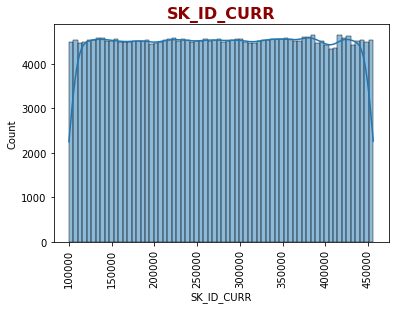

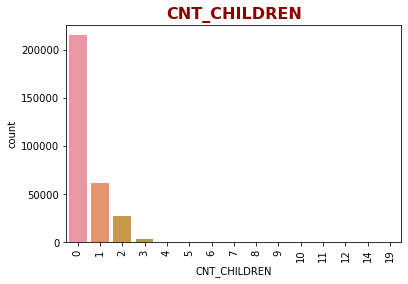

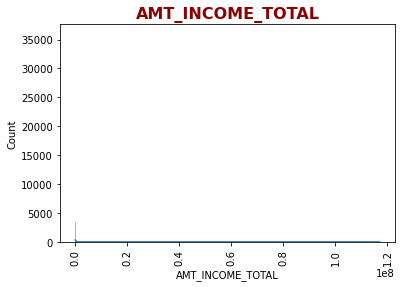

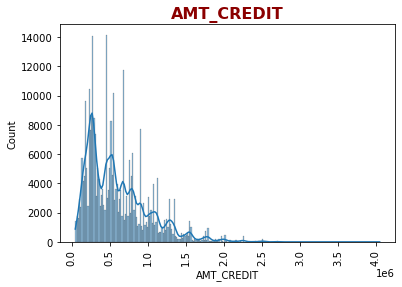

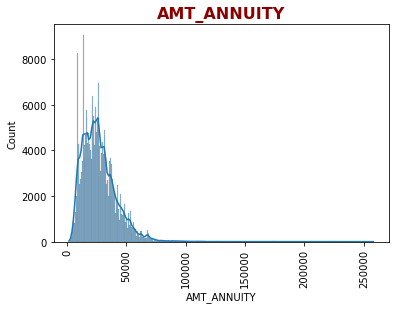

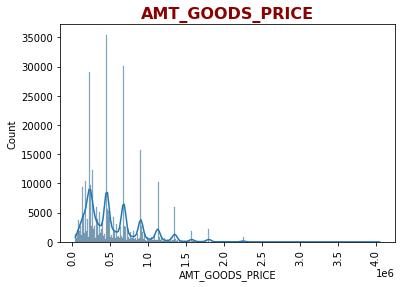

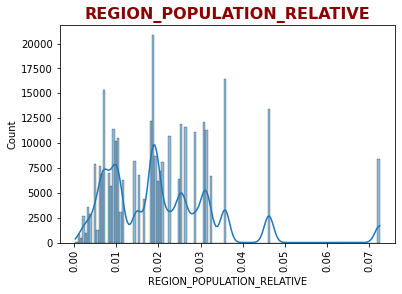

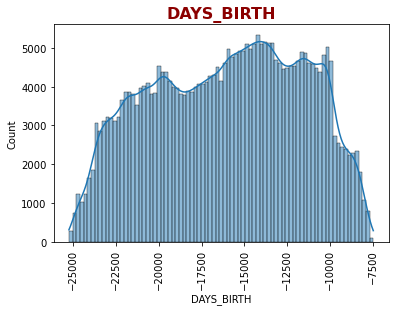

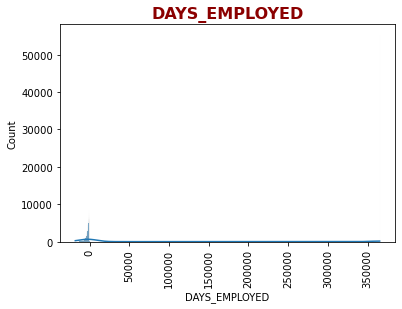

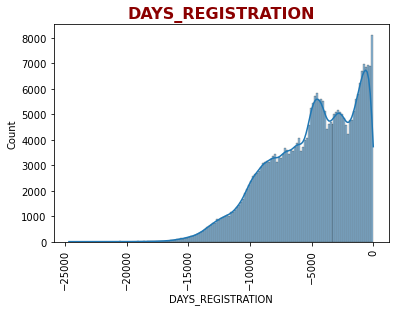

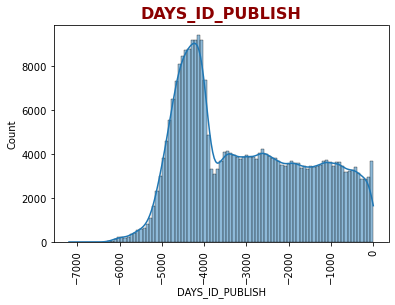

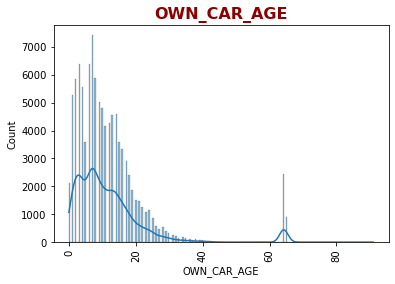

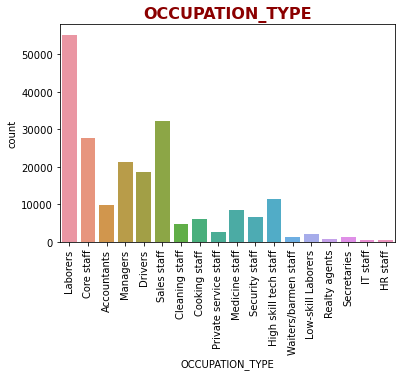

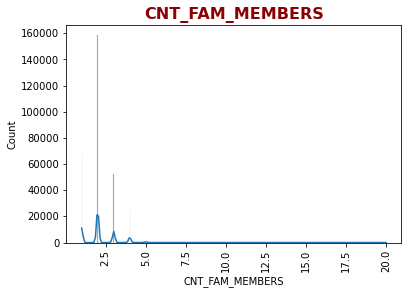

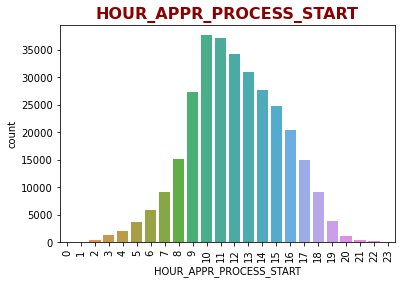

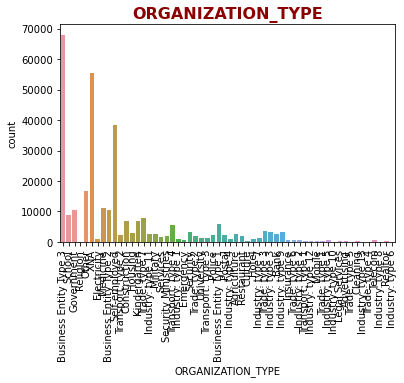

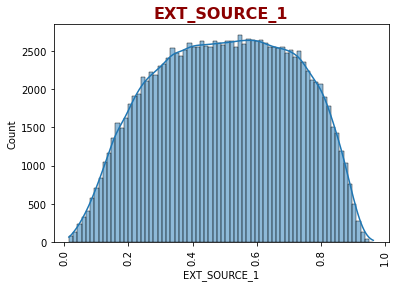

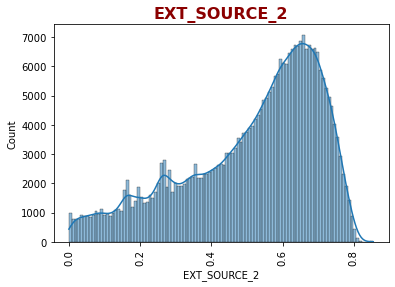

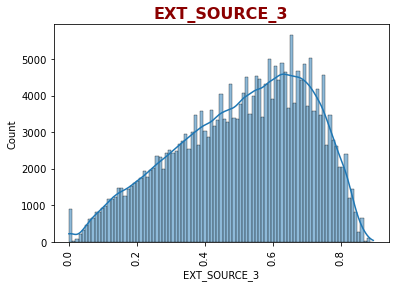

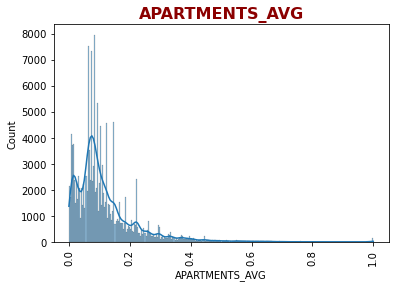

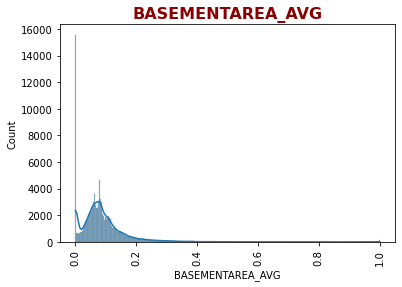

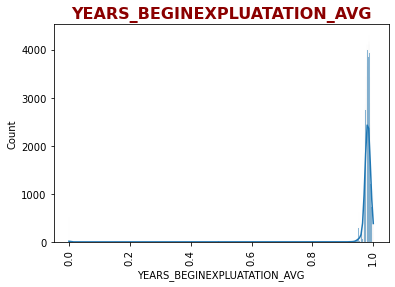

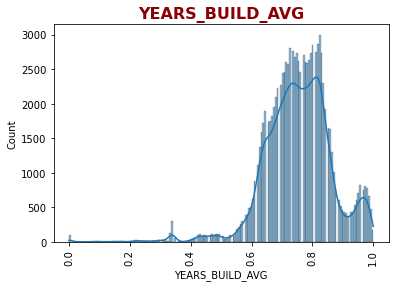

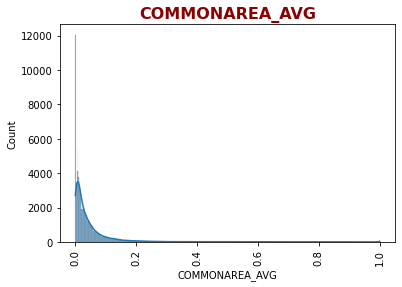

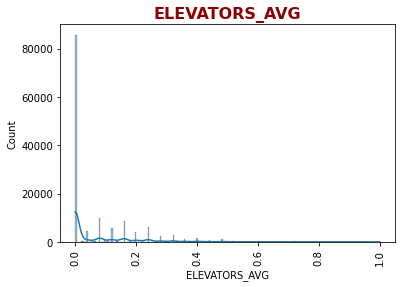

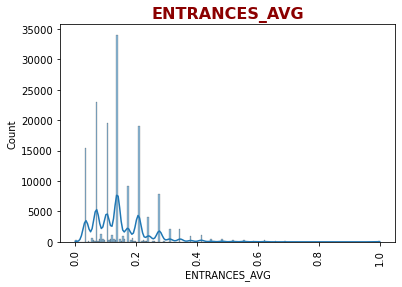

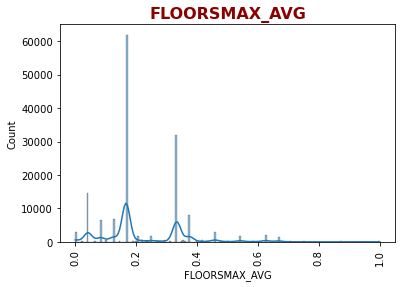

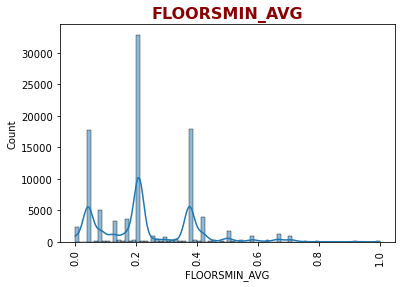

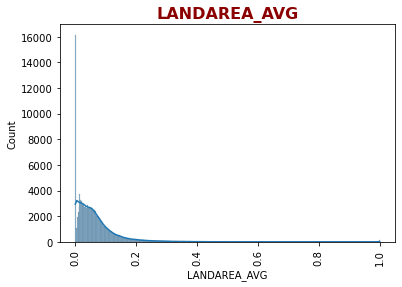

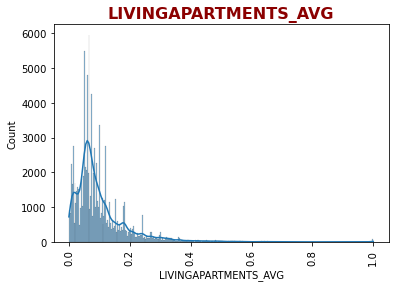

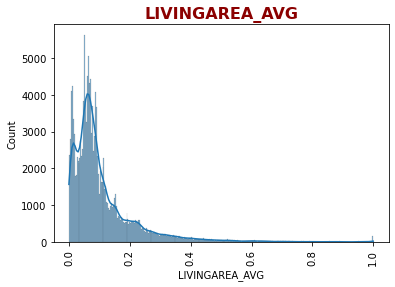

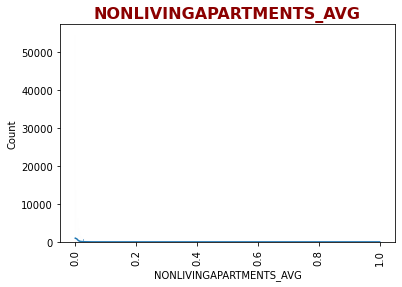

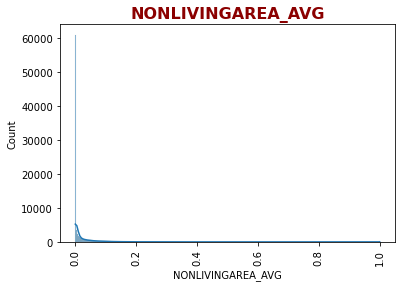

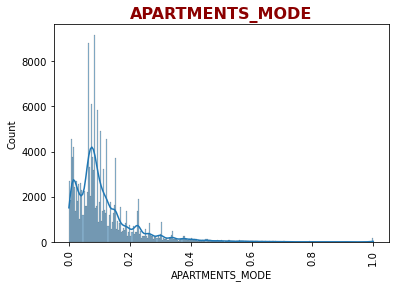

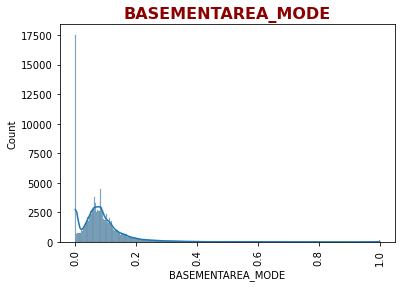

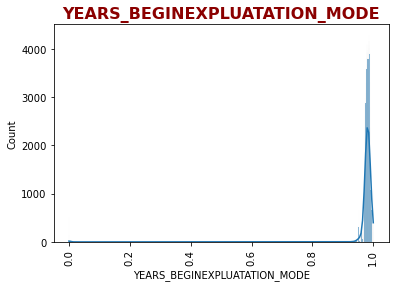

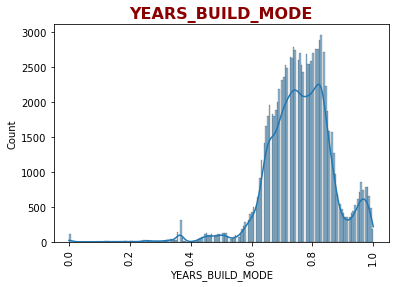

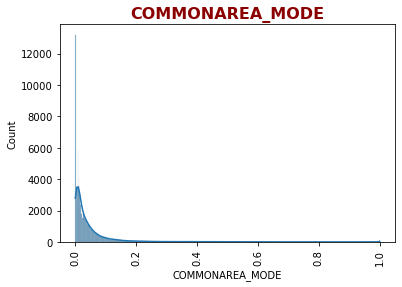

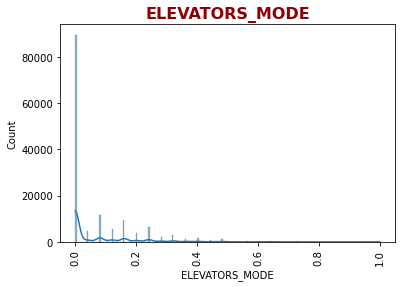

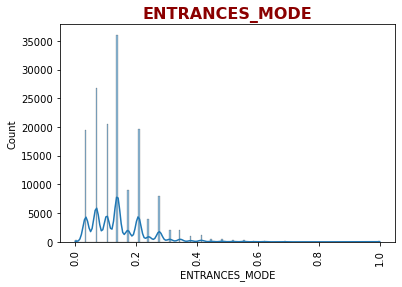

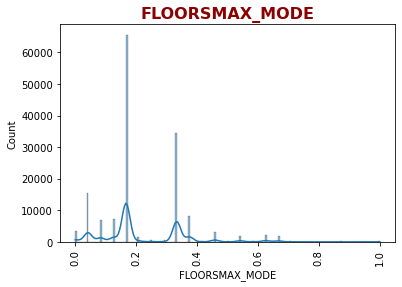

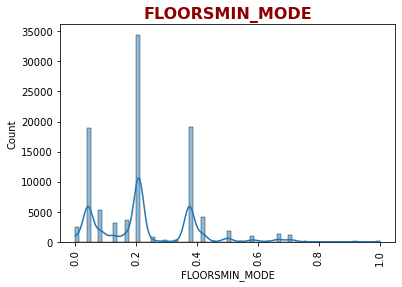

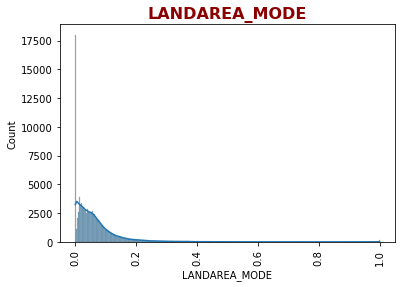

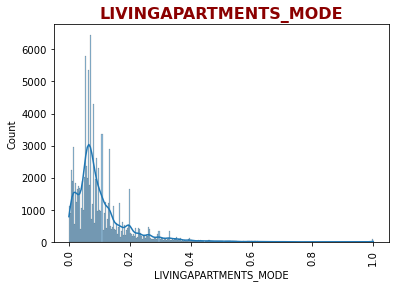

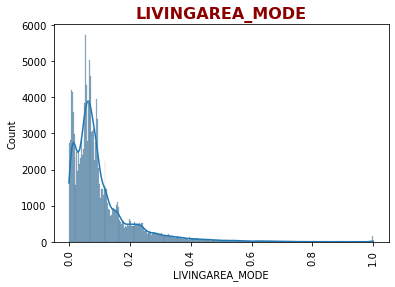

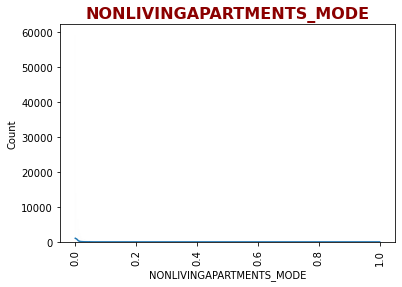

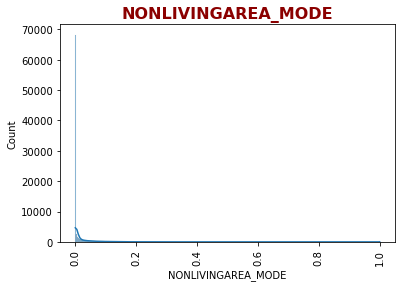

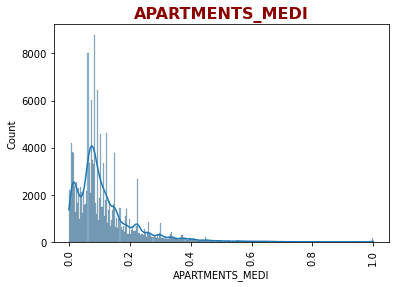

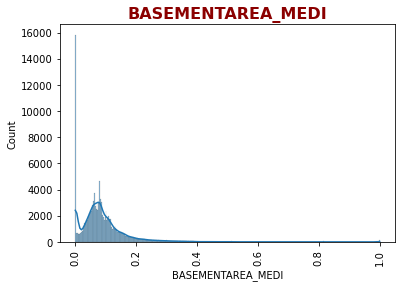

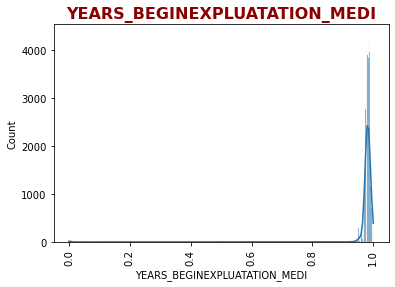

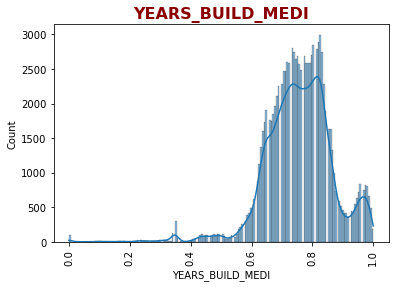

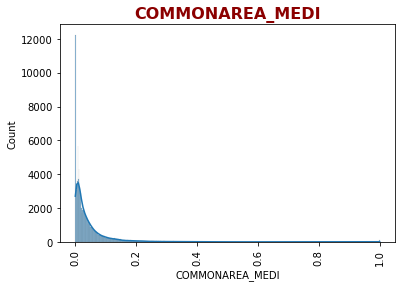

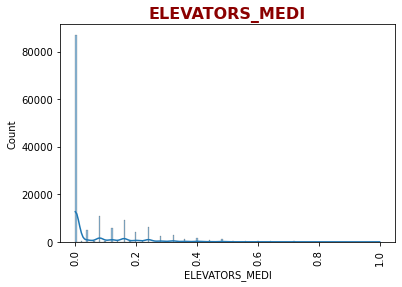

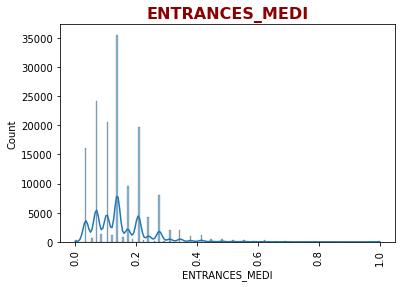

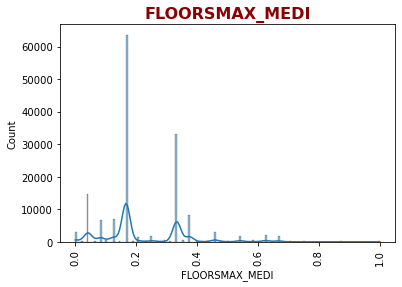

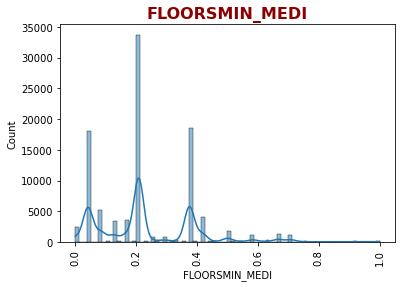

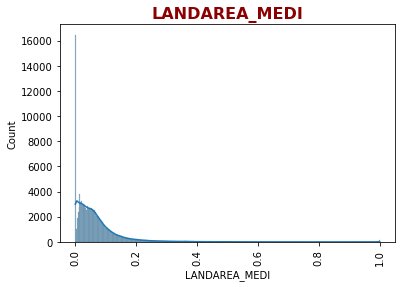

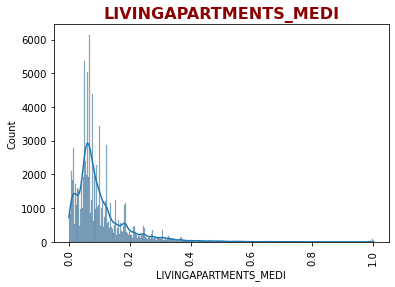

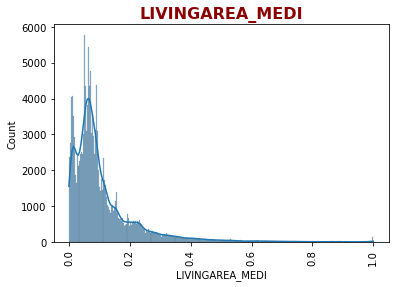

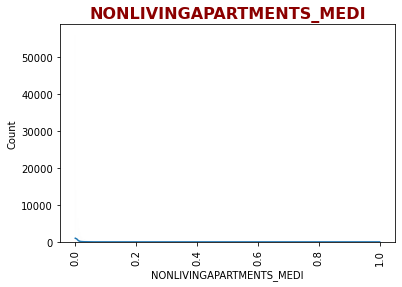

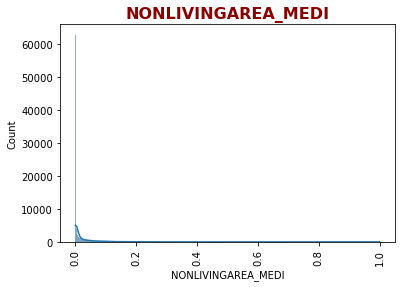

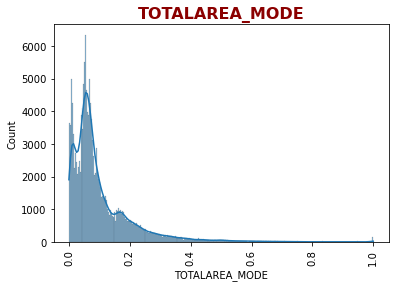

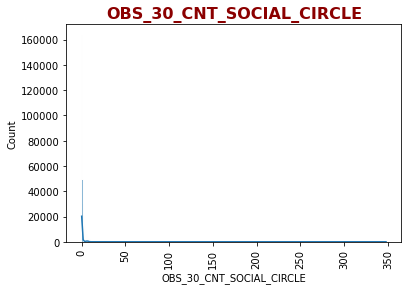

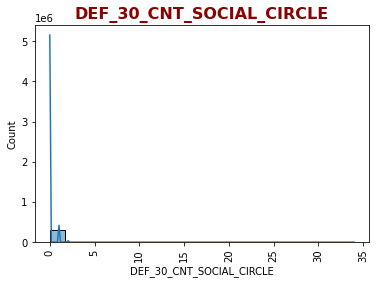

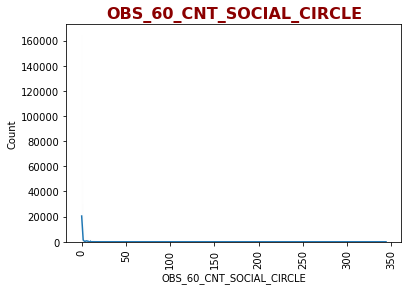

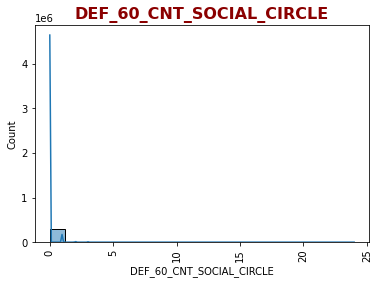

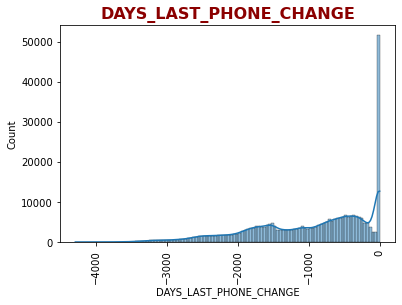

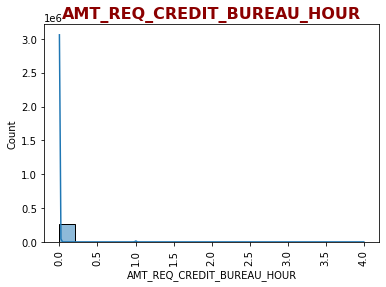

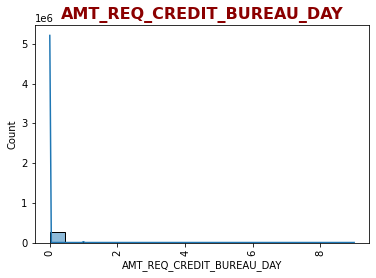

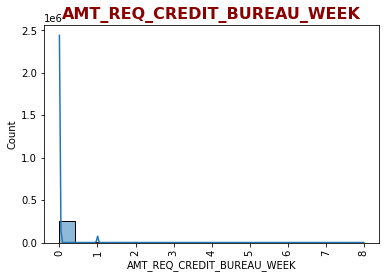

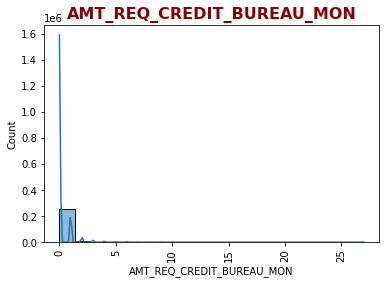

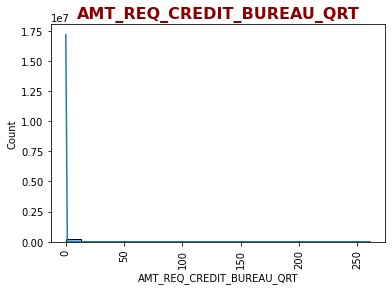

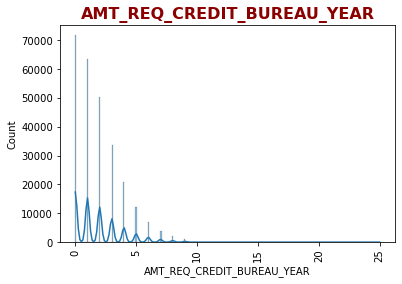

In [121]:
analyse_col_distr(df)

__SUMMARY ON NAN AND RARE UNIQUE VALUES:__

* numeric features with NaN are ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']
-----------
* categorical features with NaN are ['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
---------
* discrete features with NaN are []
----------
* Rare Unique values in:
    * CODE_GENDER = 'XNA'
    * NAME_INCOME_TYPE = 'Unemployed', 'Student', 'Businessman', 'Maternity leave'
    * NAME_FAMILY_STATUS = Unknown
    * FLAG_MOBIL = 0 (bool)
    * maybe FLAG_CONT_MOBILE = 0 (bool - 0=652, 1=355603)
    * FLAG_DOCUMENT_2 = 1
    * FLAG_DOCUMENT_4 = 1
    * FLAG_DOCUMENT_7 = 1
    * FLAG_DOCUMENT_10 = 1
    * FLAG_DOCUMENT_12 = 1
    * plus maybe other FLAG_DOCUMENT_XXX

### Dealing with NaN
Strategy = to deal with them just before modelling phase, with:
* For models NOT handling NaN
    * (Removal of features with more than e.g. 60% of NaN????)
    * imputation by "missing" for categorical features
    * imputation by median (?) for numeric features
* For models handling NaN: leave data as such

### Dealing with rare unique values
* **nb of children: CNT_CHILDREN**

In [122]:
# Distribution of nb children
df.CNT_CHILDREN.value_counts(dropna=False)

0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
14         3
19         2
12         2
10         2
9          2
8          2
11         1
Name: CNT_CHILDREN, dtype: int64

In [123]:
# bit of code to replace rare categories by most similar ones in CNT_CHILDREN -- not added in the end
#df.loc[df['CNT_CHILDREN']] > 5, 'CNT_CHILDREN'] = '6+'

* **'CODE_GENDER'**

In [124]:
# Test and evaluation bit of code from kernel
print('Old Combined df shape: {}'.format(df.shape))
df = df[df['CODE_GENDER'] != 'XNA']
print('New combined df shape: {}'.format(df.shape))

Old Combined df shape: (307511, 122)
New combined df shape: (307507, 122)


* **NAME_FAMILY_STATUS**

In [125]:
print(df['NAME_FAMILY_STATUS'].value_counts(dropna=False))
df['NAME_FAMILY_STATUS'].replace('Unknown', 'Married', inplace=True)
print(df['NAME_FAMILY_STATUS'].value_counts(dropna=False))

Married                 196429
Single / not married     45444
Civil marriage           29774
Separated                19770
Widow                    16088
Unknown                      2
Name: NAME_FAMILY_STATUS, dtype: int64
Married                 196431
Single / not married     45444
Civil marriage           29774
Separated                19770
Widow                    16088
Name: NAME_FAMILY_STATUS, dtype: int64


C:\Users\user\anaconda3\lib\site-packages\pandas\core\series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


* **Mobile-related features**

In [126]:
# Test and evaluation bit of code from kernel
print('Old Combined df shape: {}'.format(df.shape))
df.drop('FLAG_MOBIL', axis=1, inplace=True)
df.drop('FLAG_CONT_MOBILE', axis=1, inplace=True)
print('New combined df shape: {}'.format(df.shape))

Old Combined df shape: (307507, 122)


C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


New combined df shape: (307507, 120)


* **'NAME_INCOME_TYPE'**

In [127]:
# Test and evaluation bit of code - adapted from kernel
print(df['NAME_INCOME_TYPE'].value_counts(dropna=False))
# Changing rare categories of NAME_INCOME_TYPE with the similar categories
df.loc[df['NAME_INCOME_TYPE'] == 'Student', 'NAME_INCOME_TYPE'] = 'Pensioner'
df.loc[df['NAME_INCOME_TYPE'] == 'Maternity leave', 'NAME_INCOME_TYPE'] = 'Pensioner'
df.loc[df['NAME_INCOME_TYPE'] == 'Unemployed', 'NAME_INCOME_TYPE'] = 'Pensioner'
df.loc[df['NAME_INCOME_TYPE'] == 'Businessman', 'NAME_INCOME_TYPE'] = 'Commercial associate'
print(df['NAME_INCOME_TYPE'].value_counts(dropna=False))

Working                 158771
Commercial associate     71616
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64
Working                 158771
Commercial associate     71626
Pensioner                55407
State servant            21703
Name: NAME_INCOME_TYPE, dtype: int64


C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


* **'OCCUPATION_TYPE'**

In [128]:
# Test and evaluation bit of code
print(df['OCCUPATION_TYPE'].value_counts(dropna=False))
# Changing rare categories of OCCUPATION_TYPE with the similar categories
df.loc[df['OCCUPATION_TYPE'] == 'Waiters/barmen staff', 'OCCUPATION_TYPE'] = 'Cooking staff'
df.loc[df['OCCUPATION_TYPE'] == 'Low-skill Laborers', 'OCCUPATION_TYPE'] = 'Laborers'
df.loc[df['OCCUPATION_TYPE'] == 'Realty agents', 'OCCUPATION_TYPE'] = 'Sales staff'
df.loc[df['OCCUPATION_TYPE'] == 'Secretaries', 'OCCUPATION_TYPE'] = 'Core staff'
df.loc[df['OCCUPATION_TYPE'] == 'IT staff', 'OCCUPATION_TYPE'] = 'High skill tech staff'
df.loc[df['OCCUPATION_TYPE'] == 'HR staff', 'OCCUPATION_TYPE'] = 'Core staff'
print(df['OCCUPATION_TYPE'].value_counts(dropna=False))

NaN                      96389
Laborers                 55186
Sales staff              32102
Core staff               27569
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2092
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64
NaN                      96389
Laborers                 57278
Sales staff              32853
Core staff               29437
Managers                 21371
Drivers                  18603
High skill tech staff    11906
Accountants               9813
Medicine staff            8537
Cooking staff             7294
Security staff            6721
Cleaning staff            4653
Pri

In [129]:
# Test: idem but with dyn_rare_encoder function (i.e. as in kernel)
print(df['ORGANIZATION_TYPE'].value_counts(dropna=False))
df = dyn_rare_encoder(df, ['ORGANIZATION_TYPE'], rare_percent=1.9)
print(df['ORGANIZATION_TYPE'].value_counts(dropna=False))

Business Entity Type 3    67992
XNA                       55374
Self-employed             38412
Other                     16683
Medicine                  11192
Business Entity Type 2    10553
Government                10404
School                     8893
Trade: type 7              7831
Kindergarten               6879
Construction               6721
Business Entity Type 1     5983
Transport: type 4          5398
Trade: type 3              3492
Industry: type 9           3368
Industry: type 3           3277
Security                   3247
Housing                    2958
Industry: type 11          2704
Military                   2634
Bank                       2507
Agriculture                2454
Police                     2341
Transport: type 2          2204
Postal                     2157
Security Ministries        1974
Trade: type 2              1900
Restaurant                 1811
Services                   1575
University                 1327
Industry: type 7           1307
Transpor

<ipython-input-115-a3951d08433c>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = np.where(df[col].isin(rare_labels), 'Other', df[col])


* **'HOUSETYPE_MODE'**

In [130]:
# Evaluation of a bit of code (not retained) from kernel - encoding 'HOUSETYPE_MODE'
print(df['HOUSETYPE_MODE'].value_counts(dropna=False))
#df = dyn_rare_encoder(df, ['NAME_TYPE_SUITE'], rare_percent=3.6)

NaN                 154296
block of flats      150500
specific housing      1499
terraced house        1212
Name: HOUSETYPE_MODE, dtype: int64


### Dealing with cyclic features

In [131]:
# test: Changing weekdays with integer values
weekday_dict = {'MONDAY': 1, 'TUESDAY': 2, 'WEDNESDAY': 3, 'THURSDAY': 4, 'FRIDAY': 5, 'SATURDAY': 6, 'SUNDAY': 7}
df.replace({'WEEKDAY_APPR_PROCESS_START': weekday_dict}, inplace=True)
# Creating sin-cos transformed features
df = encode(df, 'WEEKDAY_APPR_PROCESS_START', 7)
df = encode(df, 'HOUR_APPR_PROCESS_START', 23)
# Deleting initial WEEKDAY_APPR_PROCESS_START and HOUR_APPR_PROCESS_START features
df.drop(['WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START'], axis=1, inplace=True)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-115-a3951d08433c>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + '_SIN'] = np.sin(2 * np.pi * df[col]/max_val)
<ipython-input-115-a3951d08433c>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

In [132]:
df['WEEKDAY_APPR_PROCESS_START_COS'].value_counts(dropna=False)

-0.222521    53900
-0.900969    51934
 0.623490    50714
-0.900969    50590
-0.222521    50336
 0.623490    33852
 1.000000    16181
Name: WEEKDAY_APPR_PROCESS_START_COS, dtype: int64

### Dealing with outliers
Only DAYS_EMPLOYED treated here. Other potential outliers > dealt with after modellling if improvement needed

**Aberrant values of DAYS_EMPLOYED - evaluation of what we could replace them by**

In [133]:
df['DAYS_EMPLOYED'].max()

365243

In [134]:
df['NEW_AGE'] = df['DAYS_BIRTH'] / -365
df[df['DAYS_EMPLOYED']==365243]

<ipython-input-134-cf6a48712cf8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NEW_AGE'] = df['DAYS_BIRTH'] / -365


SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
8           100011       0         Cash loans           F            N               Y             0        112500.000   1019610.0      33826.5         913500.0        Children        Pensioner  Secondary / secondary special               Married  House / apartment                    0.018634      -20099         365243            -7427.0            -3514          NaN               0                0           0           0             NaN              2.0                     2   
11          100015       0         Cash loans           F            N               Y             0         38419.155    148365.0      10678.5         135000.0        Children        Pensioner  Secondary / secondary special               Married  House / apartment                    0.015221      -20417         365243            -5246.0            -2512          NaN               0                0           1           0             NaN              2.0                     2   
23          100027       0         Cash loans           F            N               Y             0         83250.000    239850.0      23850.0         225000.0   Unaccompanied        Pensioner  Secondary / secondary special               Married  House / apartment                    0.006296      -24827         365243            -9012.0            -3684          NaN               0                0           1           0             NaN              2.0                     3   
38          100045       0         Cash loans           F            N               Y             0         99000.000    247275.0      17338.5         225000.0   Unaccompanied        Pensioner  Secondary / secondary special               Married  House / apartment                    0.006207      -23920         365243            -9817.0            -4969          NaN               0                0           1           0             NaN              2.0                     2   
43          100050       0         Cash loans           F            N               Y             0        108000.000    746280.0      42970.5         675000.0   Unaccompanied        Pensioner               Higher education  Single / not married  House / apartment                    0.010966      -23548         365243            -5745.0            -4576          NaN               0                0           0           0             NaN              1.0                     2   
...            ...     ...                ...         ...          ...             ...           ...               ...         ...          ...              ...             ...              ...                            ...                   ...                ...                         ...         ...            ...                ...              ...          ...             ...              ...         ...         ...             ...              ...                   ...   
307469      456209       0         Cash loans           F            N               Y             0        202500.000    703728.0      29943.0         607500.0   Unaccompanied        Pensioner  Secondary / secondary special  Single / not married  House / apartment                    0.031329      -22414         365243           -11976.0            -4171          NaN               0                0           0           0             NaN              1.0                     2   
307483      456227       0         Cash loans           F            N               Y             0         99000.000    247275

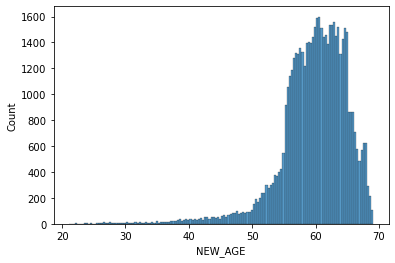

In [135]:
sns.histplot(x='NEW_AGE', data=df[df['DAYS_EMPLOYED']==365243])

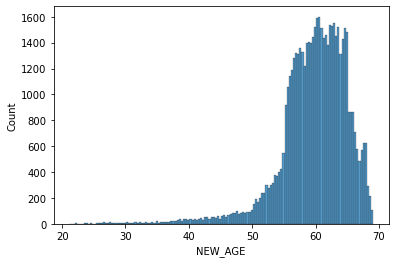

In [136]:
sns.histplot(x='NEW_AGE', data=df[df['NAME_INCOME_TYPE']=='Pensioner'])

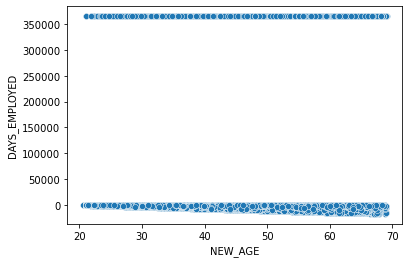

In [137]:
sns.scatterplot(x='NEW_AGE', y='DAYS_EMPLOYED', data=df)

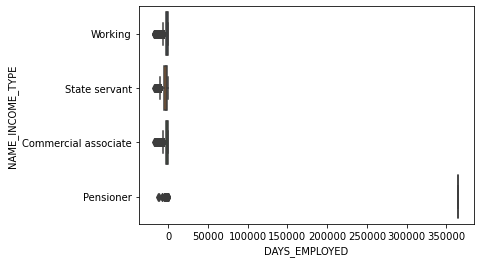

In [138]:
sns.boxplot(x='DAYS_EMPLOYED', y='NAME_INCOME_TYPE', data=df)

In [139]:
# Distribution of indiv with abb val in DAYS8EMPLOYED within NAME_INCOME_TYPE:
df[['DAYS_EMPLOYED','NAME_INCOME_TYPE']][df[['DAYS_EMPLOYED','NAME_INCOME_TYPE']]['DAYS_EMPLOYED'] == 365243]['NAME_INCOME_TYPE'].value_counts()

Pensioner    55374
Name: NAME_INCOME_TYPE, dtype: int64

==> DAYS_EMPLOYED == 365243 (abb val) only for Pensioners and unemployed people, though some pensioners (10 out of 64000+, see below) have a 'real' value.

In [140]:
# The 10 Pensioners with 'real' values for DAYS_EMPLOYED:
df[['DAYS_EMPLOYED','NAME_INCOME_TYPE']][df[['DAYS_EMPLOYED','NAME_INCOME_TYPE']]['NAME_INCOME_TYPE'] == 'Pensioner']\
[df[['DAYS_EMPLOYED','NAME_INCOME_TYPE']][df[['DAYS_EMPLOYED','NAME_INCOME_TYPE']]['NAME_INCOME_TYPE'] == 'Pensioner']['DAYS_EMPLOYED'] != 365243].describe(include='all')

DAYS_EMPLOYED NAME_INCOME_TYPE
count       33.000000               33
unique            NaN                1
top               NaN        Pensioner
freq              NaN               33
mean     -3259.060606              NaN
std       3049.905469              NaN
min     -12865.000000              NaN
25%      -3849.000000              NaN
50%      -2341.000000              NaN
75%      -1346.000000              NaN
max       -191.000000              NaN

In [141]:
df[['DAYS_EMPLOYED','NAME_INCOME_TYPE']][df[['DAYS_EMPLOYED','NAME_INCOME_TYPE']]['NAME_INCOME_TYPE'] == 'Pensioner'].shape[0]

55407

In [142]:
df['NAME_INCOME_TYPE'].value_counts(dropna=False)

Working                 158771
Commercial associate     71626
Pensioner                55407
State servant            21703
Name: NAME_INCOME_TYPE, dtype: int64

In [143]:
df[df['DAYS_EMPLOYED'].isna() == True].shape[0]

0

In [144]:
test = df[['DAYS_EMPLOYED','NAME_INCOME_TYPE','NEW_AGE','DAYS_BIRTH']][df[['DAYS_EMPLOYED','NAME_INCOME_TYPE','NEW_AGE','DAYS_BIRTH']]['NAME_INCOME_TYPE'] == 'Pensioner']\
[df[['DAYS_EMPLOYED','NAME_INCOME_TYPE','NEW_AGE','DAYS_BIRTH']][df[['DAYS_EMPLOYED','NAME_INCOME_TYPE','NEW_AGE','DAYS_BIRTH']]['NAME_INCOME_TYPE'] == 'Pensioner']['DAYS_EMPLOYED'] != 365243]
test['AGE_WHEN_RETIRED'] = (test['DAYS_BIRTH']-test['DAYS_EMPLOYED']) /-365
test

DAYS_EMPLOYED NAME_INCOME_TYPE    NEW_AGE  DAYS_BIRTH  AGE_WHEN_RETIRED
10277           -3294        Pensioner  51.479452      -18790         42.454795
16818            -581        Pensioner  24.972603       -9115         23.380822
18196           -1346        Pensioner  56.621918      -20667         52.934247
33165           -5111        Pensioner  50.526027      -18442         36.523288
42679           -5532        Pensioner  44.758904      -16337         29.602740
48819           -3849        Pensioner  52.547945      -19180         42.002740
48949           -3762        Pensioner  60.728767      -22166         50.421918
49917            -827        Pensioner  39.224658      -14317         36.958904
58096            -795        Pensioner  33.224658      -12127         31.046575
61121           -3620        Pensioner  33.643836      -12280         23.726027
69971            -191        Pensioner  30.791781      -11239         30.268493
89506           -3904        Pensioner  51.386301      -18756         40.690411
104864           -264        Pensioner  54.350685      -19838         53.627397
106630          -2341        Pensioner  60.561644      -22105         54.147945
108373         -11194        Pensioner  59.271233      -21634         28.602740
109612          -1223        Pensioner  40.939726      -14943         37.589041
113694         -12865        Pensioner  55.539726      -20272         20.293151
124165          -1895        Pensioner  57.016438      -20811         51.824658
134595          -8140        Pensioner  41.632877      -15196         19.331507
180890          -8005        Pensioner  52.843836      -19288         30.912329
186956           -248        Pensioner  32.443836      -11842         31.764384
199357          -1776        Pensioner  32.506849      -11865         27.641096
206030          -3261        Pensioner  57.512329      -20992         48.578082
209627           -382        Pensioner  47.298630      -17264         46.252055
218269          -3629        Pensioner  35.947945      -13121         26.005479
261014          -1925        Pensioner  24.142466       -8812         18.868493
263639          -2415        Pensioner  34.101370      -12447         27.484932
274863          -1636        Pensioner  57.676712      -21052         53.194521
289119          -1692        Pensioner  22.698630       -8285         18.063014
291432          -3020        Pensioner  39.350685      -14363         31.076712
291644          -1669        Pensioner  50.824658      -18551         46.252055
295458          -1550        Pensioner  26.079452       -9519         21.832877
301408          -5607        Pensioner  43.205479      -15770         27.843836

In [145]:
df[['DAYS_EMPLOYED','NAME_INCOME_TYPE']][df[['DAYS_EMPLOYED','NAME_INCOME_TYPE']]['NAME_INCOME_TYPE'] == 'Student']

Empty DataFrame
Columns: [DAYS_EMPLOYED, NAME_INCOME_TYPE]
Index: []

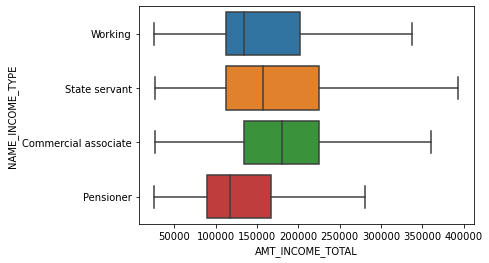

In [146]:
sns.boxplot(x='AMT_INCOME_TOTAL', y='NAME_INCOME_TYPE', data=df, showfliers=False)

In [147]:
df[['DAYS_EMPLOYED']][df[['DAYS_EMPLOYED']]['DAYS_EMPLOYED']!=365243].describe(include='all')

DAYS_EMPLOYED
count  252133.000000
mean    -2384.142254
std      2338.327666
min    -17912.000000
25%     -3175.000000
50%     -1648.000000
75%      -767.000000
max         0.000000

In [148]:
df[df['DAYS_EMPLOYED']==0]

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
23691       127568       0         Cash loans           F            N               N             2          189000.0    983299.5      36571.5         904500.0          Family          Working               Higher education          Separated  House / apartment                    0.025164      -12609              0            -2116.0            -4452          NaN               1                0           0           0             NaN              3.0                     2   
121625      241013       1         Cash loans           F            N               Y             1          112500.0    134775.0       7438.5         112500.0   Unaccompanied          Working  Secondary / secondary special     Civil marriage  House / apartment                    0.007020      -15053              0            -4598.0            -4385          NaN               1                1           1           0     Sales staff              3.0                     2   

        REGION_RATING_CLIENT_W_CITY  REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY       ORGANIZATION_TYPE  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  NONLIVINGAPARTMENTS_AVG  \
23691                             2                           0                           0                            0                       0                       0                        0  Business Entity Type 1      0.409224      0.323724      0.379100          0.0825            0.0563                       0.9906           0.8708          0.0178           0.08          0.069          0.375         0.4167        0.0894                0.0672             0.1                      0.0   
121625                            2                           0                           0                            0                       1                       0                        1           Self-employed           NaN      0.558081      0.609276             NaN               NaN                          NaN              NaN             NaN            NaN            NaN            NaN            NaN           NaN                   NaN             NaN                      NaN   

        NONLIVINGAREA_AVG  APARTMENTS_MODE  BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  COMMONAREA_MODE  ELEVATORS_MODE  ENTRANCES_MODE  FLOORSMAX_MODE  FLOORSMIN_MODE  LANDAREA_MODE  LIVINGAPARTMENTS_MODE  LIVINGAREA_MODE  NONLIVINGAPARTMENTS_MODE  NONLIVINGAREA_MODE  APARTMENTS_MEDI  BASEMENTAREA_MEDI  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BUILD_MEDI  COMMONAREA_MEDI  ELEVATORS_MEDI  ENTRANCES_MEDI  FLOORSMAX_MEDI  FLOORSMIN_MEDI  LANDAREA_MEDI  LIVINGAPARTMENTS_MEDI  \
23691                 0.0            0.084             0.0584                        0.9906            0.8759           0.0179          0.0806           0.069           0.375          0.4167         0.0915                 0.0735           0.1042                       0.0                 0.0           0.0833             0.0563                        0.9906            0.8725           0.0179            0.08           0.069           0.375          0.4167          0.091                 0.0684   
121625                NaN              NaN                NaN               

In [149]:
df[df['DAYS_EMPLOYED']==-17912]

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE            NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL        OCCUPATION_TYPE  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
280994      425566       0         Cash loans           F            Y               Y             0          180000.0    225000.0      21919.5         225000.0   Unaccompanied          Working  Secondary / secondary special  Single / not married  House / apartment                    0.010643      -24577         -17912            -4457.0            -4432          1.0               1                0           0           0  High skill tech staff              1.0                     2   

        REGION_RATING_CLIENT_W_CITY  REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY       ORGANIZATION_TYPE  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  NONLIVINGAPARTMENTS_AVG  \
280994                            2                           0                           0                            0                       0                       0                        0  Business Entity Type 3           NaN      0.479753      0.652897          0.0825            0.0725                       0.9757           0.6668          0.0069            0.0         0.1379         0.1667         0.2083        0.0433                0.0597           0.055                   0.0347   

        NONLIVINGAREA_AVG  APARTMENTS_MODE  BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  COMMONAREA_MODE  ELEVATORS_MODE  ENTRANCES_MODE  FLOORSMAX_MODE  FLOORSMIN_MODE  LANDAREA_MODE  LIVINGAPARTMENTS_MODE  LIVINGAREA_MODE  NONLIVINGAPARTMENTS_MODE  NONLIVINGAREA_MODE  APARTMENTS_MEDI  BASEMENTAREA_MEDI  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BUILD_MEDI  COMMONAREA_MEDI  ELEVATORS_MEDI  ENTRANCES_MEDI  FLOORSMAX_MEDI  FLOORSMIN_MEDI  LANDAREA_MEDI  LIVINGAPARTMENTS_MEDI  \
280994             0.0317            0.084             0.0753                        0.9757            0.6798            0.007             0.0          0.1379          0.1667          0.2083         0.0443                 0.0652           0.0573                     0.035              0.0336           0.0833             0.0725                        0.9757            0.6713            0.007             0.0          0.1379          0.1667          0.2083         0.0441                 0.0607   

        LIVINGAREA_MEDI  NONLIVINGAPARTMENTS_MEDI  NONLIVINGAREA_MEDI FONDKAPREMONT_MODE  HOUSETYPE_MODE  TOTALAREA_MODE WALLSMATERIAL_MODE EMERGENCYSTATE_MODE  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  OBS_60_CNT_SOCIAL_CIRCLE  DEF_60_CNT_SOCIAL_CIRCLE  DAYS_LAST_PHONE_CHANGE  FLAG_DOCUMENT_2  FLAG_DOCUMENT_3  FLAG_DOCUMENT_4  FLAG_DOCUMENT_5  FLAG_DOCUMENT_6  FLAG_DOCUMENT_7  FLAG_DOCUMENT_8  FLAG_DOCUMENT_9  FLAG_DOCUMENT_10  FLAG_DOCUMENT_11  FLAG_DOCUMENT_12  FLAG_DOCUMENT_13  \
280994            0.056                    0.0349              0.0324   reg oper account  block of flats          0.0539       Stone, brick                  No                       0.0                       0.0                       0.0                       0.0                  -677.0                0                0                0                0                1                0                0                0                 0                 0                 0                 0   

        FLAG_DOCUMENT_14  FLAG_DOC

In [150]:
df[df['NAME_INCOME_TYPE'] == 'Unemployed']

Empty DataFrame
Columns: [SK_ID_CURR, TARGET, NAME_CONTRACT_TYPE, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION_TYPE, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, ORGANIZATION_TYPE, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AVG, FLOORSMAX_AVG, FLOORSMIN_AVG, LANDAREA_AVG, LIVINGAPARTMENTS_AVG, LIVINGAREA_AVG, NONLIVINGAPARTMENTS_AVG, NONLIVINGAREA_AVG, APARTMENTS_MODE, BASEMENTAREA_MODE, YEARS_BEGINEXPLUATATION_MODE, YEARS_BUILD_MODE, COMMONAREA_MODE, ELEVATORS_MODE, ENTRANCES_MODE, FLOORSMAX_MODE, FLOORSMIN_MODE, LANDAREA_MODE, LIVINGAPARTMENTS_MODE, LIVINGAREA_MODE, NONLIVINGAPARTMENTS_MODE, NONLIVINGAREA_MODE, APARTMENTS_MEDI, BASEMENTAREA_MEDI, YEARS_BEGINEXPLUATATION_MEDI, YEARS_BUILD_MEDI, COMMONAREA_MEDI, ELEVATORS_MEDI, ENTRANCES_MEDI, FLOORSMAX_MEDI, FLOORSMIN_MEDI, LANDAREA_MEDI, LIVINGAPARTMENTS_MEDI, LIVINGAREA_MEDI, NONLIVINGAPARTMENTS_MEDI, NONLIVINGAREA_MEDI, FONDKAPREMONT_MODE, HOUSETYPE_MODE, TOTALAREA_MODE, WALLSMATERIAL_MODE, EMERGENCYSTATE_MODE, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, FLAG_DOCUMENT_4, FLAG_DOCUMENT_5, FLAG_DOCUMENT_6, FLAG_DOCUMENT_7, FLAG_DOCUMENT_8, FLAG_DOCUMENT_9, ...]
Index: []

In [151]:
# Replacement these outliers by 0 (they are not currently working)
df['DAYS_EMPLOYED'] = np.where(df['NAME_INCOME_TYPE']=='Pensioner', 0, df['DAYS_EMPLOYED'])
df['DAYS_EMPLOYED'] = np.where(df['NAME_INCOME_TYPE']=='Unemployed', 0, df['DAYS_EMPLOYED'])

<ipython-input-151-ff57e58ff94f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DAYS_EMPLOYED'] = np.where(df['NAME_INCOME_TYPE']=='Pensioner', 0, df['DAYS_EMPLOYED'])
<ipython-input-151-ff57e58ff94f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DAYS_EMPLOYED'] = np.where(df['NAME_INCOME_TYPE']=='Unemployed', 0, df['DAYS_EMPLOYED'])


In [152]:
# Check
df[df['DAYS_EMPLOYED'] == 365243].shape[0]

0

In [153]:
# Check
df[df['DAYS_EMPLOYED'] == 0]['NAME_INCOME_TYPE'].value_counts(dropna=False)

Pensioner    55407
Working          2
Name: NAME_INCOME_TYPE, dtype: int64

### Creating new features
* **Simple features** (others included but not tested here)

In [154]:
# Test: differences between
df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])
# and
df['NEW_ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']

    # in terms of NaN
for col in ['AMT_ANNUITY','AMT_INCOME_TOTAL','NEW_ANNUITY_TO_INCOME_RATIO','NEW_ANNUITY_INCOME_PERC']:
    print(col)
    print('Nb of Nan = {} out of {}'.format(df[col].isna().sum(), df.shape[0]))
    print('-' * 40)

AMT_ANNUITY
Nb of Nan = 12 out of 307507
----------------------------------------
AMT_INCOME_TOTAL
Nb of Nan = 0 out of 307507
----------------------------------------
NEW_ANNUITY_TO_INCOME_RATIO
Nb of Nan = 12 out of 307507
----------------------------------------
NEW_ANNUITY_INCOME_PERC
Nb of Nan = 12 out of 307507
----------------------------------------


<ipython-input-154-fe3f428d4ad8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NEW_ANNUITY_TO_INCOME_RATIO'] = df['AMT_ANNUITY'] / (1 + df['AMT_INCOME_TOTAL'])
<ipython-input-154-fe3f428d4ad8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NEW_ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']


In [155]:
    # in terms of values / distribution
df[['NEW_ANNUITY_TO_INCOME_RATIO','NEW_ANNUITY_INCOME_PERC']].describe(include='all')

NEW_ANNUITY_TO_INCOME_RATIO  NEW_ANNUITY_INCOME_PERC
count                307495.000000            307495.000000
mean                      0.180929                 0.180931
std                       0.094573                 0.094574
min                       0.000224                 0.000224
25%                       0.114782                 0.114783
50%                       0.162832                 0.162833
75%                       0.229065                 0.229067
max                       1.875892                 1.875965

* **Check/test: new features based on EXT_SOURCE scores**

In [156]:
# Mean and standard deviation
df["NEW_EXT_SOURCE_MEAN"] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
df['NEW_EXT_SOURCE_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)

for col in ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','NEW_EXT_SOURCE_MEAN','NEW_EXT_SOURCE_STD']:
    print(col)
    print('Nb of Nan = {} out of {}'.format(df[col].isna().sum(), df.shape[0]))
    print('-' * 40)

EXT_SOURCE_1
Nb of Nan = 173376 out of 307507
----------------------------------------
EXT_SOURCE_2
Nb of Nan = 660 out of 307507
----------------------------------------
EXT_SOURCE_3
Nb of Nan = 60965 out of 307507
----------------------------------------
NEW_EXT_SOURCE_MEAN
Nb of Nan = 172 out of 307507
----------------------------------------
NEW_EXT_SOURCE_STD
Nb of Nan = 36909 out of 307507
----------------------------------------


<ipython-input-156-19051df6bd2b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["NEW_EXT_SOURCE_MEAN"] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
<ipython-input-156-19051df6bd2b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NEW_EXT_SOURCE_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)


In [157]:
df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','NEW_EXT_SOURCE_MEAN','NEW_EXT_SOURCE_STD']].describe(include='all')

EXT_SOURCE_1  EXT_SOURCE_2   EXT_SOURCE_3  NEW_EXT_SOURCE_MEAN  NEW_EXT_SOURCE_STD
count  134131.000000  3.068470e+05  246542.000000        307335.000000        2.705980e+05
mean        0.502129  5.143918e-01       0.510856             0.509252        1.512447e-01
std         0.211063  1.910603e-01       0.194843             0.149803        9.991076e-02
min         0.014568  8.173617e-08       0.000527             0.000006        3.538459e-07
25%         0.334007  3.924574e-01       0.370650             0.413649        7.238535e-02
50%         0.505998  5.659614e-01       0.535276             0.524503        1.360205e-01
75%         0.675057  6.636171e-01       0.669057             0.622822        2.143846e-01
max         0.962693  8.549997e-01       0.896010             0.878903        6.519439e-01

In [158]:
df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','NEW_EXT_SOURCE_MEAN','NEW_EXT_SOURCE_STD']]

EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  NEW_EXT_SOURCE_MEAN  NEW_EXT_SOURCE_STD
0           0.083037      0.262949      0.139376             0.161787            0.092026
1           0.311267      0.622246           NaN             0.466757            0.219895
2                NaN      0.555912      0.729567             0.642739            0.122792
3                NaN      0.650442           NaN             0.650442                 NaN
4                NaN      0.322738           NaN             0.322738                 NaN
...              ...           ...           ...                  ...                 ...
307506      0.145570      0.681632           NaN             0.413601            0.379053
307507           NaN      0.115992           NaN             0.115992                 NaN
307508      0.744026      0.535722      0.218859             0.499536            0.264447
307509           NaN      0.514163      0.661024             0.587593            0.103846
307510      0.734460      0.708569      0.113922             0.518984            0.351032

[307507 rows x 5 columns]

In [159]:
# Replacement by 0 of NaN in NEW_EXT_SOURCE_STD due to single ext score
df['NEW_EXT_SOURCE_STD'] = np.where(df['NEW_EXT_SOURCE_MEAN'].isna() == False, df['NEW_EXT_SOURCE_STD'].fillna(0),df['NEW_EXT_SOURCE_STD'])

<ipython-input-159-505767d0d64d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NEW_EXT_SOURCE_STD'] = np.where(df['NEW_EXT_SOURCE_MEAN'].isna() == False, df['NEW_EXT_SOURCE_STD'].fillna(0),df['NEW_EXT_SOURCE_STD'])


In [160]:
# Verif
for col in ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3','NEW_EXT_SOURCE_MEAN','NEW_EXT_SOURCE_STD']:
    print(col)
    print('Nb of Nan = {} out of {}'.format(df[col].isna().sum(), df.shape[0]))
    print('-' * 40)

EXT_SOURCE_1
Nb of Nan = 173376 out of 307507
----------------------------------------
EXT_SOURCE_2
Nb of Nan = 660 out of 307507
----------------------------------------
EXT_SOURCE_3
Nb of Nan = 60965 out of 307507
----------------------------------------
NEW_EXT_SOURCE_MEAN
Nb of Nan = 172 out of 307507
----------------------------------------
NEW_EXT_SOURCE_STD
Nb of Nan = 172 out of 307507
----------------------------------------


In [161]:
df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','NEW_EXT_SOURCE_MEAN','NEW_EXT_SOURCE_STD']][df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','NEW_EXT_SOURCE_MEAN','NEW_EXT_SOURCE_STD']]['NEW_EXT_SOURCE_MEAN'].isna() == True]

EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  NEW_EXT_SOURCE_MEAN  NEW_EXT_SOURCE_STD
349              NaN           NaN           NaN                  NaN                 NaN
3525             NaN           NaN           NaN                  NaN                 NaN
4562             NaN           NaN           NaN                  NaN                 NaN
7220             NaN           NaN           NaN                  NaN                 NaN
7402             NaN           NaN           NaN                  NaN                 NaN
...              ...           ...           ...                  ...                 ...
301170           NaN           NaN           NaN                  NaN                 NaN
302204           NaN           NaN           NaN                  NaN                 NaN
305380           NaN           NaN           NaN                  NaN                 NaN
306208           NaN           NaN           NaN                  NaN                 NaN
307387           NaN           NaN           NaN                  NaN                 NaN

[172 rows x 5 columns]

In [162]:
df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','NEW_EXT_SOURCE_MEAN','NEW_EXT_SOURCE_STD']][df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3','NEW_EXT_SOURCE_MEAN','NEW_EXT_SOURCE_STD']]['NEW_EXT_SOURCE_STD'] == 0]

EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  NEW_EXT_SOURCE_MEAN  NEW_EXT_SOURCE_STD
3                NaN      0.650442           NaN             0.650442                 0.0
4                NaN      0.322738           NaN             0.322738                 0.0
9                NaN      0.746644           NaN             0.746644                 0.0
17               NaN      0.683513           NaN             0.683513                 0.0
34               NaN      0.172498           NaN             0.172498                 0.0
...              ...           ...           ...                  ...                 ...
307466           NaN      0.639970           NaN             0.639970                 0.0
307484           NaN      0.739703           NaN             0.739703                 0.0
307501           NaN      0.575481           NaN             0.575481                 0.0
307504           NaN      0.530725           NaN             0.530725                 0.0
307507           NaN      0.115992           NaN             0.115992                 0.0

[36737 rows x 5 columns]

* **New features based on all FLAG_DOCUMENT_XXXXX** - enables dealing with most of their rare values at the same time

In [167]:
analyse_col_distr(df.loc[:, 'FLAG_DOCUMENT_2':'FLAG_DOCUMENT_21'])
df['NEW_NB_TOTAL_DOC'] = df.loc[:, 'FLAG_DOCUMENT_2':'FLAG_DOCUMENT_21'].sum(axis=1)
print('-' * 100)
print('-' * 100)
print('-' * 100)
print('nb of Nan:', df['NEW_NB_TOTAL_DOC'].isna().sum())
print('unique val:', df['NEW_NB_TOTAL_DOC'].value_counts(dropna=False))
#df.drop(df.loc[:, 'FLAG_DOCUMENT_2':'FLAG_DOCUMENT_21'], axis=1, inplace=True)

df shape = (307507, 20)
nb of duplicates = 307435
----------------------------------------
----------------------------------------
FLAG_DOCUMENT_2  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 307507
--------------------
categorical-like
Nb unique values = 2
0    307494
1        13
Name: FLAG_DOCUMENT_2, dtype: int64
----------------------------------------
----------------------------------------
FLAG_DOCUMENT_3  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 307507
--------------------
categorical-like
Nb unique values = 2
1    218340
0     89167
Name: FLAG_DOCUMENT_3, dtype: int64
----------------------------------------
----------------------------------------
FLAG_DOCUMENT_4  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 307507
--------------------
categorical-like
Nb unique values = 2
0    307482
1        25
Name: FLAG_DOCUMENT_4, dtype: int64
----------------------------------------
----------------------------------------
FLAG_DOCUMENT

<ipython-input-167-97754434e2c7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['NEW_NB_TOTAL_DOC'] = df.loc[:, 'FLAG_DOCUMENT_2':'FLAG_DOCUMENT_21'].sum(axis=1)


### Encoding
* **Check binary features**

In [168]:
# Check bin_feature
for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    print(bin_feature)
    print(df[bin_feature].value_counts(dropna=False))
    print('-' * 40)

CODE_GENDER
F    202448
M    105059
Name: CODE_GENDER, dtype: int64
----------------------------------------
FLAG_OWN_CAR
N    202922
Y    104585
Name: FLAG_OWN_CAR, dtype: int64
----------------------------------------
FLAG_OWN_REALTY
Y    213308
N     94199
Name: FLAG_OWN_REALTY, dtype: int64
----------------------------------------


* **Check categorical features**

In [170]:
df, cat_cols = one_hot_encoder(df, nan_as_category=True)

In [175]:
df.head(0)

Empty DataFrame
Columns: [SK_ID_CURR, TARGET, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_PHONE, FLAG_EMAIL, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AVG, FLOORSMAX_AVG, FLOORSMIN_AVG, LANDAREA_AVG, LIVINGAPARTMENTS_AVG, LIVINGAREA_AVG, NONLIVINGAPARTMENTS_AVG, NONLIVINGAREA_AVG, APARTMENTS_MODE, BASEMENTAREA_MODE, YEARS_BEGINEXPLUATATION_MODE, YEARS_BUILD_MODE, COMMONAREA_MODE, ELEVATORS_MODE, ENTRANCES_MODE, FLOORSMAX_MODE, FLOORSMIN_MODE, LANDAREA_MODE, LIVINGAPARTMENTS_MODE, LIVINGAREA_MODE, NONLIVINGAPARTMENTS_MODE, NONLIVINGAREA_MODE, APARTMENTS_MEDI, BASEMENTAREA_MEDI, YEARS_BEGINEXPLUATATION_MEDI, YEARS_BUILD_MEDI, COMMONAREA_MEDI, ELEVATORS_MEDI, ENTRANCES_MEDI, FLOORSMAX_MEDI, FLOORSMIN_MEDI, LANDAREA_MEDI, LIVINGAPARTMENTS_MEDI, LIVINGAREA_MEDI, NONLIVINGAPARTMENTS_MEDI, NONLIVINGAREA_MEDI, TOTALAREA_MODE, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, FLAG_DOCUMENT_2, FLAG_DOCUMENT_3, FLAG_DOCUMENT_4, FLAG_DOCUMENT_5, FLAG_DOCUMENT_6, FLAG_DOCUMENT_7, FLAG_DOCUMENT_8, FLAG_DOCUMENT_9, FLAG_DOCUMENT_10, FLAG_DOCUMENT_11, FLAG_DOCUMENT_12, FLAG_DOCUMENT_13, FLAG_DOCUMENT_14, FLAG_DOCUMENT_15, FLAG_DOCUMENT_16, FLAG_DOCUMENT_17, FLAG_DOCUMENT_18, FLAG_DOCUMENT_19, FLAG_DOCUMENT_20, FLAG_DOCUMENT_21, AMT_REQ_CREDIT_BUREAU_HOUR, AMT_REQ_CREDIT_BUREAU_DAY, AMT_REQ_CREDIT_BUREAU_WEEK, ...]
Index: []

In [193]:
check_encoded_cat_cols(df, cat_cols)

nb of categorical columns created though OHE =  90
--------------------
['NAME_CONTRACT_TYPE_Cash loans', 'NAME_CONTRACT_TYPE_Revolving loans', 'NAME_CONTRACT_TYPE_nan', 'CODE_GENDER_F', 'CODE_GENDER_M', 'CODE_GENDER_nan', 'FLAG_OWN_CAR_N', 'FLAG_OWN_CAR_Y', 'FLAG_OWN_CAR_nan', 'FLAG_OWN_REALTY_N', 'FLAG_OWN_REALTY_Y', 'FLAG_OWN_REALTY_nan', 'NAME_TYPE_SUITE_Children', 'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Group of people', 'NAME_TYPE_SUITE_Other_A', 'NAME_TYPE_SUITE_Other_B', 'NAME_TYPE_SUITE_Spouse, partner', 'NAME_TYPE_SUITE_Unaccompanied', 'NAME_TYPE_SUITE_nan', 'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Working', 'NAME_INCOME_TYPE_nan', 'NAME_EDUCATION_TYPE_Academic degree', 'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Incomplete higher', 'NAME_EDUCATION_TYPE_Lower secondary', 'NAME_EDUCATION_TYPE_Secondary / secondary special', 'NAME_EDUCATION_TYPE_nan', 'NAME_FAMILY_STATUS_Civil 

Nb of Nan = 0 out of 307507
Nb of unique values = 2
--------------------
WALLSMATERIAL_MODE_Others
Nb of Nan = 0 out of 307507
Nb of unique values = 2
--------------------
WALLSMATERIAL_MODE_Panel
Nb of Nan = 0 out of 307507
Nb of unique values = 2
--------------------
WALLSMATERIAL_MODE_Stone, brick
Nb of Nan = 0 out of 307507
Nb of unique values = 2
--------------------
WALLSMATERIAL_MODE_Wooden
Nb of Nan = 0 out of 307507
Nb of unique values = 2
--------------------
WALLSMATERIAL_MODE_nan
Nb of Nan = 0 out of 307507
Nb of unique values = 2
--------------------
EMERGENCYSTATE_MODE_No
Nb of Nan = 0 out of 307507
Nb of unique values = 2
--------------------
EMERGENCYSTATE_MODE_Yes
Nb of Nan = 0 out of 307507
Nb of unique values = 2
--------------------
EMERGENCYSTATE_MODE_nan
Nb of Nan = 0 out of 307507
Nb of unique values = 2
--------------------
----------------------------------------------------------------------------------------------------
nb of cat_cols with NaN = 0
No OHE issu

### Test of full and clean code for pre-processing Train Data
* **Full and clean code**

In [8]:
def application_train(num_rows=None, nan_as_category=True):
    # Read and merge data
    df = pd.read_csv(path+'application_train.csv', nrows=num_rows)
    print("Train df shape: {}".format(df.shape))

    # Removing 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']

    # Deleting FLAG_MOBIL because there is only 1 person without mobile phone
    df.drop('FLAG_MOBIL', axis=1, inplace=True)
    df.drop('FLAG_CONT_MOBILE', axis=1, inplace=True)

    # Replacement of DAYS_EMPLOYED == 365243 (i.e. concerns Pensioners and unemployed people only) and homogenization
    df['DAYS_EMPLOYED'] = np.where(df['NAME_INCOME_TYPE']=='Pensioner', 0, df['DAYS_EMPLOYED'])
    df['DAYS_EMPLOYED'] = np.where(df['NAME_INCOME_TYPE']=='Unemployed', 0, df['DAYS_EMPLOYED'])

    # Changing rare categories of NAME_INCOME_TYPE with the similar categories
    df.loc[df['NAME_INCOME_TYPE'] == 'Student', 'NAME_INCOME_TYPE'] = 'Pensioner'
    df.loc[df['NAME_INCOME_TYPE'] == 'Maternity leave', 'NAME_INCOME_TYPE'] = 'Pensioner'
    df.loc[df['NAME_INCOME_TYPE'] == 'Unemployed', 'NAME_INCOME_TYPE'] = 'Pensioner'
    df.loc[df['NAME_INCOME_TYPE'] == 'Businessman', 'NAME_INCOME_TYPE'] = 'Commercial associate'
    
    ####ADDED#### Changing rare categories of OCCUPATION_TYPE with similar categories
    df.loc[df['OCCUPATION_TYPE'] == 'Waiters/barmen staff', 'OCCUPATION_TYPE'] = 'Cooking staff'
    df.loc[df['OCCUPATION_TYPE'] == 'Low-skill Laborers', 'OCCUPATION_TYPE'] = 'Laborers'
    df.loc[df['OCCUPATION_TYPE'] == 'Realty agents', 'OCCUPATION_TYPE'] = 'Sales staff'
    df.loc[df['OCCUPATION_TYPE'] == 'Secretaries', 'OCCUPATION_TYPE'] = 'Core staff'
    df.loc[df['OCCUPATION_TYPE'] == 'IT staff', 'OCCUPATION_TYPE'] = 'High skill tech staff'
    df.loc[df['OCCUPATION_TYPE'] == 'HR staff', 'OCCUPATION_TYPE'] = 'Core staff'

    # Dynamic rare encoding
    df = dyn_rare_encoder(df, ['ORGANIZATION_TYPE'], rare_percent=1.9)

    #  Changing unknown family status with the most observed category
    df['NAME_FAMILY_STATUS'].replace('Unknown', 'Married', inplace=True)

    # Changing weekdays with integer values
    weekday_dict = {'MONDAY': 1, 'TUESDAY': 2, 'WEDNESDAY': 3, 'THURSDAY': 4, 'FRIDAY': 5, 'SATURDAY': 6, 'SUNDAY': 7}
    df.replace({'WEEKDAY_APPR_PROCESS_START': weekday_dict}, inplace=True)
    # Creating sin-cos transformed features
    df = encode(df, 'WEEKDAY_APPR_PROCESS_START', 7)
    df = encode(df, 'HOUR_APPR_PROCESS_START', 23)
    # Deleting initial WEEKDAY_APPR_PROCESS_START and HOUR_APPR_PROCESS_START features
    df.drop(['WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START'], axis=1, inplace=True)

    # Creating new features 
        # simple percentages
    df['NEW_DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['NEW_INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['NEW_INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['NEW_ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['NEW_PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    df['NEW_INC_PER_CHLD'] = df['AMT_INCOME_TOTAL'] / (1 + df['CNT_CHILDREN'])
        # Loan to Value Ratio (LVR)
    df['NEW_LVR'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
        # LVR_RISK assesment feature
    df.loc[df['NEW_LVR'] >= 0.80, 'NEW_LVR_RISK'] = 1
    df.loc[df['NEW_LVR'] < 0.80, 'NEW_LVR_RISK'] = 0
        # Mean and standard deviation of Scores from External Sources
    df['NEW_EXT_SOURCE_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['NEW_EXT_SOURCE_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
    df['NEW_EXT_SOURCE_STD'] = np.where(df['NEW_EXT_SOURCE_MEAN'].isna() == False,
                                        df['NEW_EXT_SOURCE_STD'].fillna(0),
                                        df['NEW_EXT_SOURCE_STD']) # NaN due to single ext score replaced by 0
    # Ages of customers
    df['NEW_AGE'] = df['DAYS_BIRTH'] / -365
    # NEW_AGE_SEGMENT segments
    df.loc[df['NEW_AGE'] <= 34, 'NEW_AGE_SEGMENT'] = 'AGE_GRP_1'
    df.loc[(df['NEW_AGE'] > 34) & (df['NEW_AGE'] <= 54), 'NEW_AGE_SEGMENT'] = 'AGE_GRP_2'
    df.loc[df['NEW_AGE'] > 54, 'NEW_AGE_SEGMENT'] = 'AGE_GRP_3'
    # Number of documents provided
    df['NEW_NB_TOTAL_DOC'] = df.loc[:, 'FLAG_DOCUMENT_2':'FLAG_DOCUMENT_21'].sum(axis=1)
    df.drop(df.loc[:, 'FLAG_DOCUMENT_2':'FLAG_DOCUMENT_21'], axis=1, inplace=True)
    # Product-Credit-Salary relation
    df["NEW_PROD_CRED_SALARY"] = (df["AMT_GOODS_PRICE"] - df["AMT_CREDIT"]) / df["AMT_INCOME_TOTAL"]

    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])

    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)

    gc.collect()
    return df

* **testing it**

In [195]:
num_rows = 10000
df = application_train(num_rows)
df.head(2)

Train df shape: (10000, 122)


SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0      100002       1            0             0                0             0          202500.0    406597.5      24700.5         351000.0                    0.018801       -9461           -637            -3648.0            -2120          NaN               1                0           1           0              1.0                     2                            2                           0                           0                            0                       0   
1      100003       0            1             0                1             0          270000.0   1293502.5      35698.5        1129500.0                    0.003541      -16765          -1188            -1186.0             -291          NaN               1                0           1           0              2.0                     1                            1                           0                           0                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  YEARS_BUILD_AVG  COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  LIVINGAPARTMENTS_AVG  LIVINGAREA_AVG  NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  APARTMENTS_MODE  BASEMENTAREA_MODE  YEARS_BEGINEXPLUATATION_MODE  YEARS_BUILD_MODE  COMMONAREA_MODE  ELEVATORS_MODE  ENTRANCES_MODE  FLOORSMAX_MODE  \
0                       0                        0      0.083037      0.262949      0.139376          0.0247            0.0369                       0.9722           0.6192          0.0143           0.00         0.0690         0.0833         0.1250        0.0369                0.0202          0.0190                   0.0000             0.0000           0.0252             0.0383                        0.9722            0.6341           0.0144          0.0000          0.0690          0.0833   
1                       0                        0      0.311267      0.622246           NaN          0.0959            0.0529                       0.9851           0.7960          0.0605           0.08         0.0345         0.2917         0.3333        0.0130                0.0773          0.0549                   0.0039             0.0098           0.0924             0.0538                        0.9851            0.8040           0.0497          0.0806          0.0345          0.2917   

   FLOORSMIN_MODE  LANDAREA_MODE  LIVINGAPARTMENTS_MODE  LIVINGAREA_MODE  NONLIVINGAPARTMENTS_MODE  NONLIVINGAREA_MODE  APARTMENTS_MEDI  BASEMENTAREA_MEDI  YEARS_BEGINEXPLUATATION_MEDI  YEARS_BUILD_MEDI  COMMONAREA_MEDI  ELEVATORS_MEDI  ENTRANCES_MEDI  FLOORSMAX_MEDI  FLOORSMIN_MEDI  LANDAREA_MEDI  LIVINGAPARTMENTS_MEDI  LIVINGAREA_MEDI  NONLIVINGAPARTMENTS_MEDI  NONLIVINGAREA_MEDI  TOTALAREA_MODE  OBS_30_CNT_SOCIAL_CIRCLE  DEF_30_CNT_SOCIAL_CIRCLE  OBS_60_CNT_SOCIAL_CIRCLE  \
0          0.1250         0.0377                  0.022           0.0198                       0.0                 0.0           0.0250             0.0369                        0.9722            0.6243           0.0144            0.00          0.0690          0.0833          0.1250         0.0375                 0.0205           0.0193                    0.0000                0.00          0.0149                       2.0                       2.0                       2.0   
1          0.3333         0.0128                  0.079           0.0554                       0.0     

In [14]:
num_rows = None
df = application_train(num_rows)
simplified_analyse_col_distr(df)

Train df shape: (307511, 122)
df shape = (307507, 188)
nb of duplicates = 0
----------------------------------------
----------------------------------------
SK_ID_CURR  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 307507
--------------------
min = 100002
max = 456255
mean = 278181.5272562901
std = 102789.96584759024
nan_std = 102789.96584759005
Relative_nan_std = 36.950679961178416
----------------------------------------
----------------------------------------
TARGET  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 307507
--------------------
min = 0
max = 1
mean = 0.08072986956394489
std = 0.272419818889513
nan_std = 0.27241981889013384
Relative_nan_std = 337.44612788498847
----------------------------------------
----------------------------------------
CODE_GENDER  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 307507
--------------------
min = 0
max = 1
mean = 0.658352492788782
std = 0.47426204573866704
nan_std = 0.4742620457379851
Relativ

max = 0.8960095494948396
mean = 0.5108562869992801
std = 0.19484291376199478
nan_std = 0.19484291376198312
Relative_nan_std = 38.140455294476524
----------------------------------------
----------------------------------------
APARTMENTS_AVG  -- dtype =  float64
--------------------
Nb of Nan = 156060 out of 307507
--------------------
min = 0.0
max = 1.0
mean = 0.11744202262179049
std = 0.10824040098060825
nan_std = 0.10824040098060743
Relative_nan_std = 92.16496664842371
----------------------------------------
----------------------------------------
BASEMENTAREA_AVG  -- dtype =  float64
--------------------
Nb of Nan = 179942 out of 307507
--------------------
min = 0.0
max = 1.0
mean = 0.088442514796379
std = 0.08243852218894432
nan_std = 0.08243852218895535
Relative_nan_std = 93.21141803662341
----------------------------------------
----------------------------------------
YEARS_BEGINEXPLUATATION_AVG  -- dtype =  float64
--------------------
Nb of Nan = 150006 out of 307507
----

Relative_nan_std = 92.55383001037939
----------------------------------------
----------------------------------------
BASEMENTAREA_MEDI  -- dtype =  float64
--------------------
Nb of Nan = 179942 out of 307507
--------------------
min = 0.0
max = 1.0
mean = 0.08795513894877197
std = 0.08217911176168008
nan_std = 0.08217911176167202
Relative_nan_std = 93.43298497832616
----------------------------------------
----------------------------------------
YEARS_BEGINEXPLUATATION_MEDI  -- dtype =  float64
--------------------
Nb of Nan = 150006 out of 307507
--------------------
min = 0.0
max = 1.0
mean = 0.9777521933193447
std = 0.059897685022034255
nan_std = 0.05989768502202533
Relative_nan_std = 6.126059898539352
----------------------------------------
----------------------------------------
YEARS_BUILD_MEDI  -- dtype =  float64
--------------------
Nb of Nan = 204486 out of 307507
--------------------
min = 0.0
max = 1.0
mean = 0.7557463488027352
std = 0.11206513261416057
nan_std = 0.1

nan_std = 0.6510959570767901
Relative_nan_std = -429.1098014782384
----------------------------------------
----------------------------------------
HOUR_APPR_PROCESS_START_SIN  -- dtype =  float64
--------------------
Nb of Nan = 0 out of 307507
--------------------
min = -0.9976687691905393
max = 0.9976687691905392
mean = -0.1026387934720279
std = 0.6319069915764131
nan_std = 0.6319069915767136
Relative_nan_std = -615.6609700882025
----------------------------------------
----------------------------------------
HOUR_APPR_PROCESS_START_COS  -- dtype =  float64
--------------------
Nb of Nan = 0 out of 307507
--------------------
min = -0.9906859460363308
max = 1.0
mean = -0.6600429410310529
std = 0.39306761259178263
nan_std = 0.3930676125917431
Relative_nan_std = -59.55182430672348
----------------------------------------
----------------------------------------
NEW_DAYS_EMPLOYED_PERC  -- dtype =  float64
--------------------
Nb of Nan = 0 out of 307507
--------------------
min = -0.

## 'Bureau' and 'Bureau_balance' Data
### Loading data and detailed preview

In [463]:
num_rows=None
bu = pd.read_csv(path+'bureau.csv', nrows = num_rows)

In [464]:
bb = pd.read_csv(path+'bureau_balance.csv', nrows = num_rows)

In [465]:
print("bu shape: {}, bb shape: {}".format(bu.shape, bb.shape))

bu shape: (1716428, 17), bb shape: (27299925, 3)


df shape = (1716428, 17)
nb of duplicates = 0
----------------------------------------
----------------------------------------
SK_ID_CURR  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 1716428
--------------------
continuous-like
----------------------------------------
----------------------------------------
SK_ID_BUREAU  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 1716428
--------------------
continuous-like
----------------------------------------
----------------------------------------
CREDIT_ACTIVE  -- dtype =  object
--------------------
Nb of Nan = 0 out of 1716428
--------------------
Nb unique values = 4
--- Valeurs uniques :
Closed      1079273
Active       630607
Sold           6527
Bad debt         21
Name: CREDIT_ACTIVE, dtype: int64
----------------------------------------
----------------------------------------
CREDIT_CURRENCY  -- dtype =  object
--------------------
Nb of Nan = 0 out of 1716428
--------------------
Nb unique values = 4


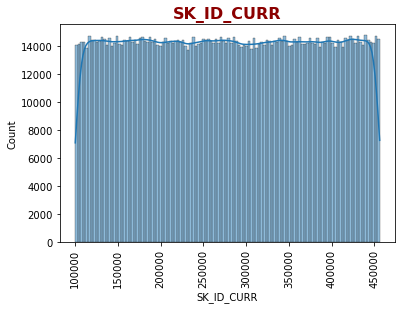

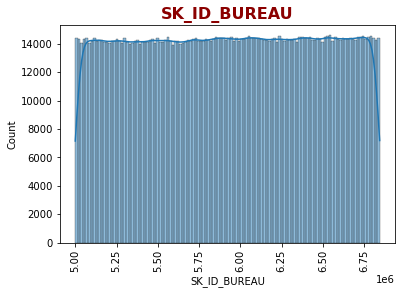

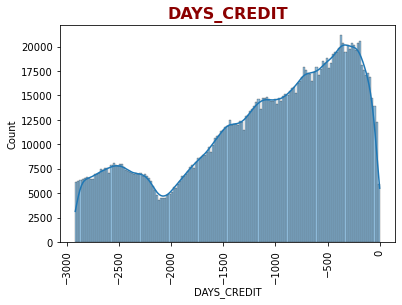

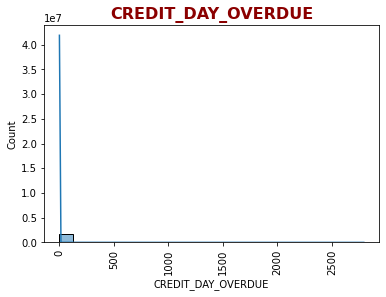

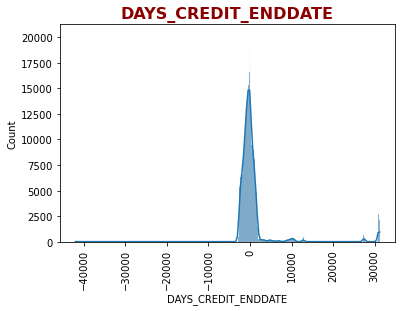

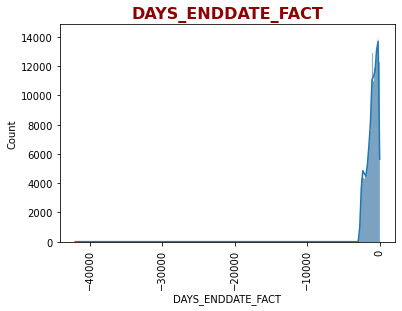

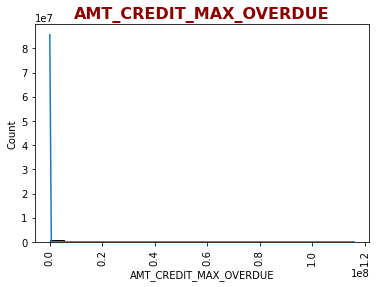

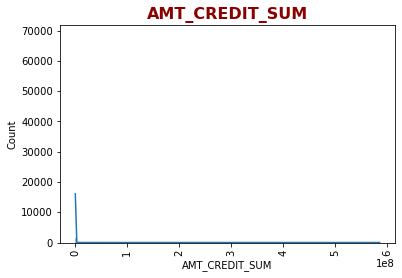

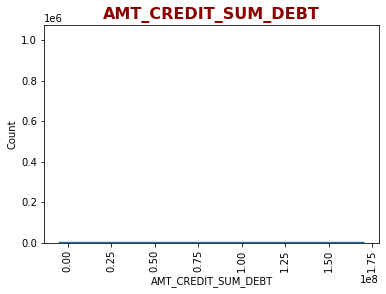

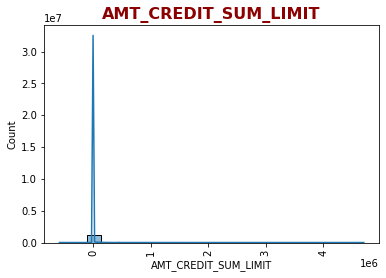

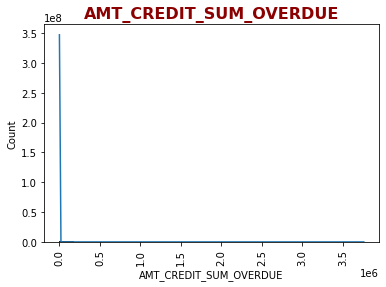

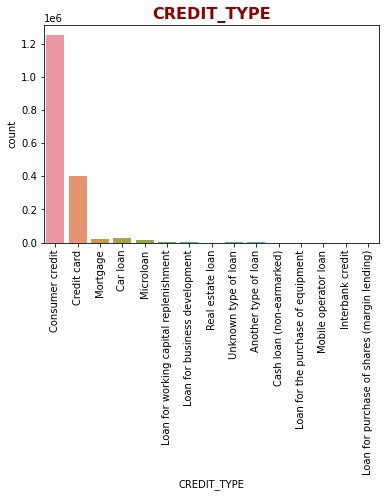

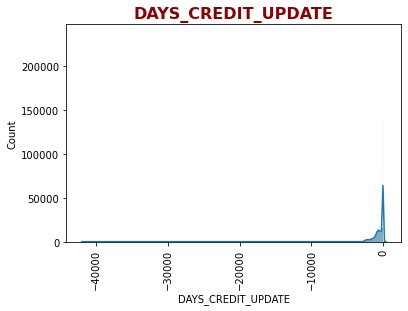

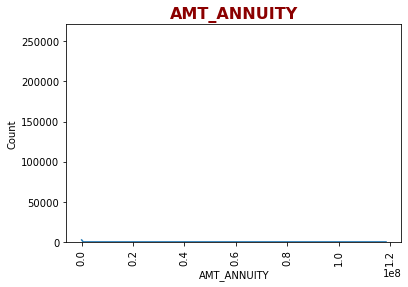

In [198]:
analyse_col_distr(bu)

**SUMMARY**

* **NaN**:
    * DAYS_CREDIT_ENDDATE = credit remaining time --> check if NaN for credit status = closed / sold ?? --> if yes, replace NaN by 0?
    * DAYS_ENDDATE_FACT = duration since credit was closed --> NaN for credit != closed? --> replacement by ????
    * AMT_CREDIT_MAX_OVERDUE = max amount overdue --> NaN for closed/sold credit?
    * AMT_CREDIT_SUM = current credit amount
    * AMT_CREDIT_SUM_DEBT = current debt
    * AMT_CREDIT_SUM_LIMIT = current credit limit of credit card
    * AMT_ANNUITY
    
* **Rare unique values**:
    * CREDIT_TYPE??
    * CNT_CREDIT_PROLONG ??

df shape = (27299925, 3)
nb of duplicates = 0
----------------------------------------
----------------------------------------
SK_ID_BUREAU  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 27299925
--------------------
continuous-like
----------------------------------------
----------------------------------------
MONTHS_BALANCE  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 27299925
--------------------
discrete-like
----------------------------------------
----------------------------------------
STATUS  -- dtype =  object
--------------------
Nb of Nan = 0 out of 27299925
--------------------
Nb unique values = 8
--- Valeurs uniques :
C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64
----------------------------------------------------------------------------------------------------
--------------------------------------------------------------------------------------

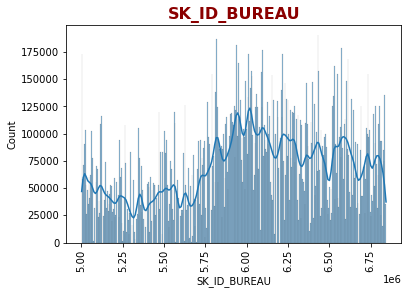

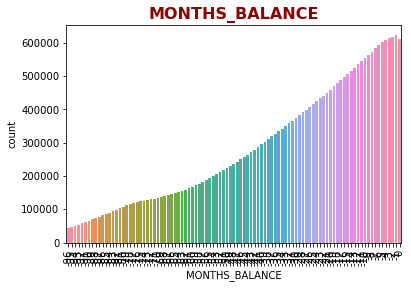

In [199]:
analyse_col_distr(bb)

### Bureau --> creating bu df from Bureau dataset

#### Checking NaN

In [294]:
# DAYS_CREDIT_ENDDATE
bu[bu['DAYS_CREDIT_ENDDATE'].isna()==True]['CREDIT_ACTIVE'].value_counts(dropna=False)

Active      72496
Closed      32430
Sold          626
Bad debt        1
Name: CREDIT_ACTIVE, dtype: int64

In [295]:
# DAYS_ENDDATE_FACT
bu[bu['DAYS_ENDDATE_FACT'].isna()==True]['CREDIT_ACTIVE'].value_counts(dropna=False)

Active      628638
Sold          4879
Closed         125
Bad debt        11
Name: CREDIT_ACTIVE, dtype: int64

In [235]:
# AMT_CREDIT_MAX_OVERDUE
bu[bu['AMT_CREDIT_MAX_OVERDUE'].isna()==True]['CREDIT_ACTIVE'].value_counts(dropna=False)

Closed      707301
Active      412174
Sold          5007
Bad debt         6
Name: CREDIT_ACTIVE, dtype: int64

In [234]:
# AMT_CREDIT_SUM
bu[bu['AMT_CREDIT_SUM'].isna()==True]

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE           CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  MONTHS_BALANCE_MIN  MONTHS_BALANCE_MAX  MONTHS_BALANCE_SIZE  Simplified_STATUS_0_MEAN  Simplified_STATUS_C_MEAN  Simplified_STATUS_DPD_MEAN  Simplified_STATUS_X_MEAN  \
218508       405791       6008179        Active      currency 1            0                   0                  NaN                NaN                     NaN                   0             NaN             654993.0                   NaN                     0.0  Another type of loan                  -5          NaN                 NaN                 NaN                  NaN                       NaN                       NaN                         NaN                       NaN   
314570       418331       6064357        Active      currency 1            0                   0                  NaN                NaN                     NaN                   0             NaN            2250000.0                   NaN                     0.0  Another type of loan                 -16          NaN                 NaN                 NaN                  NaN                       NaN                       NaN                         NaN                       NaN   
572703       367465       6299480        Active      currency 1            0                   0                388.0                NaN                     NaN                   0             NaN            1204582.5                   NaN                     0.0  Another type of loan                  -5          NaN                 NaN                 NaN                  NaN                       NaN                       NaN                         NaN                       NaN   
585311       371162       6452468        Closed      currency 1            0                   0                  NaN             -111.0                     NaN                   0             NaN                  0.0                   NaN                     0.0  Another type of loan                 -64          NaN                 0.0                 0.0                  1.0                       0.0                       1.0                         0.0                       0.0   
590328       209921       5491946        Closed      currency 1           -5                   0                  NaN              -46.0                     NaN                   0             NaN                  0.0                   NaN                     0.0  Another type of loan                 -36          NaN                 0.0                 0.0                  1.0                       0.0                       1.0                         0.0                       0.0   
814128       425959       6388671        Active      currency 1            0                   0                  NaN                NaN                     NaN                   0             NaN             185926.5                   NaN                     0.0  Another type of loan                  -3          NaN                 NaN                 NaN                  NaN                       NaN                       NaN                         NaN                       NaN   
987620       375588       5078559        Active      currency 1            0                   0                  NaN                NaN                     NaN                   0             NaN            1309572.0                   NaN                     0.0  Another type of loan                 -39          NaN                 NaN                 NaN                  NaN                       NaN                       NaN                         NaN                       NaN   
1055762      118044       6753699        Active      currency 1         -422                   0 

==> No relation found, NaN left as such -- will be dealt with just before modelling phase as NaN from Train_Data

#### Dealing with rare unique values
* **'CNT_CREDIT_PROLONG'**

In [236]:
bu['CNT_CREDIT_PROLONG'].value_counts(dropna=False)

0    1707314
1       7620
2       1222
3        191
4         54
5         21
9          2
6          2
8          1
7          1
Name: CNT_CREDIT_PROLONG, dtype: int64

In [414]:
# Not done as summed later
#prolong = [1,2,3,4,5,6,7,8,9]
#bu['CNT_CREDIT_PROLONG'].replace(prolong, 1, inplace= True)
#bu['CNT_CREDIT_PROLONG'].value_counts(dropna=False)

0    1707314
1       9114
Name: CNT_CREDIT_PROLONG, dtype: int64

* **CREDIT_TYPE**

In [239]:
bu['CREDIT_TYPE'].value_counts(dropna=False)

Consumer credit                                 1251615
Credit card                                      402195
Car loan                                          27690
Mortgage                                          18391
Microloan                                         12413
Loan for business development                      1975
Another type of loan                               1017
Unknown type of loan                                555
Loan for working capital replenishment              469
Cash loan (non-earmarked)                            56
Real estate loan                                     27
Loan for the purchase of equipment                   19
Loan for purchase of shares (margin lending)          4
Mobile operator loan                                  1
Interbank credit                                      1
Name: CREDIT_TYPE, dtype: int64

**==> to recheck after merge on train_data through a boxplot of credit type vs target**

#### Creating new features

In [342]:
bu

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE      CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY
0            215354       5714462        Closed      currency 1         -497                   0               -153.0             -153.0                     NaN                   0        91323.00                  0.0                   NaN                     0.0  Consumer credit                -131          NaN
1            215354       5714463        Active      currency 1         -208                   0               1075.0                NaN                     NaN                   0       225000.00             171342.0                   NaN                     0.0      Credit card                 -20          NaN
2            215354       5714464        Active      currency 1         -203                   0                528.0                NaN                     NaN                   0       464323.50                  NaN                   NaN                     0.0  Consumer credit                 -16          NaN
3            215354       5714465        Active      currency 1         -203                   0                  NaN                NaN                     NaN                   0        90000.00                  NaN                   NaN                     0.0      Credit card                 -16          NaN
4            215354       5714466        Active      currency 1         -629                   0               1197.0                NaN                 77674.5                   0      2700000.00                  NaN                   NaN                     0.0  Consumer credit                 -21          NaN
...             ...           ...           ...             ...          ...                 ...                  ...                ...                     ...                 ...             ...                  ...                   ...                     ...              ...                 ...          ...
1716423      259355       5057750        Active      currency 1          -44                   0                -30.0                NaN                     0.0                   0        11250.00              11250.0                   0.0                     0.0        Microloan                 -19          NaN
1716424      100044       5057754        Closed      currency 1        -2648                   0              -2433.0            -2493.0                  5476.5                   0        38130.84                  0.0                   0.0                     0.0  Consumer credit               -2493          NaN
1716425      100044       5057762        Closed      currency 1        -1809                   0              -1628.0             -970.0                     NaN                   0        15570.00                  NaN                   NaN                     0.0  Consumer credit                -967          NaN
1716426      246829       5057770        Closed      currency 1        -1878                   0              -1513.0            -1513.0                     NaN                   0        36000.00                  0.0                   0.0                     0.0  Consumer credit               -1508          NaN
1716427      246829       5057778        Closed      currency 1         -463                   0                  NaN             -387.0                     NaN                   0        22500.00                  0.0                   NaN                     0.0        Microloan                -387          NaN

[1716428 rows x 17 columns]

In [466]:
temp_bu = bu[['SK_ID_CURR', 'CREDIT_ACTIVE']]
print(temp_bu.shape)
temp_bu = pd.get_dummies(temp_bu)
print(temp_bu.shape)

(1716428, 2)
(1716428, 5)


In [467]:
temp_bu

SK_ID_CURR  CREDIT_ACTIVE_Active  CREDIT_ACTIVE_Bad debt  CREDIT_ACTIVE_Closed  CREDIT_ACTIVE_Sold
0            215354                     0                       0                     1                   0
1            215354                     1                       0                     0                   0
2            215354                     1                       0                     0                   0
3            215354                     1                       0                     0                   0
4            215354                     1                       0                     0                   0
...             ...                   ...                     ...                   ...                 ...
1716423      259355                     1                       0                     0                   0
1716424      100044                     0                       0                     1                   0
1716425      100044                     0                       0                     1                   0
1716426      246829                     0                       0                     1                   0
1716427      246829                     0                       0                     1                   0

[1716428 rows x 5 columns]

In [468]:
temp_bu = temp_bu.groupby('SK_ID_CURR').agg({'CREDIT_ACTIVE_Active':'sum','CREDIT_ACTIVE_Closed':'sum' })
temp_bu.columns = ['CREDIT_ACTIVE_Active_Count','CREDIT_ACTIVE_Closed_Count']
temp_bu

CREDIT_ACTIVE_Active_Count  CREDIT_ACTIVE_Closed_Count
SK_ID_CURR                                                        
100001                               3                           4
100002                               2                           6
100003                               1                           3
100004                               0                           2
100005                               2                           1
...                                ...                         ...
456249                               2                          11
456250                               2                           1
456253                               2                           2
456254                               0                           1
456255                               5                           6

[305811 rows x 2 columns]

In [469]:
temp_bu['CREDIT_ACTIVE_ActiveClosed_ratio'] = temp_bu['CREDIT_ACTIVE_Active_Count'] / (temp_bu['CREDIT_ACTIVE_Active_Count'] + temp_bu['CREDIT_ACTIVE_Closed_Count'])
temp_bu.head(0)

Empty DataFrame
Columns: [CREDIT_ACTIVE_Active_Count, CREDIT_ACTIVE_Closed_Count, CREDIT_ACTIVE_ActiveClosed_ratio]
Index: []

In [470]:
temp_bu[temp_bu.index == 215354]

CREDIT_ACTIVE_Active_Count  CREDIT_ACTIVE_Closed_Count  CREDIT_ACTIVE_ActiveClosed_ratio
SK_ID_CURR                                                                                          
215354                               6                           5                          0.545455

In [471]:
print(bu.shape)
bu = bu.merge(temp_bu, on=['SK_ID_CURR'], how='left')
print(bu.shape)

(1716428, 17)
(1716428, 20)


In [472]:
bu.head(5)

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE      CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  CREDIT_ACTIVE_Active_Count  CREDIT_ACTIVE_Closed_Count  CREDIT_ACTIVE_ActiveClosed_ratio
0      215354       5714462        Closed      currency 1         -497                   0               -153.0             -153.0                     NaN                   0         91323.0                  0.0                   NaN                     0.0  Consumer credit                -131          NaN                           6                           5                          0.545455
1      215354       5714463        Active      currency 1         -208                   0               1075.0                NaN                     NaN                   0        225000.0             171342.0                   NaN                     0.0      Credit card                 -20          NaN                           6                           5                          0.545455
2      215354       5714464        Active      currency 1         -203                   0                528.0                NaN                     NaN                   0        464323.5                  NaN                   NaN                     0.0  Consumer credit                 -16          NaN                           6                           5                          0.545455
3      215354       5714465        Active      currency 1         -203                   0                  NaN                NaN                     NaN                   0         90000.0                  NaN                   NaN                     0.0      Credit card                 -16          NaN                           6                           5                          0.545455
4      215354       5714466        Active      currency 1         -629                   0               1197.0                NaN                 77674.5                   0       2700000.0                  NaN                   NaN                     0.0  Consumer credit                 -21          NaN                           6                           5                          0.545455

In [473]:
bu[bu['SK_ID_CURR'] == 215354]

SK_ID_CURR  SK_ID_BUREAU CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE      CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  CREDIT_ACTIVE_Active_Count  CREDIT_ACTIVE_Closed_Count  CREDIT_ACTIVE_ActiveClosed_ratio
0           215354       5714462        Closed      currency 1         -497                   0               -153.0             -153.0                     NaN                   0         91323.0                 0.00                   NaN                     0.0  Consumer credit                -131          NaN                           6                           5                          0.545455
1           215354       5714463        Active      currency 1         -208                   0               1075.0                NaN                     NaN                   0        225000.0            171342.00                   NaN                     0.0      Credit card                 -20          NaN                           6                           5                          0.545455
2           215354       5714464        Active      currency 1         -203                   0                528.0                NaN                     NaN                   0        464323.5                  NaN                   NaN                     0.0  Consumer credit                 -16          NaN                           6                           5                          0.545455
3           215354       5714465        Active      currency 1         -203                   0                  NaN                NaN                     NaN                   0         90000.0                  NaN                   NaN                     0.0      Credit card                 -16          NaN                           6                           5                          0.545455
4           215354       5714466        Active      currency 1         -629                   0               1197.0                NaN                 77674.5                   0       2700000.0                  NaN                   NaN                     0.0  Consumer credit                 -21          NaN                           6                           5                          0.545455
5           215354       5714467        Active      currency 1         -273                   0              27460.0                NaN                     0.0                   0        180000.0             71017.38             108982.62                     0.0      Credit card                 -31          NaN                           6                           5                          0.545455
6           215354       5714468        Active      currency 1          -43                   0                 79.0                NaN                     0.0                   0         42103.8             42103.80                  0.00                     0.0  Consumer credit                 -22          NaN                           6                           5                          0.545455
225157      215354       5714458        Closed      currency 1        -1872                   0               -776.0            -1203.0                     NaN                   0        494550.0                 0.00                  0.00                     0.0  Consumer credit                -696          NaN                           6                           5                          0.545455
225158      215354       5714459        Closed      currency 1        -1734                   0               -638.0            -1336.0                     NaN                   0       1084032.0                 0.00                   NaN                     0.0         Car loan               -1336          NaN                           6                           5             

#### encoding cat feat in bu

In [474]:
bu, bu_cat = one_hot_encoder(bu, nan_as_category=True)

In [424]:
check_encoded_cat_cols(bu, bu_cat)

nb of categorical columns created though OHE =  26
--------------------
['CREDIT_ACTIVE_Active', 'CREDIT_ACTIVE_Bad debt', 'CREDIT_ACTIVE_Closed', 'CREDIT_ACTIVE_Sold', 'CREDIT_ACTIVE_nan', 'CREDIT_CURRENCY_currency 1', 'CREDIT_CURRENCY_currency 2', 'CREDIT_CURRENCY_currency 3', 'CREDIT_CURRENCY_currency 4', 'CREDIT_CURRENCY_nan', 'CREDIT_TYPE_Another type of loan', 'CREDIT_TYPE_Car loan', 'CREDIT_TYPE_Cash loan (non-earmarked)', 'CREDIT_TYPE_Consumer credit', 'CREDIT_TYPE_Credit card', 'CREDIT_TYPE_Interbank credit', 'CREDIT_TYPE_Loan for business development', 'CREDIT_TYPE_Loan for purchase of shares (margin lending)', 'CREDIT_TYPE_Loan for the purchase of equipment', 'CREDIT_TYPE_Loan for working capital replenishment', 'CREDIT_TYPE_Microloan', 'CREDIT_TYPE_Mobile operator loan', 'CREDIT_TYPE_Mortgage', 'CREDIT_TYPE_Real estate loan', 'CREDIT_TYPE_Unknown type of loan', 'CREDIT_TYPE_nan']
-----------------------------------------------------------------------------------------------

In [425]:
bu.shape

(1716428, 43)

In [426]:
bu.head(5)

SK_ID_CURR  SK_ID_BUREAU  DAYS_CREDIT  CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  CREDIT_ACTIVE_Active_Count  CREDIT_ACTIVE_Closed_Count  CREDIT_ACTIVE_ActiveClosed_ratio  CREDIT_ACTIVE_Active  CREDIT_ACTIVE_Bad debt  CREDIT_ACTIVE_Closed  CREDIT_ACTIVE_Sold  CREDIT_ACTIVE_nan  CREDIT_CURRENCY_currency 1  \
0      215354       5714462         -497                   0               -153.0             -153.0                     NaN                   0         91323.0                  0.0                   NaN                     0.0                -131          NaN                           6                           5                          0.545455                     0                       0                     1                   0                  0                           1   
1      215354       5714463         -208                   0               1075.0                NaN                     NaN                   0        225000.0             171342.0                   NaN                     0.0                 -20          NaN                           6                           5                          0.545455                     1                       0                     0                   0                  0                           1   
2      215354       5714464         -203                   0                528.0                NaN                     NaN                   0        464323.5                  NaN                   NaN                     0.0                 -16          NaN                           6                           5                          0.545455                     1                       0                     0                   0                  0                           1   
3      215354       5714465         -203                   0                  NaN                NaN                     NaN                   0         90000.0                  NaN                   NaN                     0.0                 -16          NaN                           6                           5                          0.545455                     1                       0                     0                   0                  0                           1   
4      215354       5714466         -629                   0               1197.0                NaN                 77674.5                   0       2700000.0                  NaN                   NaN                     0.0                 -21          NaN                           6                           5                          0.545455                     1                       0                     0                   0                  0                           1   

   CREDIT_CURRENCY_currency 2  CREDIT_CURRENCY_currency 3  CREDIT_CURRENCY_currency 4  CREDIT_CURRENCY_nan  CREDIT_TYPE_Another type of loan  CREDIT_TYPE_Car loan  CREDIT_TYPE_Cash loan (non-earmarked)  CREDIT_TYPE_Consumer credit  CREDIT_TYPE_Credit card  CREDIT_TYPE_Interbank credit  CREDIT_TYPE_Loan for business development  CREDIT_TYPE_Loan for purchase of shares (margin lending)  CREDIT_TYPE_Loan for the purchase of equipment  CREDIT_TYPE_Loan for working capital replenishment  \
0                           0                           0                           0                    0                                 0                     0                                      0                            1                        0                             0                                          0                                                  0                                                      0                                                  0    
1                           0                           0                           0   

In [427]:
bu[bu['SK_ID_CURR'] == 215354]

SK_ID_CURR  SK_ID_BUREAU  DAYS_CREDIT  CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  CREDIT_ACTIVE_Active_Count  CREDIT_ACTIVE_Closed_Count  CREDIT_ACTIVE_ActiveClosed_ratio  CREDIT_ACTIVE_Active  CREDIT_ACTIVE_Bad debt  CREDIT_ACTIVE_Closed  CREDIT_ACTIVE_Sold  CREDIT_ACTIVE_nan  CREDIT_CURRENCY_currency 1  \
0           215354       5714462         -497                   0               -153.0             -153.0                     NaN                   0         91323.0                 0.00                   NaN                     0.0                -131          NaN                           6                           5                          0.545455                     0                       0                     1                   0                  0                           1   
1           215354       5714463         -208                   0               1075.0                NaN                     NaN                   0        225000.0            171342.00                   NaN                     0.0                 -20          NaN                           6                           5                          0.545455                     1                       0                     0                   0                  0                           1   
2           215354       5714464         -203                   0                528.0                NaN                     NaN                   0        464323.5                  NaN                   NaN                     0.0                 -16          NaN                           6                           5                          0.545455                     1                       0                     0                   0                  0                           1   
3           215354       5714465         -203                   0                  NaN                NaN                     NaN                   0         90000.0                  NaN                   NaN                     0.0                 -16          NaN                           6                           5                          0.545455                     1                       0                     0                   0                  0                           1   
4           215354       5714466         -629                   0               1197.0                NaN                 77674.5                   0       2700000.0                  NaN                   NaN                     0.0                 -21          NaN                           6                           5                          0.545455                     1                       0                     0                   0                  0                           1   
5           215354       5714467         -273                   0              27460.0                NaN                     0.0                   0        180000.0             71017.38             108982.62                     0.0                 -31          NaN                           6                           5                          0.545455                     1                       0                     0                   0                  0                           1   
6           215354       5714468          -43                   0                 79.0                NaN                     0.0                   0         42103.8             42103.80                  0.00                     0.0                 -22          NaN                           6                           5                          0.545455                     1                       0                     0                   0                  0                           1   
225157      215354       5714458        -1872           

In [475]:
del temp_bu
gc.collect()

1453

### Bureau balance --> getting data from Bureau_Balance dataset and merging these data on bu df
#### Dealing with rare unique values of STATUS
C means closed, X means status unknown, 0 means no DPD, ['1','2','3','4','5'] means DPD or sold or written off

In [476]:
Status_DPD = ['1','2','3','4','5']
bb['Simplified_STATUS'] = np.where(bb['STATUS'].isin(Status_DPD), 'DPD', bb['STATUS'])
# check
bb['Simplified_STATUS'].value_counts(dropna=False)

C      13646993
0       7499507
X       5810482
DPD      342943
Name: Simplified_STATUS, dtype: int64

In [430]:
bb.shape

(27299925, 4)

In [477]:
bb.drop('STATUS', inplace=True, axis = 1)
bb.shape

(27299925, 3)

#### Encoding cat

In [478]:
bb, bb_cat = one_hot_encoder(bb, nan_as_category=True)

In [479]:
bb.columns

Index(['SK_ID_BUREAU', 'MONTHS_BALANCE', 'Simplified_STATUS_0', 'Simplified_STATUS_C', 'Simplified_STATUS_DPD', 'Simplified_STATUS_X', 'Simplified_STATUS_nan'], dtype='object')

In [434]:
check_encoded_cat_cols(bb, bb_cat)

nb of categorical columns created though OHE =  5
--------------------
['Simplified_STATUS_0', 'Simplified_STATUS_C', 'Simplified_STATUS_DPD', 'Simplified_STATUS_X', 'Simplified_STATUS_nan']
----------------------------------------------------------------------------------------------------
Simplified_STATUS_0
Nb of Nan = 0 out of 27299925
Nb of unique values = 2
--------------------
Simplified_STATUS_C
Nb of Nan = 0 out of 27299925
Nb of unique values = 2
--------------------
Simplified_STATUS_DPD
Nb of Nan = 0 out of 27299925
Nb of unique values = 2
--------------------
Simplified_STATUS_X
Nb of Nan = 0 out of 27299925
Nb of unique values = 2
--------------------
Simplified_STATUS_nan
Nb of Nan = 0 out of 27299925
Nb of unique values = 1
--------------------
----------------------------------------------------------------------------------------------------
nb of cat_cols with NaN = 0
No OHE issue!!


#### Aggregations and merge on bu

In [480]:
# Define aggregations
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
for col in bb_cat:
    bb_aggregations[col] = ['mean']

bb_aggregations

{'MONTHS_BALANCE': ['min', 'max', 'size'],
 'Simplified_STATUS_0': ['mean'],
 'Simplified_STATUS_C': ['mean'],
 'Simplified_STATUS_DPD': ['mean'],
 'Simplified_STATUS_X': ['mean'],
 'Simplified_STATUS_nan': ['mean']}

In [481]:
# perform them
bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)

In [482]:
bb_agg

MONTHS_BALANCE          Simplified_STATUS_0 Simplified_STATUS_C Simplified_STATUS_DPD Simplified_STATUS_X Simplified_STATUS_nan
                        min max size                mean                mean                  mean                mean                  mean
SK_ID_BUREAU                                                                                                                                
5001709                 -96   0   97            0.000000            0.886598              0.000000            0.113402                     0
5001710                 -82   0   83            0.060241            0.578313              0.000000            0.361446                     0
5001711                  -3   0    4            0.750000            0.000000              0.000000            0.250000                     0
5001712                 -18   0   19            0.526316            0.473684              0.000000            0.000000                     0
5001713                 -21   0   22            0.000000            0.000000              0.000000            1.000000                     0
...                     ...  ..  ...                 ...                 ...                   ...                 ...                   ...
6842884                 -47   0   48            0.187500            0.416667              0.000000            0.395833                     0
6842885                 -23   0   24            0.500000            0.000000              0.500000            0.000000                     0
6842886                 -32   0   33            0.242424            0.757576              0.000000            0.000000                     0
6842887                 -36   0   37            0.162162            0.837838              0.000000            0.000000                     0
6842888                 -61   0   62            0.145161            0.838710              0.016129            0.000000                     0

[817395 rows x 8 columns]

In [483]:
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
bb_agg

MONTHS_BALANCE_MIN  MONTHS_BALANCE_MAX  MONTHS_BALANCE_SIZE  Simplified_STATUS_0_MEAN  Simplified_STATUS_C_MEAN  Simplified_STATUS_DPD_MEAN  Simplified_STATUS_X_MEAN  Simplified_STATUS_nan_MEAN
SK_ID_BUREAU                                                                                                                                                                                                   
5001709                      -96                   0                   97                  0.000000                  0.886598                    0.000000                  0.113402                           0
5001710                      -82                   0                   83                  0.060241                  0.578313                    0.000000                  0.361446                           0
5001711                       -3                   0                    4                  0.750000                  0.000000                    0.000000                  0.250000                           0
5001712                      -18                   0                   19                  0.526316                  0.473684                    0.000000                  0.000000                           0
5001713                      -21                   0                   22                  0.000000                  0.000000                    0.000000                  1.000000                           0
...                          ...                 ...                  ...                       ...                       ...                         ...                       ...                         ...
6842884                      -47                   0                   48                  0.187500                  0.416667                    0.000000                  0.395833                           0
6842885                      -23                   0                   24                  0.500000                  0.000000                    0.500000                  0.000000                           0
6842886                      -32                   0                   33                  0.242424                  0.757576                    0.000000                  0.000000                           0
6842887                      -36                   0                   37                  0.162162                  0.837838                    0.000000                  0.000000                           0
6842888                      -61                   0                   62                  0.145161                  0.838710                    0.016129                  0.000000                           0

[817395 rows x 8 columns]

In [484]:
bb_agg.shape

(817395, 8)

In [485]:
for col in bb_agg.columns:
    print(col, ' -- ', bb_agg[col].isna().sum())

MONTHS_BALANCE_MIN  --  0
MONTHS_BALANCE_MAX  --  0
MONTHS_BALANCE_SIZE  --  0
Simplified_STATUS_0_MEAN  --  0
Simplified_STATUS_C_MEAN  --  0
Simplified_STATUS_DPD_MEAN  --  0
Simplified_STATUS_X_MEAN  --  0
Simplified_STATUS_nan_MEAN  --  0


In [486]:
# merge on bu
print(bu.shape)
bu = bu.join(bb_agg, how='left', on='SK_ID_BUREAU')
print(bu.shape)

(1716428, 43)
(1716428, 51)


In [487]:
bu.head(5)

SK_ID_CURR  SK_ID_BUREAU  DAYS_CREDIT  CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  CREDIT_ACTIVE_Active_Count  CREDIT_ACTIVE_Closed_Count  CREDIT_ACTIVE_ActiveClosed_ratio  CREDIT_ACTIVE_Active  CREDIT_ACTIVE_Bad debt  CREDIT_ACTIVE_Closed  CREDIT_ACTIVE_Sold  CREDIT_ACTIVE_nan  CREDIT_CURRENCY_currency 1  \
0      215354       5714462         -497                   0               -153.0             -153.0                     NaN                   0         91323.0                  0.0                   NaN                     0.0                -131          NaN                           6                           5                          0.545455                     0                       0                     1                   0                  0                           1   
1      215354       5714463         -208                   0               1075.0                NaN                     NaN                   0        225000.0             171342.0                   NaN                     0.0                 -20          NaN                           6                           5                          0.545455                     1                       0                     0                   0                  0                           1   
2      215354       5714464         -203                   0                528.0                NaN                     NaN                   0        464323.5                  NaN                   NaN                     0.0                 -16          NaN                           6                           5                          0.545455                     1                       0                     0                   0                  0                           1   
3      215354       5714465         -203                   0                  NaN                NaN                     NaN                   0         90000.0                  NaN                   NaN                     0.0                 -16          NaN                           6                           5                          0.545455                     1                       0                     0                   0                  0                           1   
4      215354       5714466         -629                   0               1197.0                NaN                 77674.5                   0       2700000.0                  NaN                   NaN                     0.0                 -21          NaN                           6                           5                          0.545455                     1                       0                     0                   0                  0                           1   

   CREDIT_CURRENCY_currency 2  CREDIT_CURRENCY_currency 3  CREDIT_CURRENCY_currency 4  CREDIT_CURRENCY_nan  CREDIT_TYPE_Another type of loan  CREDIT_TYPE_Car loan  CREDIT_TYPE_Cash loan (non-earmarked)  CREDIT_TYPE_Consumer credit  CREDIT_TYPE_Credit card  CREDIT_TYPE_Interbank credit  CREDIT_TYPE_Loan for business development  CREDIT_TYPE_Loan for purchase of shares (margin lending)  CREDIT_TYPE_Loan for the purchase of equipment  CREDIT_TYPE_Loan for working capital replenishment  \
0                           0                           0                           0                    0                                 0                     0                                      0                            1                        0                             0                                          0                                                  0                                                      0                                                  0    
1                           0                           0                           0   

In [488]:
del bb, bb_agg
gc.collect()

140

### Bureau&BureauBalance = new bu df  --> creating bureau_agg, i.e. df with data of interest/preprocessed, by performing (further) aggregations on the new bu df (i.e. the df combining data from Bureau and data aggregated from Bureau_Balance)
#### Aggregations on full bu df (i.e. all rows)

In [489]:
    # numeric features and their aggregations
num_aggregations = {
    'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
    'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
    'DAYS_CREDIT_UPDATE': ['mean'],
    'CREDIT_DAY_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['mean'],
    'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean'],
    'CNT_CREDIT_PROLONG': ['sum'],
    'MONTHS_BALANCE_MIN': ['min'],
    'MONTHS_BALANCE_MAX': ['max'],
    'MONTHS_BALANCE_SIZE': ['mean', 'sum']
}

In [490]:
    # categorical features and their aggregations
cat_aggregations = {}
for cat in bu_cat: cat_aggregations[cat] = ['mean']
for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean'] #adding "_MEAN" as mean aggregation was performed after encoding when bb_cat was defined

In [491]:
bu_cat

['CREDIT_ACTIVE_Active',
 'CREDIT_ACTIVE_Bad debt',
 'CREDIT_ACTIVE_Closed',
 'CREDIT_ACTIVE_Sold',
 'CREDIT_ACTIVE_nan',
 'CREDIT_CURRENCY_currency 1',
 'CREDIT_CURRENCY_currency 2',
 'CREDIT_CURRENCY_currency 3',
 'CREDIT_CURRENCY_currency 4',
 'CREDIT_CURRENCY_nan',
 'CREDIT_TYPE_Another type of loan',
 'CREDIT_TYPE_Car loan',
 'CREDIT_TYPE_Cash loan (non-earmarked)',
 'CREDIT_TYPE_Consumer credit',
 'CREDIT_TYPE_Credit card',
 'CREDIT_TYPE_Interbank credit',
 'CREDIT_TYPE_Loan for business development',
 'CREDIT_TYPE_Loan for purchase of shares (margin lending)',
 'CREDIT_TYPE_Loan for the purchase of equipment',
 'CREDIT_TYPE_Loan for working capital replenishment',
 'CREDIT_TYPE_Microloan',
 'CREDIT_TYPE_Mobile operator loan',
 'CREDIT_TYPE_Mortgage',
 'CREDIT_TYPE_Real estate loan',
 'CREDIT_TYPE_Unknown type of loan',
 'CREDIT_TYPE_nan']

In [492]:
bb_cat

['Simplified_STATUS_0',
 'Simplified_STATUS_C',
 'Simplified_STATUS_DPD',
 'Simplified_STATUS_X',
 'Simplified_STATUS_nan']

In [493]:
cat_aggregations

{'CREDIT_ACTIVE_Active': ['mean'],
 'CREDIT_ACTIVE_Bad debt': ['mean'],
 'CREDIT_ACTIVE_Closed': ['mean'],
 'CREDIT_ACTIVE_Sold': ['mean'],
 'CREDIT_ACTIVE_nan': ['mean'],
 'CREDIT_CURRENCY_currency 1': ['mean'],
 'CREDIT_CURRENCY_currency 2': ['mean'],
 'CREDIT_CURRENCY_currency 3': ['mean'],
 'CREDIT_CURRENCY_currency 4': ['mean'],
 'CREDIT_CURRENCY_nan': ['mean'],
 'CREDIT_TYPE_Another type of loan': ['mean'],
 'CREDIT_TYPE_Car loan': ['mean'],
 'CREDIT_TYPE_Cash loan (non-earmarked)': ['mean'],
 'CREDIT_TYPE_Consumer credit': ['mean'],
 'CREDIT_TYPE_Credit card': ['mean'],
 'CREDIT_TYPE_Interbank credit': ['mean'],
 'CREDIT_TYPE_Loan for business development': ['mean'],
 'CREDIT_TYPE_Loan for purchase of shares (margin lending)': ['mean'],
 'CREDIT_TYPE_Loan for the purchase of equipment': ['mean'],
 'CREDIT_TYPE_Loan for working capital replenishment': ['mean'],
 'CREDIT_TYPE_Microloan': ['mean'],
 'CREDIT_TYPE_Mobile operator loan': ['mean'],
 'CREDIT_TYPE_Mortgage': ['mean'],
 '

In [494]:
bu.shape

(1716428, 51)

In [495]:
# perform those aggregations
bureau_agg = bu.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

In [496]:
bureau_agg

BURO_DAYS_CREDIT_MIN  BURO_DAYS_CREDIT_MAX  BURO_DAYS_CREDIT_MEAN  BURO_DAYS_CREDIT_VAR  BURO_DAYS_CREDIT_ENDDATE_MIN  BURO_DAYS_CREDIT_ENDDATE_MAX  BURO_DAYS_CREDIT_ENDDATE_MEAN  BURO_DAYS_CREDIT_UPDATE_MEAN  BURO_CREDIT_DAY_OVERDUE_MAX  BURO_CREDIT_DAY_OVERDUE_MEAN  BURO_AMT_CREDIT_MAX_OVERDUE_MEAN  BURO_AMT_CREDIT_SUM_MAX  BURO_AMT_CREDIT_SUM_MEAN  BURO_AMT_CREDIT_SUM_SUM  BURO_AMT_CREDIT_SUM_DEBT_MAX  BURO_AMT_CREDIT_SUM_DEBT_MEAN  BURO_AMT_CREDIT_SUM_DEBT_SUM  \
SK_ID_CURR                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
100001                     -1572                   -49            -735.000000         240043.666667                       -1329.0                        1778.0                      82.428571                    -93.142857                            0                           0.0                               NaN                378000.00              2.076236e+05              1453365.000                     373239.00                   85240.928571                    596686.500   
100002                     -1437                  -103            -874.000000         186150.000000                       -1072.0                         780.0                    -349.000000                   -499.875000                            0                           0.0                          1681.029                450000.00              1.081319e+05               865055.565                     245781.00                   49156.200000                    245781.000   
100003                     -2586                  -606           -1400.750000         827783.583333                       -2434.0                        1216.0                    -544.500000                   -816.000000                            0                           0.0                             0.000                810000.00              2.543501e+05              1017400.500                          0.00                       0.000000                         0.000   
100004                     -1326                  -408            -867.000000         421362.000000                        -595.0                        -382.0                    -488.500000                   -532.000000                            0                           0.0                             0.000                 94537.80              9.451890e+04               189037.800                          0.00                       0.000000                         0.000   
100005                      -373                   -62            -190.666667          26340.333333                        -128.0                        1324.0                     439.333333                    -54.333333                            0                           0.0                             0.000                568800.00              2.190420e+05               657126.000                     543087.00                  189469.500000                    568408.500   
...                          ...                   ...                    ...                   ...                           ...                           ...                            ...                           ...                          ...                           ...                               ...                      ...                       ...                      ...                           ...                            ...                           ...   
456249                     -2713                  -483           -1667.076923         407302.243590                       -2499.0           

#### Aggregations on numeric features for individuals with ACTIVE credits ONLY

In [497]:
bu.shape

(1716428, 51)

In [498]:
active = bu[bu['CREDIT_ACTIVE_Active'] == 1]
active.shape

(630607, 51)

In [499]:
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(['BURO_active_' + e[0] + "__" + e[1].lower() for e in active_agg.columns.tolist()])
active_agg

BURO_active_DAYS_CREDIT__min  BURO_active_DAYS_CREDIT__max  BURO_active_DAYS_CREDIT__mean  BURO_active_DAYS_CREDIT__var  BURO_active_DAYS_CREDIT_ENDDATE__min  BURO_active_DAYS_CREDIT_ENDDATE__max  BURO_active_DAYS_CREDIT_ENDDATE__mean  BURO_active_DAYS_CREDIT_UPDATE__mean  BURO_active_CREDIT_DAY_OVERDUE__max  BURO_active_CREDIT_DAY_OVERDUE__mean  BURO_active_AMT_CREDIT_MAX_OVERDUE__mean  BURO_active_AMT_CREDIT_SUM__max  BURO_active_AMT_CREDIT_SUM__mean  \
SK_ID_CURR                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
100001                              -559                           -49                    -309.333333                  6.511033e+04                                 411.0                                1778.0                            1030.333333                            -10.666667                                    0                                   0.0                                       NaN                        378000.00                      2.946750e+05   
100002                             -1042                          -103                    -572.500000                  4.408605e+05                                 780.0                                 780.0                             780.000000                            -15.500000                                    0                                   0.0                                   40.5000                        450000.00                      2.409943e+05   
100003                              -606                          -606                    -606.000000                           NaN                                1216.0                                1216.0                            1216.000000                            -43.000000                                    0                                   0.0                                    0.0000                        810000.00                      8.100000e+05   
100005                              -137                           -62                     -99.500000                  2.812500e+03                                 122.0                                1324.0                             723.000000                            -21.000000                                    0                                   0.0                                    0.0000                        568800.00                      2.993130e+05   
100008                               -78                           -78                     -78.000000                           NaN                                 471.0                                 471.0                             471.000000                            -16.000000                                    0                                   0.0                                    0.0000                        267606.00                      2.676060e+05   
...                                  ...                           ...                            ...                           ...                                   ...                                   ...                                    ...                                   ...                                  ...                                   ...                                       ...                              ...                               ...   
456247                              -712                          -309                    -453.666667                  5.029233e+04                                1517.0                               10617.0                            7

In [500]:
print(bureau_agg.shape)
print(bureau_agg.info(null_counts=True))
print('-' * 50)
bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
print(bureau_agg.shape)
print(bureau_agg.info(null_counts=True))

(305811, 58)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 305811 entries, 100001 to 456255
Data columns (total 58 columns):
 #   Column                                                              Non-Null Count   Dtype  
---  ------                                                              --------------   -----  
 0   BURO_DAYS_CREDIT_MIN                                                305811 non-null  int64  
 1   BURO_DAYS_CREDIT_MAX                                                305811 non-null  int64  
 2   BURO_DAYS_CREDIT_MEAN                                               305811 non-null  float64
 3   BURO_DAYS_CREDIT_VAR                                                264291 non-null  float64
 4   BURO_DAYS_CREDIT_ENDDATE_MIN                                        303226 non-null  float64
 5   BURO_DAYS_CREDIT_ENDDATE_MAX                                        303226 non-null  float64
 6   BURO_DAYS_CREDIT_ENDDATE_MEAN                                       303226 non-nul

In [501]:
del active, active_agg
gc.collect()

20

#### Aggregations on numeric features for individuals with CLOSED credits only

In [502]:
closed = bu[bu['CREDIT_ACTIVE_Closed'] == 1]
closed.shape

(1079273, 51)

In [503]:
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(['BURO_closed_' + e[0] + "__" + e[1].lower() for e in closed_agg.columns.tolist()])
closed_agg

BURO_closed_DAYS_CREDIT__min  BURO_closed_DAYS_CREDIT__max  BURO_closed_DAYS_CREDIT__mean  BURO_closed_DAYS_CREDIT__var  BURO_closed_DAYS_CREDIT_ENDDATE__min  BURO_closed_DAYS_CREDIT_ENDDATE__max  BURO_closed_DAYS_CREDIT_ENDDATE__mean  BURO_closed_DAYS_CREDIT_UPDATE__mean  BURO_closed_CREDIT_DAY_OVERDUE__max  BURO_closed_CREDIT_DAY_OVERDUE__mean  BURO_closed_AMT_CREDIT_MAX_OVERDUE__mean  BURO_closed_AMT_CREDIT_SUM__max  BURO_closed_AMT_CREDIT_SUM__mean  \
SK_ID_CURR                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
100001                             -1572                          -857                   -1054.250000                 119594.250000                               -1329.0                                -179.0                            -628.500000                           -155.000000                                    0                                   0.0                                       NaN                         279720.0                     142335.000000   
100002                             -1437                          -476                    -974.500000                 123956.700000                               -1072.0                                  85.0                            -574.800000                           -661.333333                                    0                                   0.0                                2091.16125                         135000.0                      63844.500000   
100003                             -2586                          -775                   -1665.666667                 820590.333333                               -2434.0                                -420.0                           -1131.333333                          -1073.666667                                    0                                   0.0                                   0.00000                         112500.0                      69133.500000   
100004                             -1326                          -408                    -867.000000                 421362.000000                                -595.0                                -382.0                            -488.500000                           -532.000000                                    0                                   0.0                                   0.00000                          94537.8                      94518.900000   
100005                              -373                          -373                    -373.000000                           NaN                                -128.0                                -128.0                            -128.000000                           -121.000000                                    0                                   0.0                                       NaN                          58500.0                      58500.000000   
...                                  ...                           ...                            ...                           ...                                   ...                                   ...                                    ...                                   ...                                  ...                                   ...                                       ...                              ...                               ...   
456249                             -2713                          -903                   -1688.818182                 258750.963636                               -2499.0                                -658.0                           -1

In [504]:
print(bureau_agg.shape)
print(bureau_agg.info(null_counts=True))
print('-' * 50)
bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
print(bureau_agg.shape)
print(bureau_agg.info(null_counts=True))

(305811, 85)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 305811 entries, 100001 to 456255
Data columns (total 85 columns):
 #   Column                                                              Non-Null Count   Dtype  
---  ------                                                              --------------   -----  
 0   BURO_DAYS_CREDIT_MIN                                                305811 non-null  int64  
 1   BURO_DAYS_CREDIT_MAX                                                305811 non-null  int64  
 2   BURO_DAYS_CREDIT_MEAN                                               305811 non-null  float64
 3   BURO_DAYS_CREDIT_VAR                                                264291 non-null  float64
 4   BURO_DAYS_CREDIT_ENDDATE_MIN                                        303226 non-null  float64
 5   BURO_DAYS_CREDIT_ENDDATE_MAX                                        303226 non-null  float64
 6   BURO_DAYS_CREDIT_ENDDATE_MEAN                                       303226 non-nul

In [505]:
bureau_agg.head(0)

Empty DataFrame
Columns: [BURO_DAYS_CREDIT_MIN, BURO_DAYS_CREDIT_MAX, BURO_DAYS_CREDIT_MEAN, BURO_DAYS_CREDIT_VAR, BURO_DAYS_CREDIT_ENDDATE_MIN, BURO_DAYS_CREDIT_ENDDATE_MAX, BURO_DAYS_CREDIT_ENDDATE_MEAN, BURO_DAYS_CREDIT_UPDATE_MEAN, BURO_CREDIT_DAY_OVERDUE_MAX, BURO_CREDIT_DAY_OVERDUE_MEAN, BURO_AMT_CREDIT_MAX_OVERDUE_MEAN, BURO_AMT_CREDIT_SUM_MAX, BURO_AMT_CREDIT_SUM_MEAN, BURO_AMT_CREDIT_SUM_SUM, BURO_AMT_CREDIT_SUM_DEBT_MAX, BURO_AMT_CREDIT_SUM_DEBT_MEAN, BURO_AMT_CREDIT_SUM_DEBT_SUM, BURO_AMT_CREDIT_SUM_OVERDUE_MEAN, BURO_AMT_CREDIT_SUM_LIMIT_MEAN, BURO_AMT_CREDIT_SUM_LIMIT_SUM, BURO_AMT_ANNUITY_MAX, BURO_AMT_ANNUITY_MEAN, BURO_CNT_CREDIT_PROLONG_SUM, BURO_MONTHS_BALANCE_MIN_MIN, BURO_MONTHS_BALANCE_MAX_MAX, BURO_MONTHS_BALANCE_SIZE_MEAN, BURO_MONTHS_BALANCE_SIZE_SUM, BURO_CREDIT_ACTIVE_Active_MEAN, BURO_CREDIT_ACTIVE_Bad debt_MEAN, BURO_CREDIT_ACTIVE_Closed_MEAN, BURO_CREDIT_ACTIVE_Sold_MEAN, BURO_CREDIT_ACTIVE_nan_MEAN, BURO_CREDIT_CURRENCY_currency 1_MEAN, BURO_CREDIT_CURRENCY_currency 2_MEAN, BURO_CREDIT_CURRENCY_currency 3_MEAN, BURO_CREDIT_CURRENCY_currency 4_MEAN, BURO_CREDIT_CURRENCY_nan_MEAN, BURO_CREDIT_TYPE_Another type of loan_MEAN, BURO_CREDIT_TYPE_Car loan_MEAN, BURO_CREDIT_TYPE_Cash loan (non-earmarked)_MEAN, BURO_CREDIT_TYPE_Consumer credit_MEAN, BURO_CREDIT_TYPE_Credit card_MEAN, BURO_CREDIT_TYPE_Interbank credit_MEAN, BURO_CREDIT_TYPE_Loan for business development_MEAN, BURO_CREDIT_TYPE_Loan for purchase of shares (margin lending)_MEAN, BURO_CREDIT_TYPE_Loan for the purchase of equipment_MEAN, BURO_CREDIT_TYPE_Loan for working capital replenishment_MEAN, BURO_CREDIT_TYPE_Microloan_MEAN, BURO_CREDIT_TYPE_Mobile operator loan_MEAN, BURO_CREDIT_TYPE_Mortgage_MEAN, BURO_CREDIT_TYPE_Real estate loan_MEAN, BURO_CREDIT_TYPE_Unknown type of loan_MEAN, BURO_CREDIT_TYPE_nan_MEAN, BURO_Simplified_STATUS_0_MEAN_MEAN, BURO_Simplified_STATUS_C_MEAN_MEAN, BURO_Simplified_STATUS_DPD_MEAN_MEAN, BURO_Simplified_STATUS_X_MEAN_MEAN, BURO_Simplified_STATUS_nan_MEAN_MEAN, BURO_active_DAYS_CREDIT__min, BURO_active_DAYS_CREDIT__max, BURO_active_DAYS_CREDIT__mean, BURO_active_DAYS_CREDIT__var, BURO_active_DAYS_CREDIT_ENDDATE__min, BURO_active_DAYS_CREDIT_ENDDATE__max, BURO_active_DAYS_CREDIT_ENDDATE__mean, BURO_active_DAYS_CREDIT_UPDATE__mean, BURO_active_CREDIT_DAY_OVERDUE__max, BURO_active_CREDIT_DAY_OVERDUE__mean, BURO_active_AMT_CREDIT_MAX_OVERDUE__mean, BURO_active_AMT_CREDIT_SUM__max, BURO_active_AMT_CREDIT_SUM__mean, BURO_active_AMT_CREDIT_SUM__sum, BURO_active_AMT_CREDIT_SUM_DEBT__max, BURO_active_AMT_CREDIT_SUM_DEBT__mean, BURO_active_AMT_CREDIT_SUM_DEBT__sum, BURO_active_AMT_CREDIT_SUM_OVERDUE__mean, BURO_active_AMT_CREDIT_SUM_LIMIT__mean, BURO_active_AMT_CREDIT_SUM_LIMIT__sum, BURO_active_AMT_ANNUITY__max, BURO_active_AMT_ANNUITY__mean, BURO_active_CNT_CREDIT_PROLONG__sum, BURO_active_MONTHS_BALANCE_MIN__min, BURO_active_MONTHS_BALANCE_MAX__max, BURO_active_MONTHS_BALANCE_SIZE__mean, BURO_active_MONTHS_BALANCE_SIZE__sum, BURO_closed_DAYS_CREDIT__min, BURO_closed_DAYS_CREDIT__max, BURO_closed_DAYS_CREDIT__mean, BURO_closed_DAYS_CREDIT__var, BURO_closed_DAYS_CREDIT_ENDDATE__min, BURO_closed_DAYS_CREDIT_ENDDATE__max, BURO_closed_DAYS_CREDIT_ENDDATE__mean, BURO_closed_DAYS_CREDIT_UPDATE__mean, BURO_closed_CREDIT_DAY_OVERDUE__max, BURO_closed_CREDIT_DAY_OVERDUE__mean, BURO_closed_AMT_CREDIT_MAX_OVERDUE__mean, BURO_closed_AMT_CREDIT_SUM__max, BURO_closed_AMT_CREDIT_SUM__mean, BURO_closed_AMT_CREDIT_SUM__sum, BURO_closed_AMT_CREDIT_SUM_DEBT__max, ...]
Index: []

In [506]:
del closed, closed_agg, bu
gc.collect()

40

In [508]:
bureau_agg.describe(include='all')

BURO_DAYS_CREDIT_MIN  BURO_DAYS_CREDIT_MAX  BURO_DAYS_CREDIT_MEAN  BURO_DAYS_CREDIT_VAR  BURO_DAYS_CREDIT_ENDDATE_MIN  BURO_DAYS_CREDIT_ENDDATE_MAX  BURO_DAYS_CREDIT_ENDDATE_MEAN  BURO_DAYS_CREDIT_UPDATE_MEAN  BURO_CREDIT_DAY_OVERDUE_MAX  BURO_CREDIT_DAY_OVERDUE_MEAN  BURO_AMT_CREDIT_MAX_OVERDUE_MEAN  BURO_AMT_CREDIT_SUM_MAX  BURO_AMT_CREDIT_SUM_MEAN  BURO_AMT_CREDIT_SUM_SUM  BURO_AMT_CREDIT_SUM_DEBT_MAX  BURO_AMT_CREDIT_SUM_DEBT_MEAN  BURO_AMT_CREDIT_SUM_DEBT_SUM  \
count         305811.000000         305811.000000          305811.000000          2.642910e+05                 303226.000000                 303226.000000                  303226.000000                 305811.000000                305811.000000                 305811.000000                      2.129710e+05             3.058090e+05              3.058090e+05             3.058110e+05                  2.974390e+05                   2.974390e+05                  3.058110e+05   
mean           -1764.362845           -490.942608           -1083.802103          4.856008e+05                  -1029.705151                   4508.643464                     662.420814                   -542.965748                     4.436629                      0.965926                      5.004934e+03             9.917572e+05              3.807398e+05             1.992466e+06                  5.300396e+05                   1.616341e+05                  6.539142e+05   
std              859.260807            533.529324             558.441124          4.627030e+05                   2621.100512                   9422.717152                    3282.359178                    446.427113                    85.573591                     24.957209                      2.856819e+05             2.317442e+06              8.792865e+05             4.165820e+06                  1.357630e+06                   5.367677e+05                  1.640691e+06   
min            -2922.000000          -2922.000000           -2922.000000          0.000000e+00                 -42060.000000                 -41875.000000                  -41875.000000                 -41890.000000                     0.000000                      0.000000                      0.000000e+00             0.000000e+00              0.000000e+00             0.000000e+00                 -2.595965e+04                  -1.083615e+06                 -6.981558e+06   
25%            -2583.000000           -623.000000           -1431.000000          1.257143e+05                  -2128.000000                    126.000000                    -697.525000                   -773.696154                     0.000000                      0.000000                      0.000000e+00             1.800000e+05              1.039616e+05             3.469676e+05                  0.000000e+00                   0.000000e+00                  0.000000e+00   
50%            -1822.000000           -305.000000           -1052.500000          3.803969e+05                  -1272.000000                    912.000000                    -131.788889                   -479.300000                     0.000000                      0.000000                      0.000000e+00             4.500000e+05              1.972972e+05             9.788207e+05                  1.526175e+05                   4.476038e+04                  1.733670e+05   
75%            -1045.000000           -149.000000            -670.369318          7.130844e+05                   -458.000000                   1692.000000                     613.000000                   -209.000000                     0.000000                      0.000000                      2.063745e+03             1.079100e+06              3.978647e+05             2.345121e+06                  5.059968e+05                   1.436004e+05                  6.765412e+05   
max                0.000000              0.000000               0.000000          4.173160e+06                  31198.000000                  31199.000000                   31

### Test of full and clean code for pre-processing Train Data
* **Full and clean code**

In [15]:
def bureau_and_balance(num_rows = None, nan_as_category = True):
    # Read data
    bu = pd.read_csv(path+'bureau.csv', nrows = num_rows)
    bb = pd.read_csv(path+'bureau_balance.csv', nrows = num_rows)
    print("bu shape: {}, bb shape: {}".format(bu.shape, bb.shape))
    
    # Bureau: 
        # dealing with rare unique values: CNT_CREDIT_PROLONG turned into a binary feature - not done as summed later
    #prolong = [1,2,3,4,5,6,7,8,9]
    #bu['CNT_CREDIT_PROLONG'].replace(prolong, 1, inplace= True)
        # creating new features through aggregations: Active and closed credit counts and ratio
    temp_bu = bu[['SK_ID_CURR', 'CREDIT_ACTIVE']]
    temp_bu = pd.get_dummies(temp_bu)
    temp_bu = temp_bu.groupby('SK_ID_CURR').agg({'CREDIT_ACTIVE_Active':'sum','CREDIT_ACTIVE_Closed':'sum' })
    temp_bu.columns = ['CREDIT_ACTIVE_Active__count','CREDIT_ACTIVE_Closed__count']
    temp_bu['CREDIT_ACTIVE_ActiveClosed_ratio'] = (temp_bu['CREDIT_ACTIVE_Active__count']
                                                   / (temp_bu['CREDIT_ACTIVE_Active__count']
                                                      + temp_bu['CREDIT_ACTIVE_Closed__count']))
    bu = bu.join(temp_bu, on=['SK_ID_CURR'], how='left')
    del temp_bu
    gc.collect()
        # encoding of categorical features
    bu, bu_cat = one_hot_encoder(bu, nan_as_category)

    # Bureau_Balance: 
        # simplifiying STATUS categories
    Status_DPD = ['1','2','3','4','5']
    bb['Simplified_STATUS'] = np.where(bb['STATUS'].isin(Status_DPD), 'DPD', bb['STATUS'])
    bb.drop('STATUS', inplace=True, axis = 1)
        # encoding categorical features
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
        # Perform aggregations and merge with bu
            # defining aggregations
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
            # perform them
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "__" + e[1].lower() for e in bb_agg.columns.tolist()])
            # merge with bu
    bu = bu.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bu.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau&Bureau_Balance_agg: creating new features through (further) aggregations
        # defining numeric features and their aggregations
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CREDIT_ACTIVE_Active__count': ['max'],
        'CREDIT_ACTIVE_Closed__count' : ['max'],
        'CREDIT_ACTIVE_ActiveClosed_ratio' : ['mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE__min': ['min'],
        'MONTHS_BALANCE__max': ['max'],
        'MONTHS_BALANCE__size': ['mean', 'sum']
    }
        # defining categorical features and their aggregations
    cat_aggregations = {}
    for cat in bu_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "__mean"] = ['mean']
        # performing all those aggregations on all individuals
    bureau_agg = bu.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "__" + e[1].lower() for e in bureau_agg.columns.tolist()])
        # performing aggregations on numeric features for individuals with ACTIVE credits
    active = bu[bu['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['BURO_active_' + e[0] + "__" + e[1].lower() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
        # performing aggregations on numeric features for individuals with CLOSED credits
    closed = bu[bu['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['BURO_closed_' + e[0] + "__" + e[1].lower() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bu
    gc.collect()
                                                   
    return bureau_agg

* **Testing it**

In [531]:
num_rows = 10000
bureau_agg = bureau_and_balance(num_rows)
bureau_agg.head(2)

bu shape: (10000, 17), bb shape: (10000, 3)


BURO_DAYS_CREDIT__min  BURO_DAYS_CREDIT__max  BURO_DAYS_CREDIT__mean  BURO_DAYS_CREDIT__var  BURO_DAYS_CREDIT_ENDDATE__min  BURO_DAYS_CREDIT_ENDDATE__max  BURO_DAYS_CREDIT_ENDDATE__mean  BURO_DAYS_CREDIT_UPDATE__mean  BURO_CREDIT_DAY_OVERDUE__max  BURO_CREDIT_DAY_OVERDUE__mean  BURO_AMT_CREDIT_MAX_OVERDUE__mean  BURO_AMT_CREDIT_SUM__max  BURO_AMT_CREDIT_SUM__mean  BURO_AMT_CREDIT_SUM__sum  BURO_AMT_CREDIT_SUM_DEBT__max  BURO_AMT_CREDIT_SUM_DEBT__mean  BURO_AMT_CREDIT_SUM_DEBT__sum  \
SK_ID_CURR                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
100053                      -2893                  -1764            -2287.714286          221585.238095                        -2534.0                         -648.0                    -1519.333333                   -1137.571429                             0                            0.0                                NaN                  225000.0               92655.642857                 648589.50                            0.0                        0.000000                            0.0   
100568                      -1274                   -207             -493.857143          136769.809524                         -969.0                         1183.0                      110.500000                    -244.857143                             0                            0.0                           8178.885                  333000.0              119269.877143                 834889.14                       293535.0                    60371.357143                       422599.5   

            BURO_AMT_CREDIT_SUM_OVERDUE__mean  BURO_AMT_CREDIT_SUM_LIMIT__mean  BURO_AMT_CREDIT_SUM_LIMIT__sum  BURO_AMT_ANNUITY__max  BURO_AMT_ANNUITY__mean  BURO_CREDIT_ACTIVE_Active__count__max  BURO_CREDIT_ACTIVE_Closed__count__max  BURO_CREDIT_ACTIVE_ActiveClosed_ratio__mean  BURO_CNT_CREDIT_PROLONG__sum  BURO_MONTHS_BALANCE__min__min  BURO_MONTHS_BALANCE__max__max  BURO_MONTHS_BALANCE__size__mean  BURO_MONTHS_BALANCE__size__sum  BURO_CREDIT_ACTIVE_Active__mean  \
SK_ID_CURR                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
100053                                    0.0                              0.0                             0.0                    NaN                     NaN                                      1                                      6                                     0.142857                             0                            NaN                            NaN                              NaN                             0.0                         0.142857   
100568                                    0.0                              0.0                             0.0                13500.0                5887.125                                      3                                      4                                     0.428571                             0                            NaN                            NaN                              NaN                             0.0                         0.428571   

            BURO_CREDIT_ACTIVE_Bad debt__mean  BURO_CREDIT_ACTIVE_Closed__mean  BURO_CREDIT_ACTIVE_Sold__mean 

In [16]:
num_rows = None
bureau_agg = bureau_and_balance(num_rows)
bureau_agg.head(0)

bu shape: (1716428, 17), bb shape: (27299925, 3)


Empty DataFrame
Columns: [BURO_DAYS_CREDIT__min, BURO_DAYS_CREDIT__max, BURO_DAYS_CREDIT__mean, BURO_DAYS_CREDIT__var, BURO_DAYS_CREDIT_ENDDATE__min, BURO_DAYS_CREDIT_ENDDATE__max, BURO_DAYS_CREDIT_ENDDATE__mean, BURO_DAYS_CREDIT_UPDATE__mean, BURO_CREDIT_DAY_OVERDUE__max, BURO_CREDIT_DAY_OVERDUE__mean, BURO_AMT_CREDIT_MAX_OVERDUE__mean, BURO_AMT_CREDIT_SUM__max, BURO_AMT_CREDIT_SUM__mean, BURO_AMT_CREDIT_SUM__sum, BURO_AMT_CREDIT_SUM_DEBT__max, BURO_AMT_CREDIT_SUM_DEBT__mean, BURO_AMT_CREDIT_SUM_DEBT__sum, BURO_AMT_CREDIT_SUM_OVERDUE__mean, BURO_AMT_CREDIT_SUM_LIMIT__mean, BURO_AMT_CREDIT_SUM_LIMIT__sum, BURO_AMT_ANNUITY__max, BURO_AMT_ANNUITY__mean, BURO_CREDIT_ACTIVE_Active__count__max, BURO_CREDIT_ACTIVE_Closed__count__max, BURO_CREDIT_ACTIVE_ActiveClosed_ratio__mean, BURO_CNT_CREDIT_PROLONG__sum, BURO_MONTHS_BALANCE__min__min, BURO_MONTHS_BALANCE__max__max, BURO_MONTHS_BALANCE__size__mean, BURO_MONTHS_BALANCE__size__sum, BURO_CREDIT_ACTIVE_Active__mean, BURO_CREDIT_ACTIVE_Bad debt__mean, BURO_CREDIT_ACTIVE_Closed__mean, BURO_CREDIT_ACTIVE_Sold__mean, BURO_CREDIT_ACTIVE_nan__mean, BURO_CREDIT_CURRENCY_currency 1__mean, BURO_CREDIT_CURRENCY_currency 2__mean, BURO_CREDIT_CURRENCY_currency 3__mean, BURO_CREDIT_CURRENCY_currency 4__mean, BURO_CREDIT_CURRENCY_nan__mean, BURO_CREDIT_TYPE_Another type of loan__mean, BURO_CREDIT_TYPE_Car loan__mean, BURO_CREDIT_TYPE_Cash loan (non-earmarked)__mean, BURO_CREDIT_TYPE_Consumer credit__mean, BURO_CREDIT_TYPE_Credit card__mean, BURO_CREDIT_TYPE_Interbank credit__mean, BURO_CREDIT_TYPE_Loan for business development__mean, BURO_CREDIT_TYPE_Loan for purchase of shares (margin lending)__mean, BURO_CREDIT_TYPE_Loan for the purchase of equipment__mean, BURO_CREDIT_TYPE_Loan for working capital replenishment__mean, BURO_CREDIT_TYPE_Microloan__mean, BURO_CREDIT_TYPE_Mobile operator loan__mean, BURO_CREDIT_TYPE_Mortgage__mean, BURO_CREDIT_TYPE_Real estate loan__mean, BURO_CREDIT_TYPE_Unknown type of loan__mean, BURO_CREDIT_TYPE_nan__mean, BURO_Simplified_STATUS_0__mean__mean, BURO_Simplified_STATUS_C__mean__mean, BURO_Simplified_STATUS_DPD__mean__mean, BURO_Simplified_STATUS_X__mean__mean, BURO_Simplified_STATUS_nan__mean__mean, BURO_active_DAYS_CREDIT__min, BURO_active_DAYS_CREDIT__max, BURO_active_DAYS_CREDIT__mean, BURO_active_DAYS_CREDIT__var, BURO_active_DAYS_CREDIT_ENDDATE__min, BURO_active_DAYS_CREDIT_ENDDATE__max, BURO_active_DAYS_CREDIT_ENDDATE__mean, BURO_active_DAYS_CREDIT_UPDATE__mean, BURO_active_CREDIT_DAY_OVERDUE__max, BURO_active_CREDIT_DAY_OVERDUE__mean, BURO_active_AMT_CREDIT_MAX_OVERDUE__mean, BURO_active_AMT_CREDIT_SUM__max, BURO_active_AMT_CREDIT_SUM__mean, BURO_active_AMT_CREDIT_SUM__sum, BURO_active_AMT_CREDIT_SUM_DEBT__max, BURO_active_AMT_CREDIT_SUM_DEBT__mean, BURO_active_AMT_CREDIT_SUM_DEBT__sum, BURO_active_AMT_CREDIT_SUM_OVERDUE__mean, BURO_active_AMT_CREDIT_SUM_LIMIT__mean, BURO_active_AMT_CREDIT_SUM_LIMIT__sum, BURO_active_AMT_ANNUITY__max, BURO_active_AMT_ANNUITY__mean, BURO_active_CREDIT_ACTIVE_Active__count__max, BURO_active_CREDIT_ACTIVE_Closed__count__max, BURO_active_CREDIT_ACTIVE_ActiveClosed_ratio__mean, BURO_active_CNT_CREDIT_PROLONG__sum, BURO_active_MONTHS_BALANCE__min__min, BURO_active_MONTHS_BALANCE__max__max, BURO_active_MONTHS_BALANCE__size__mean, BURO_active_MONTHS_BALANCE__size__sum, BURO_closed_DAYS_CREDIT__min, BURO_closed_DAYS_CREDIT__max, BURO_closed_DAYS_CREDIT__mean, BURO_closed_DAYS_CREDIT__var, BURO_closed_DAYS_CREDIT_ENDDATE__min, BURO_closed_DAYS_CREDIT_ENDDATE__max, BURO_closed_DAYS_CREDIT_ENDDATE__mean, BURO_closed_DAYS_CREDIT_UPDATE__mean, BURO_closed_CREDIT_DAY_OVERDUE__max, ...]
Index: []

In [534]:
bureau_agg[bureau_agg.index == 215354]

BURO_DAYS_CREDIT__min  BURO_DAYS_CREDIT__max  BURO_DAYS_CREDIT__mean  BURO_DAYS_CREDIT__var  BURO_DAYS_CREDIT_ENDDATE__min  BURO_DAYS_CREDIT_ENDDATE__max  BURO_DAYS_CREDIT_ENDDATE__mean  BURO_DAYS_CREDIT_UPDATE__mean  BURO_CREDIT_DAY_OVERDUE__max  BURO_CREDIT_DAY_OVERDUE__mean  BURO_AMT_CREDIT_MAX_OVERDUE__mean  BURO_AMT_CREDIT_SUM__max  BURO_AMT_CREDIT_SUM__mean  BURO_AMT_CREDIT_SUM__sum  BURO_AMT_CREDIT_SUM_DEBT__max  BURO_AMT_CREDIT_SUM_DEBT__mean  BURO_AMT_CREDIT_SUM_DEBT__sum  \
SK_ID_CURR                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
215354                      -1872                    -43             -727.818182          432794.763636                        -1089.0                        27460.0                          2685.3                    -367.272727                             0                            0.0                            25891.5                 2700000.0              543085.936364                 5973945.3                       171342.0                        47410.53                      284463.18   

            BURO_AMT_CREDIT_SUM_OVERDUE__mean  BURO_AMT_CREDIT_SUM_LIMIT__mean  BURO_AMT_CREDIT_SUM_LIMIT__sum  BURO_AMT_ANNUITY__max  BURO_AMT_ANNUITY__mean  BURO_CREDIT_ACTIVE_Active__count__max  BURO_CREDIT_ACTIVE_Closed__count__max  BURO_CREDIT_ACTIVE_ActiveClosed_ratio__mean  BURO_CNT_CREDIT_PROLONG__sum  BURO_MONTHS_BALANCE__min__min  BURO_MONTHS_BALANCE__max__max  BURO_MONTHS_BALANCE__size__mean  BURO_MONTHS_BALANCE__size__sum  BURO_CREDIT_ACTIVE_Active__mean  \
SK_ID_CURR                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
215354                                    0.0                         36327.54                       108982.62                    NaN                     NaN                                      6                                      5                                     0.545455                             0                            NaN                            NaN                              NaN                             0.0                         0.545455   

            BURO_CREDIT_ACTIVE_Bad debt__mean  BURO_CREDIT_ACTIVE_Closed__mean  BURO_CREDIT_ACTIVE_Sold__mean  BURO_CREDIT_ACTIVE_nan__mean  BURO_CREDIT_CURRENCY_currency 1__mean  BURO_CREDIT_CURRENCY_currency 2__mean  BURO_CREDIT_CURRENCY_currency 3__mean  BURO_CREDIT_CURRENCY_currency 4__mean  BURO_CREDIT_CURRENCY_nan__mean  BURO_CREDIT_TYPE_Another type of loan__mean  BURO_CREDIT_TYPE_Car loan__mean  BURO_CREDIT_TYPE_Cash loan (non-earmarked)__mean  BURO_CREDIT_TYPE_Consumer credit__mean  \
SK_ID_CURR                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
215354                                    0.0                         0.454545         

In [231]:
simplified_analyse_col_distr(bureau_agg)

df shape = (305811, 121)
nb of duplicates = 369
----------------------------------------
----------------------------------------
BURO_DAYS_CREDIT__min  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 305811
--------------------
min = -2922
max = 0
mean = -1764.3628450251954
std = 859.2594020283323
nan_std = 859.2594020283224
Relative_nan_std = -48.70083296364428
----------------------------------------
----------------------------------------
BURO_DAYS_CREDIT__max  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 305811
--------------------
min = -2922
max = 0
mean = -490.9426083430616
std = 533.5284521355101
nan_std = 533.5284521355173
Relative_nan_std = -108.67430185703043
----------------------------------------
----------------------------------------
BURO_DAYS_CREDIT__mean  -- dtype =  float64
--------------------
Nb of Nan = 0 out of 305811
--------------------
min = -2922.0
max = 0.0
mean = -1083.8021025433227
std = 558.440211343937
nan_std = 558.44021134

----------------------------------------
----------------------------------------
BURO_CREDIT_CURRENCY_currency 3__mean  -- dtype =  float64
--------------------
Nb of Nan = 0 out of 305811
--------------------
min = 0.0
max = 1.0
mean = 7.362290536103189e-05
std = 0.004219327071847359
nan_std = 0.004219327071832669
Relative_nan_std = 5730.99778002775
----------------------------------------
----------------------------------------
BURO_CREDIT_CURRENCY_currency 4__mean  -- dtype =  float64
--------------------
Nb of Nan = 0 out of 305811
--------------------
min = 0.0
max = 0.5
mean = 6.272796084150155e-06
std = 0.0013010123794835835
nan_std = 0.0013010123794840842
Relative_nan_std = 20740.54954171759
----------------------------------------
----------------------------------------
BURO_CREDIT_CURRENCY_nan__mean  -- dtype =  uint8
--------------------
Nb of Nan = 0 out of 305811
--------------------
----------------------------------------
----------------------------------------
BURO_

<ipython-input-18-321155b91850>:107: RuntimeWarning: invalid value encountered in double_scalars
  print('Relative_nan_std =', (np.nanstd(df[col])*100)/np.mean(df[col]))


Relative_nan_std = -222.64463475304552
----------------------------------------
----------------------------------------
BURO_active_CREDIT_DAY_OVERDUE__max  -- dtype =  float64
--------------------
Nb of Nan = 53996 out of 305811
--------------------
min = 0.0
max = 2770.0
mean = 4.374493179516708
std = 83.63450858019111
nan_std = 83.63450858009577
Relative_nan_std = 1911.867390071818
----------------------------------------
----------------------------------------
BURO_active_CREDIT_DAY_OVERDUE__mean  -- dtype =  float64
--------------------
Nb of Nan = 53996 out of 305811
--------------------
min = 0.0
max = 2770.0
mean = 1.9029821596958132
std = 43.31650205042281
nan_std = 43.31650205034829
Relative_nan_std = 2276.243202262722
----------------------------------------
----------------------------------------
BURO_active_AMT_CREDIT_MAX_OVERDUE__mean  -- dtype =  float64
--------------------
Nb of Nan = 172811 out of 305811
--------------------
min = 0.0
max = 1665490.5
mean = 2615.37

----------------------------------------
----------------------------------------
BURO_closed_AMT_CREDIT_SUM__sum  -- dtype =  float64
--------------------
Nb of Nan = 37886 out of 305811
--------------------
min = 0.0
max = 1017597917.385
mean = 993703.0474799692
std = 3256189.444203937
nan_std = 3256189.4442039384
Relative_nan_std = 327.68234458590365
----------------------------------------
----------------------------------------
BURO_closed_AMT_CREDIT_SUM_DEBT__max  -- dtype =  float64
--------------------
Nb of Nan = 51475 out of 305811
--------------------
min = -5010.39
max = 51750000.0
mean = 9767.18965174021
std = 166808.2450616423
nan_std = 166808.24506124738
Relative_nan_std = 1707.8427982764454
----------------------------------------
----------------------------------------
BURO_closed_AMT_CREDIT_SUM_DEBT__mean  -- dtype =  float64
--------------------
Nb of Nan = 51475 out of 305811
--------------------
min = -33981.165
max = 51750000.0
mean = 3007.3729070009413
std = 11

## 'Previous_application' Data
### Loading data and detailed preview

In [55]:
num_rows=None
prev = pd.read_csv(path+'previous_application.csv', nrows = num_rows)

In [ ]:
#analyse_col_distr(prev) -- computer crashed

df shape = (1670214, 37)
nb of duplicates = 0
----------------------------------------
----------------------------------------
SK_ID_PREV  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 1670214
--------------------
continuous-like
----------------------------------------
----------------------------------------
SK_ID_CURR  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 1670214
--------------------
continuous-like
----------------------------------------
----------------------------------------
NAME_CONTRACT_TYPE  -- dtype =  object
--------------------
Nb of Nan = 0 out of 1670214
--------------------
Nb unique values = 4
--- Valeurs uniques :
Cash loans         747553
Consumer loans     729151
Revolving loans    193164
XNA                   346
Name: NAME_CONTRACT_TYPE, dtype: int64
----------------------------------------
----------------------------------------
AMT_ANNUITY  -- dtype =  float64
--------------------
Nb of Nan = 372235 out of 1670214
--------

In [19]:
simplified_analyse_col_distr(prev)

df shape = (1670214, 37)
nb of duplicates = 0
----------------------------------------
----------------------------------------
SK_ID_PREV  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 1670214
--------------------
min = 1000001
max = 2845382
mean = 1923089.1353305625
std = 532597.799255484
nan_std = 532597.799255476
Relative_nan_std = 27.6949096883087
----------------------------------------
----------------------------------------
SK_ID_CURR  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 1670214
--------------------
min = 100001
max = 456255
mean = 278357.1740986484
std = 102814.79306961563
nan_std = 102814.79306961625
Relative_nan_std = 36.9362828181246
----------------------------------------
----------------------------------------
NAME_CONTRACT_TYPE  -- dtype =  object
--------------------
Nb of Nan = 0 out of 1670214
--------------------
Nb unique values = 4
--- Valeurs uniques :
Cash loans         747553
Consumer loans     729151
Revolving loans    1

Nb unique values = 8
--- Valeurs uniques :
NaN                820405
Unaccompanied      508970
Family             213263
Spouse, partner     67069
Children            31566
Other_B             17624
Other_A              9077
Group of people      2240
Name: NAME_TYPE_SUITE, dtype: int64
----------------------------------------
----------------------------------------
NAME_CLIENT_TYPE  -- dtype =  object
--------------------
Nb of Nan = 0 out of 1670214
--------------------
Nb unique values = 4
--- Valeurs uniques :
Repeater     1231261
New           301363
Refreshed     135649
XNA             1941
Name: NAME_CLIENT_TYPE, dtype: int64
----------------------------------------
----------------------------------------
NAME_GOODS_CATEGORY  -- dtype =  object
--------------------
Nb of Nan = 0 out of 1670214
--------------------
Nb unique values = 28
--- Valeurs uniques :
XNA                         950809
Mobile                      224708
Consumer Electronics        121576
Computers        

### Exploring potentially weird NaN
other NaN: same strategy as mentioned before, i.e. NaN left as such and delt with before modelling phase
* **'AMT_CREDIT'**

In [12]:
prev[prev['AMT_CREDIT'].isna()==True]

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  DAYS_DECISION NAME_PAYMENT_TYPE CODE_REJECT_REASON NAME_TYPE_SUITE NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  CHANNEL_TYPE  \
1127152     2204450      438387    Revolving loans          0.0              0.0         NaN               NaN              NaN                     FRIDAY                       10                           Y                       1                NaN                    NaN                       NaN                    XAP             Approved           -608               XNA                XAP             NaN         Repeater                 XNA          Cards           walk-in  Country-wide   

         SELLERPLACE_AREA NAME_SELLER_INDUSTRY  CNT_PAYMENT NAME_YIELD_GROUP PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  DAYS_FIRST_DUE  DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  DAYS_TERMINATION  NFLAG_INSURED_ON_APPROVAL  
1127152                20         Connectivity          0.0              XNA         Card Street                 NaN             NaN                        NaN            NaN               NaN                        NaN

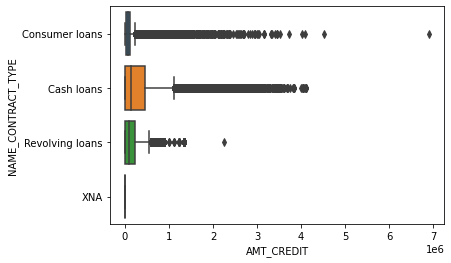

In [14]:
sns.boxplot(x='AMT_CREDIT', y='NAME_CONTRACT_TYPE', data=prev)

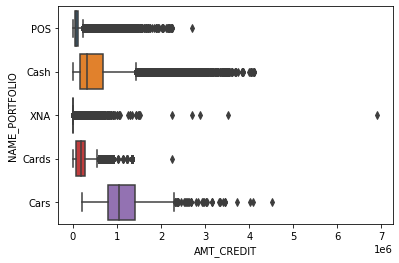

In [15]:
sns.boxplot(x='AMT_CREDIT', y='NAME_PORTFOLIO', data=prev)

### Dealing with rare unique values

In [56]:
# NAME_GOODS_CATEGORY
prev.loc[prev['NAME_GOODS_CATEGORY'] == 'House Construction', 'NAME_GOODS_CATEGORY'] = 'Construction Materials'
prev.loc[prev['NAME_GOODS_CATEGORY'] == 'Animals', 'NAME_GOODS_CATEGORY'] = 'Other'

### Binary features
FLAG_LAST_APPL_PER_CONTRACT --> Y/N

In [57]:
print(prev.shape)
print(prev['FLAG_LAST_APPL_PER_CONTRACT'].value_counts(dropna=False))
prev['FLAG_LAST_APPL_PER_CONTRACT'], uniques = pd.factorize(prev['FLAG_LAST_APPL_PER_CONTRACT'])
print(prev.shape)
print(prev['FLAG_LAST_APPL_PER_CONTRACT'].value_counts(dropna=False))

(1670214, 37)
Y    1661739
N       8475
Name: FLAG_LAST_APPL_PER_CONTRACT, dtype: int64
(1670214, 37)
0    1661739
1       8475
Name: FLAG_LAST_APPL_PER_CONTRACT, dtype: int64


### Dealing with cyclic features
* HOUR_APPR_PROCESS_START
* WEEKDAY_APPR_PROCESS_START

In [53]:
weekday_dict = {'MONDAY': 1, 'TUESDAY': 2, 'WEDNESDAY': 3, 'THURSDAY': 4, 'FRIDAY': 5, 'SATURDAY': 6, 'SUNDAY': 7}

In [58]:
print(prev.shape)
print(prev.columns.tolist())

# Changing weekdays with integer values
prev.replace({'WEEKDAY_APPR_PROCESS_START': weekday_dict}, inplace=True)
# Creating sin-cos transformed features
prev = encode(prev, 'WEEKDAY_APPR_PROCESS_START', 7)
prev = encode(prev, 'HOUR_APPR_PROCESS_START', 23)
# Deleting initial WEEKDAY_APPR_PROCESS_START and HOUR_APPR_PROCESS_START features
prev.drop(['WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START'], axis=1, inplace=True)

print(prev.shape)
print(prev.columns.tolist())

(1670214, 37)
['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY', 'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL']
(1670214, 39)
['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_A

### OHE encoding of categorical features

In [59]:
print(prev.shape)
print(prev.columns.tolist())
prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
print(prev.shape)
print(prev.columns.tolist())

(1670214, 39)
['SK_ID_PREV', 'SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY', 'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 'RATE_INTEREST_PRIVILEGED', 'NAME_CASH_LOAN_PURPOSE', 'NAME_CONTRACT_STATUS', 'DAYS_DECISION', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY', 'CNT_PAYMENT', 'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL', 'WEEKDAY_APPR_PROCESS_START_SIN', 'WEEKDAY_APPR_PROCESS_START_COS', 'HOUR_APPR_PROCESS_START_SIN', 'HOUR_APPR_PROCESS_START_COS']
(1670214, 171)
['SK_ID_PREV', 'SK_ID_CURR', 'AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 'AMT_DOWN_PAYMENT', 'AMT_GOODS_

### Checking / dealing with potential outliers

In [20]:
###### 'SELLERPLACE_AREA' ###### --> not outliers given the number of rows concerned
prev[prev['SELLERPLACE_AREA'] == -1]

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  RATE_INTEREST_PRIVILEGED        NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON  NAME_TYPE_SUITE NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
1           2802425      108129         Cash loans    25188.615         607500.0    679671.0               NaN         607500.0                   THURSDAY                       11                           Y                       1                NaN                    NaN                       NaN                           XNA             Approved           -164                    XNA                XAP    Unaccompanied         Repeater                 XNA           Cash            x-sell   
2           2523466      122040         Cash loans    15060.735         112500.0    136444.5               NaN         112500.0                    TUESDAY                       11                           Y                       1                NaN                    NaN                       NaN                           XNA             Approved           -301  Cash through the bank                XAP  Spouse, partner         Repeater                 XNA           Cash            x-sell   
3           2819243      176158         Cash loans    47041.335         450000.0    470790.0               NaN         450000.0                     MONDAY                        7                           Y                       1                NaN                    NaN                       NaN                           XNA             Approved           -512  Cash through the bank                XAP              NaN         Repeater                 XNA           Cash            x-sell   
4           1784265      202054         Cash loans    31924.395         337500.0    404055.0               NaN         337500.0                   THURSDAY                        9                           Y                       1                NaN                    NaN                       NaN                       Repairs              Refused           -781  Cash through the bank                 HC              NaN         Repeater                 XNA           Cash           walk-in   
5           1383531      199383         Cash loans    23703.930         315000.0    340573.5               NaN         315000.0                   SATURDAY                        8                           Y                       1                NaN                    NaN                       NaN             Everyday expenses             Approved           -684  Cash through the bank                XAP           Family         Repeater                 XNA           Cash            x-sell   
...             ...         ...                ...          ...              ...         ...               ...              ...                        ...                      ...                         ...                     ...                ...                    ...                       ...                           ...                  ...            ...                    ...                ...              ...              ...                 ...            ...               ...   
1670189     2406354      377114         Cash loans    26240.715         796500.0    954207.0               NaN         796500.0                  WEDNESDAY                       14                           Y                       1                NaN                    NaN                       NaN  Building a house or an annex             Canceled            -72  Cash through the bank                XAP    Unaccompanied         Repeater                 XNA           Cash           walk-in   
1670190     2381880      

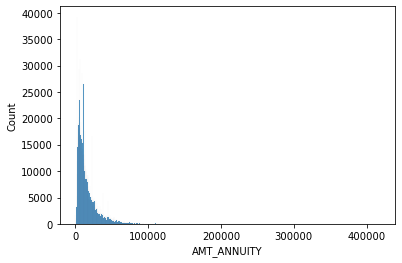

In [21]:
###### AMT_ANNUITY ###### --> not outlier
sns.histplot(x='AMT_ANNUITY', data=prev)

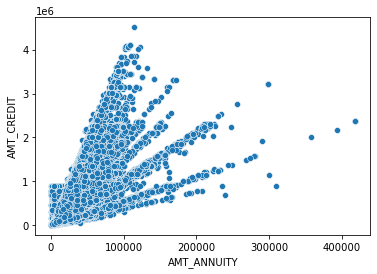

In [22]:
sns.scatterplot(x='AMT_ANNUITY', y='AMT_CREDIT', data=prev)

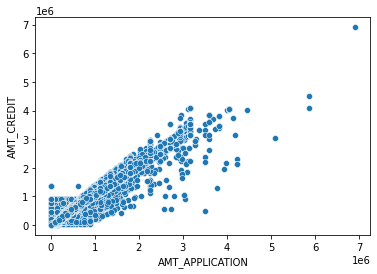

In [23]:
###### 'AMT_APPLICATION' ###### -- max val not outlier
sns.scatterplot(x='AMT_APPLICATION', y='AMT_CREDIT', data=prev)

In [27]:
###### AMT_DOWN_PAYMENT ######
prev[prev['AMT_DOWN_PAYMENT'] < 0]

SK_ID_PREV  SK_ID_CURR NAME_CONTRACT_TYPE  AMT_ANNUITY  AMT_APPLICATION  AMT_CREDIT  AMT_DOWN_PAYMENT  AMT_GOODS_PRICE WEEKDAY_APPR_PROCESS_START  HOUR_APPR_PROCESS_START FLAG_LAST_APPL_PER_CONTRACT  NFLAG_LAST_APPL_IN_DAY  RATE_DOWN_PAYMENT  RATE_INTEREST_PRIMARY  RATE_INTEREST_PRIVILEGED NAME_CASH_LOAN_PURPOSE NAME_CONTRACT_STATUS  DAYS_DECISION      NAME_PAYMENT_TYPE CODE_REJECT_REASON NAME_TYPE_SUITE NAME_CLIENT_TYPE NAME_GOODS_CATEGORY NAME_PORTFOLIO NAME_PRODUCT_TYPE  \
368107      1284109      350530     Consumer loans     7866.090         71580.60     71581.5             -0.90         71580.60                   SATURDAY                       13                           Y                       1          -0.000014                    NaN                       NaN                    XAP             Approved           -508  Cash through the bank                XAP             NaN         Repeater              Mobile            POS               XNA   
1519595     1817983      133068     Consumer loans     3595.545         32719.05     32719.5             -0.45         32719.05                     SUNDAY                       13                           Y                       1          -0.000015                    NaN                       NaN                    XAP             Approved           -478  Cash through the bank                XAP             NaN         Repeater              Mobile            POS               XNA   

         CHANNEL_TYPE  SELLERPLACE_AREA NAME_SELLER_INDUSTRY  CNT_PAYMENT NAME_YIELD_GROUP          PRODUCT_COMBINATION  DAYS_FIRST_DRAWING  DAYS_FIRST_DUE  DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  DAYS_TERMINATION  NFLAG_INSURED_ON_APPROVAL  
368107   Country-wide                45         Connectivity         10.0       low_normal  POS mobile without interest            365243.0          -459.0                     -189.0         -189.0            -185.0                        0.0  
1519595  Country-wide                45         Connectivity         10.0       low_normal  POS mobile without interest            365243.0          -430.0                     -160.0         -430.0            -415.0                        0.0

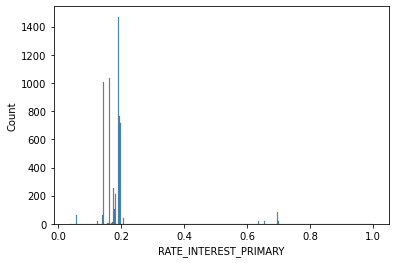

In [28]:
###### RATE_INTEREST_PRIMARY ######
sns.histplot(x='RATE_INTEREST_PRIMARY', data=prev)

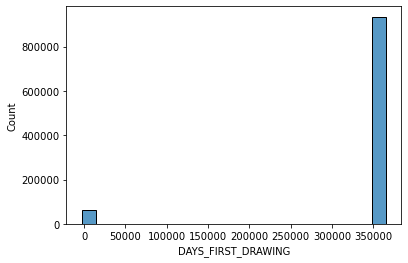

In [30]:
###### DAYS_FIRST_DRAWING ######
sns.histplot(x='DAYS_FIRST_DRAWING', data=prev)

In [37]:
def days_feat_outliers(feat):
    nb_nan = prev[prev[feat].isna()==True].shape[0]
    nb_outliers = prev[prev[feat]==np.max(prev[feat])].shape[0]
    ratio = (nb_nan + nb_outliers)/prev.shape[0]
    print('nb rows with NaN =', nb_nan)
    print('nb rows with outliers =', nb_outliers)
    print('percentage of NaN if replacement of outliers by NaN =', ratio)

In [38]:
days_feat_outliers('DAYS_FIRST_DRAWING')

nb rows with NaN = 673065
nb rows with outliers = 934444
percentage of NaN if replacement of outliers by NaN = 0.9624569067197377


In [35]:
# if replacement of outlier by NaN --> feature ends up with 96% of NaN

# Could outlier value be related to credit unused/refused/... ? ==> no
prev[prev['DAYS_FIRST_DRAWING']==np.max(prev['DAYS_FIRST_DRAWING'])]['NAME_CONTRACT_STATUS'].value_counts(dropna=False)

Approved    934444
Name: NAME_CONTRACT_STATUS, dtype: int64

In [39]:
###### other DAYS_XXXXXXXXX features with same nb of NaN and same outlier value #####
for feat in ['DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']:
    days_feat_outliers(feat)

nb rows with NaN = 673065
nb rows with outliers = 40645
percentage of NaN if replacement of outliers by NaN = 0.42731649956233153
nb rows with NaN = 673065
nb rows with outliers = 93864
percentage of NaN if replacement of outliers by NaN = 0.4591800811153541
nb rows with NaN = 673065
nb rows with outliers = 211221
percentage of NaN if replacement of outliers by NaN = 0.5294447298370148
nb rows with NaN = 673065
nb rows with outliers = 225913
percentage of NaN if replacement of outliers by NaN = 0.5382412074141397


In [41]:
for feat in ['DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']:
    print(prev[prev[feat]==np.max(prev[feat])]['NAME_CONTRACT_STATUS'].value_counts(dropna=False))
    print('-' * 40)

Approved    40645
Name: NAME_CONTRACT_STATUS, dtype: int64
----------------------------------------
Approved    93864
Name: NAME_CONTRACT_STATUS, dtype: int64
----------------------------------------
Approved    211221
Name: NAME_CONTRACT_STATUS, dtype: int64
----------------------------------------
Approved    225913
Name: NAME_CONTRACT_STATUS, dtype: int64
----------------------------------------


In [60]:
# replacement of DAYS_XXXX outliers by NaN
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

In [51]:
# Verif
for feat in ['DAYS_FIRST_DRAWING','DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE', 'DAYS_TERMINATION']:
    days_feat_outliers(feat)

nb rows with NaN = 1607509
nb rows with outliers = 20
percentage of NaN if replacement of outliers by NaN = 0.9624688812331833
nb rows with NaN = 713710
nb rows with outliers = 14
percentage of NaN if replacement of outliers by NaN = 0.42732488172174343
nb rows with NaN = 766929
nb rows with outliers = 1
percentage of NaN if replacement of outliers by NaN = 0.45918067984102634
nb rows with NaN = 884286
nb rows with outliers = 30
percentage of NaN if replacement of outliers by NaN = 0.5294626916071833
nb rows with NaN = 898978
nb rows with outliers = 602
percentage of NaN if replacement of outliers by NaN = 0.5386016402688518


### Creating new features
#### simple features

In [61]:
prev['APP_SUCCESS_RATE'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

In [62]:
prev.shape

(1670214, 172)

In [63]:
prev['APP_PAYMENT_RATE'] = prev['AMT_ANNUITY'] / prev['AMT_CREDIT']

In [64]:
prev['APP_LVR'] = prev['AMT_CREDIT'] / prev['AMT_GOODS_PRICE']

In [66]:
prev.loc[prev['APP_LVR'] >= 0.80, 'APP_LVR_RISK'] = 1
prev.loc[prev['APP_LVR'] < 0.80, 'APP_LVR_RISK'] = 0

In [68]:
prev['APP_LVR_RISK'].value_counts(dropna=False)

1.0    1222875
NaN     388243
0.0      59096
Name: APP_LVR_RISK, dtype: int64

In [67]:
prev.shape

(1670214, 175)

#### features resulting from aggregations

In [69]:
num_aggregations = {
    'AMT_ANNUITY': ['min', 'max', 'mean'],
    'AMT_APPLICATION': ['min', 'max', 'mean'],
    'AMT_CREDIT': ['min', 'max', 'mean'],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['min', 'max', 'mean'],
    'APP_SUCCESS_RATE': ['min', 'max', 'mean', 'var'],
    'APP_PAYMENT_RATE': ['min', 'max', 'mean'],
    'APP_LVR': ['min', 'max', 'mean'],
    'WEEKDAY_APPR_PROCESS_START_SIN': ['min', 'max', 'mean'],
    'WEEKDAY_APPR_PROCESS_START_COS': ['min', 'max', 'mean'],
    'HOUR_APPR_PROCESS_START_SIN': ['min', 'max', 'mean'],
    'HOUR_APPR_PROCESS_START_COS': ['min', 'max', 'mean']}

In [70]:
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']

In [71]:
prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(['PREV_' + e[0] + "__" + e[1].lower() for e in prev_agg.columns.tolist()])

In [72]:
prev_agg.head(5)

PREV_AMT_ANNUITY__min  PREV_AMT_ANNUITY__max  PREV_AMT_ANNUITY__mean  PREV_AMT_APPLICATION__min  PREV_AMT_APPLICATION__max  PREV_AMT_APPLICATION__mean  PREV_AMT_CREDIT__min  PREV_AMT_CREDIT__max  PREV_AMT_CREDIT__mean  PREV_AMT_DOWN_PAYMENT__min  PREV_AMT_DOWN_PAYMENT__max  PREV_AMT_DOWN_PAYMENT__mean  PREV_AMT_GOODS_PRICE__min  PREV_AMT_GOODS_PRICE__max  PREV_AMT_GOODS_PRICE__mean  PREV_RATE_DOWN_PAYMENT__min  PREV_RATE_DOWN_PAYMENT__max  PREV_RATE_DOWN_PAYMENT__mean  \
SK_ID_CURR                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
100001                   3951.000               3951.000                3951.000                    24835.5                    24835.5                    24835.50               23787.0               23787.0               23787.00                      2520.0                      2520.0                       2520.0                    24835.5                    24835.5                     24835.5                     0.104326                     0.104326                      0.104326   
100002                   9251.775               9251.775                9251.775                   179055.0                   179055.0                   179055.00              179055.0              179055.0              179055.00                         0.0                         0.0                          0.0                   179055.0                   179055.0                    179055.0                     0.000000                     0.000000                      0.000000   
100003                   6737.310              98356.995               56553.990                    68809.5                   900000.0                   435436.50               68053.5             1035882.0              484191.00                         0.0                      6885.0                       3442.5                    68809.5                   900000.0                    435436.5                     0.000000                     0.100061                      0.050030   
100004                   5357.250               5357.250                5357.250                    24282.0                    24282.0                    24282.00               20106.0               20106.0               20106.00                      4860.0                      4860.0                       4860.0                    24282.0                    24282.0                     24282.0                     0.212008                     0.212008                      0.212008   
100005                   4813.200               4813.200                4813.200                        0.0                    44617.5                    22308.75                   0.0               40153.5               20076.75                      4464.0                      4464.0                       4464.0                    44617.5                    44617.5                     44617.5                     0.108964                     0.108964                      0.108964   

            PREV_DAYS_DECISION__min  PREV_DAYS_DECISION__max  PREV_DAYS_DECISION__mean  PREV_CNT_PAYMENT__min  PREV_CNT_PAYMENT__max  PREV_CNT_PAYMENT__mean  PREV_APP_SUCCESS_RATE__min  PREV_APP_SUCCESS_RATE__max  PREV_APP_SUCCESS_RATE__mean  PREV_APP_SUCCESS_RATE__var  PREV_APP_PAYMENT_RATE__min  PREV_APP_PAYMENT_RATE__max  PREV_APP_PAYMENT_RATE__mean  PREV_APP_LVR__min  PREV_APP_LVR__max  PREV_APP_LVR__mean  PREV_WEEKDAY_APPR_PROCESS_START_SIN__min  PREV_WEEKDAY_APPR_PROCESS_START_SIN__max  \
SK_ID_CURR                                                                                     

In [73]:
prev_agg.shape

(338857, 192)

In [74]:
approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "__" + e[1].lower() for e in approved_agg.columns.tolist()])
prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
print(prev_agg.shape)
prev_agg.head(5)

(338857, 238)


PREV_AMT_ANNUITY__min  PREV_AMT_ANNUITY__max  PREV_AMT_ANNUITY__mean  PREV_AMT_APPLICATION__min  PREV_AMT_APPLICATION__max  PREV_AMT_APPLICATION__mean  PREV_AMT_CREDIT__min  PREV_AMT_CREDIT__max  PREV_AMT_CREDIT__mean  PREV_AMT_DOWN_PAYMENT__min  PREV_AMT_DOWN_PAYMENT__max  PREV_AMT_DOWN_PAYMENT__mean  PREV_AMT_GOODS_PRICE__min  PREV_AMT_GOODS_PRICE__max  PREV_AMT_GOODS_PRICE__mean  PREV_RATE_DOWN_PAYMENT__min  PREV_RATE_DOWN_PAYMENT__max  PREV_RATE_DOWN_PAYMENT__mean  \
SK_ID_CURR                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
100001                   3951.000               3951.000                3951.000                    24835.5                    24835.5                    24835.50               23787.0               23787.0               23787.00                      2520.0                      2520.0                       2520.0                    24835.5                    24835.5                     24835.5                     0.104326                     0.104326                      0.104326   
100002                   9251.775               9251.775                9251.775                   179055.0                   179055.0                   179055.00              179055.0              179055.0              179055.00                         0.0                         0.0                          0.0                   179055.0                   179055.0                    179055.0                     0.000000                     0.000000                      0.000000   
100003                   6737.310              98356.995               56553.990                    68809.5                   900000.0                   435436.50               68053.5             1035882.0              484191.00                         0.0                      6885.0                       3442.5                    68809.5                   900000.0                    435436.5                     0.000000                     0.100061                      0.050030   
100004                   5357.250               5357.250                5357.250                    24282.0                    24282.0                    24282.00               20106.0               20106.0               20106.00                      4860.0                      4860.0                       4860.0                    24282.0                    24282.0                     24282.0                     0.212008                     0.212008                      0.212008   
100005                   4813.200               4813.200                4813.200                        0.0                    44617.5                    22308.75                   0.0               40153.5               20076.75                      4464.0                      4464.0                       4464.0                    44617.5                    44617.5                     44617.5                     0.108964                     0.108964                      0.108964   

            PREV_DAYS_DECISION__min  PREV_DAYS_DECISION__max  PREV_DAYS_DECISION__mean  PREV_CNT_PAYMENT__min  PREV_CNT_PAYMENT__max  PREV_CNT_PAYMENT__mean  PREV_APP_SUCCESS_RATE__min  PREV_APP_SUCCESS_RATE__max  PREV_APP_SUCCESS_RATE__mean  PREV_APP_SUCCESS_RATE__var  PREV_APP_PAYMENT_RATE__min  PREV_APP_PAYMENT_RATE__max  PREV_APP_PAYMENT_RATE__mean  PREV_APP_LVR__min  PREV_APP_LVR__max  PREV_APP_LVR__mean  PREV_WEEKDAY_APPR_PROCESS_START_SIN__min  PREV_WEEKDAY_APPR_PROCESS_START_SIN__max  \
SK_ID_CURR                                                                                     

In [75]:
refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['prevREFUSED_' + e[0] + "__" + e[1].lower() for e in refused_agg.columns.tolist()])
prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
print(prev_agg.shape)
prev_agg.head(5)

(338857, 284)


PREV_AMT_ANNUITY__min  PREV_AMT_ANNUITY__max  PREV_AMT_ANNUITY__mean  PREV_AMT_APPLICATION__min  PREV_AMT_APPLICATION__max  PREV_AMT_APPLICATION__mean  PREV_AMT_CREDIT__min  PREV_AMT_CREDIT__max  PREV_AMT_CREDIT__mean  PREV_AMT_DOWN_PAYMENT__min  PREV_AMT_DOWN_PAYMENT__max  PREV_AMT_DOWN_PAYMENT__mean  PREV_AMT_GOODS_PRICE__min  PREV_AMT_GOODS_PRICE__max  PREV_AMT_GOODS_PRICE__mean  PREV_RATE_DOWN_PAYMENT__min  PREV_RATE_DOWN_PAYMENT__max  PREV_RATE_DOWN_PAYMENT__mean  \
SK_ID_CURR                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
100001                   3951.000               3951.000                3951.000                    24835.5                    24835.5                    24835.50               23787.0               23787.0               23787.00                      2520.0                      2520.0                       2520.0                    24835.5                    24835.5                     24835.5                     0.104326                     0.104326                      0.104326   
100002                   9251.775               9251.775                9251.775                   179055.0                   179055.0                   179055.00              179055.0              179055.0              179055.00                         0.0                         0.0                          0.0                   179055.0                   179055.0                    179055.0                     0.000000                     0.000000                      0.000000   
100003                   6737.310              98356.995               56553.990                    68809.5                   900000.0                   435436.50               68053.5             1035882.0              484191.00                         0.0                      6885.0                       3442.5                    68809.5                   900000.0                    435436.5                     0.000000                     0.100061                      0.050030   
100004                   5357.250               5357.250                5357.250                    24282.0                    24282.0                    24282.00               20106.0               20106.0               20106.00                      4860.0                      4860.0                       4860.0                    24282.0                    24282.0                     24282.0                     0.212008                     0.212008                      0.212008   
100005                   4813.200               4813.200                4813.200                        0.0                    44617.5                    22308.75                   0.0               40153.5               20076.75                      4464.0                      4464.0                       4464.0                    44617.5                    44617.5                     44617.5                     0.108964                     0.108964                      0.108964   

            PREV_DAYS_DECISION__min  PREV_DAYS_DECISION__max  PREV_DAYS_DECISION__mean  PREV_CNT_PAYMENT__min  PREV_CNT_PAYMENT__max  PREV_CNT_PAYMENT__mean  PREV_APP_SUCCESS_RATE__min  PREV_APP_SUCCESS_RATE__max  PREV_APP_SUCCESS_RATE__mean  PREV_APP_SUCCESS_RATE__var  PREV_APP_PAYMENT_RATE__min  PREV_APP_PAYMENT_RATE__max  PREV_APP_PAYMENT_RATE__mean  PREV_APP_LVR__min  PREV_APP_LVR__max  PREV_APP_LVR__mean  PREV_WEEKDAY_APPR_PROCESS_START_SIN__min  PREV_WEEKDAY_APPR_PROCESS_START_SIN__max  \
SK_ID_CURR                                                                                     

In [77]:
prev_agg['prevREFUSED_RATE_DOWN_PAYMENT__max'].isna().sum() / prev_agg.shape[0]

0.8447575230849591

In [79]:
del refused, refused_agg, approved, approved_agg, prev
gc.collect()

NameError: name 'refused' is not defined

### test of full and clean code for preprocessing 'Previous_application' Data
* **full and clean code**

In [19]:
def previous_app(num_rows = None, nan_as_category=True):
    prev = pd.read_csv(path+'previous_application.csv', nrows = num_rows)
    print('prev shape:', prev.shape)

    # Replacing rare unique values by more common similar ones
    prev.loc[prev['NAME_GOODS_CATEGORY'] == 'House Construction', 'NAME_GOODS_CATEGORY'] = 'Construction Materials'
    prev.loc[prev['NAME_GOODS_CATEGORY'] == 'Animals', 'NAME_GOODS_CATEGORY'] = 'Other'
    
    # Categorical features with Binary encode (0 or 1; two categories)
    prev['FLAG_LAST_APPL_PER_CONTRACT'], uniques = pd.factorize(prev['FLAG_LAST_APPL_PER_CONTRACT'])
    
    # Cyclic features
        # Changing weekdays with integer values
    weekday_dict = {'MONDAY': 1, 'TUESDAY': 2, 'WEDNESDAY': 3, 'THURSDAY': 4, 'FRIDAY': 5, 'SATURDAY': 6, 'SUNDAY': 7}
    prev.replace({'WEEKDAY_APPR_PROCESS_START': weekday_dict}, inplace=True)
        # Creating sin-cos transformed features
    prev = encode(prev, 'WEEKDAY_APPR_PROCESS_START', 7)
    prev = encode(prev, 'HOUR_APPR_PROCESS_START', 23)
        # Deleting initial WEEKDAY_APPR_PROCESS_START and HOUR_APPR_PROCESS_START features
    prev.drop(['WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START'], axis=1, inplace=True)
    
    # encoding of categorical features
    prev, cat_cols = one_hot_encoder(prev, nan_as_category)
    
    # Outliers
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
    
    # Creating new simple features
    prev['APP_SUCCESS_RATE'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    prev['APP_PAYMENT_RATE'] = prev['AMT_ANNUITY'] / prev['AMT_CREDIT']
    prev['APP_LVR'] = prev['AMT_CREDIT'] / prev['AMT_GOODS_PRICE']
        # LVR risk
    prev.loc[prev['APP_LVR'] >= 0.80, 'APP_LVR_RISK'] = 1
    prev.loc[prev['APP_LVR'] < 0.80, 'APP_LVR_RISK'] = 0
    
    # Creating new features from aggregations
        # defining aggregations for numeric features
    def std(x): return np.nanstd(x)
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['min', 'max', 'mean'],
        'APP_SUCCESS_RATE': ['min', 'max', 'mean', std],
        'APP_PAYMENT_RATE': ['min', 'max', 'mean'],
        'APP_LVR': ['min', 'max', 'mean'],
        'WEEKDAY_APPR_PROCESS_START_SIN': ['min', 'max', 'mean'],
        'WEEKDAY_APPR_PROCESS_START_COS': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START_SIN': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START_COS': ['min', 'max', 'mean']
    }
        # defining aggregations for catgeorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
        # performing all those aggregations on all individuals
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "__" + e[1].lower() for e in prev_agg.columns.tolist()])
        # performing aggregations on numeric features for individuals with APPROVED applications
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['prevAPPROVED_' + e[0] + "__" + e[1].lower() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')        
        # performing aggregations on numeric features for individuals with REFUSED applications
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['prevREFUSED_' + e[0] + "__" + e[1].lower() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

* **testing it**

In [92]:
num_rows = 10000
prev_agg = previous_app(num_rows)
prev_agg.head(2)

prev shape: (10000, 37)


C:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


PREV_AMT_ANNUITY__min  PREV_AMT_ANNUITY__max  PREV_AMT_ANNUITY__mean  PREV_AMT_APPLICATION__min  PREV_AMT_APPLICATION__max  PREV_AMT_APPLICATION__mean  PREV_AMT_CREDIT__min  PREV_AMT_CREDIT__max  PREV_AMT_CREDIT__mean  PREV_AMT_DOWN_PAYMENT__min  PREV_AMT_DOWN_PAYMENT__max  PREV_AMT_DOWN_PAYMENT__mean  PREV_AMT_GOODS_PRICE__min  PREV_AMT_GOODS_PRICE__max  PREV_AMT_GOODS_PRICE__mean  PREV_RATE_DOWN_PAYMENT__min  PREV_RATE_DOWN_PAYMENT__max  PREV_RATE_DOWN_PAYMENT__mean  \
SK_ID_CURR                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
100009                    8996.76                8996.76                 8996.76                    98239.5                    98239.5                     98239.5               98239.5               98239.5                98239.5                         0.0                         0.0                          0.0                    98239.5                    98239.5                     98239.5                          0.0                          0.0                           0.0   
100035                        NaN                    NaN                     NaN                        0.0                        0.0                         0.0                   0.0                   0.0                    0.0                         NaN                         NaN                          NaN                        NaN                        NaN                         NaN                          NaN                          NaN                           NaN   

            PREV_DAYS_DECISION__min  PREV_DAYS_DECISION__max  PREV_DAYS_DECISION__mean  PREV_CNT_PAYMENT__min  PREV_CNT_PAYMENT__max  PREV_CNT_PAYMENT__mean  PREV_APP_SUCCESS_RATE__min  PREV_APP_SUCCESS_RATE__max  PREV_APP_SUCCESS_RATE__mean  PREV_APP_SUCCESS_RATE__nanstd  PREV_APP_PAYMENT_RATE__min  PREV_APP_PAYMENT_RATE__max  PREV_APP_PAYMENT_RATE__mean  PREV_APP_LVR__min  PREV_APP_LVR__max  PREV_APP_LVR__mean  PREV_WEEKDAY_APPR_PROCESS_START_SIN__min  \
SK_ID_CURR                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
100009                         -449                     -449                    -449.0                   12.0                   12.0                    12.0                         1.0                         1.0                          1.0                            0.0                     0.09158                     0.09158                      0.09158                1.0                1.0                 1.0                                 -0.781831   
100035                         -138                     -138                    -138.0                    NaN                    NaN                     NaN                         NaN                         NaN                          NaN                            NaN                         NaN                         NaN                          NaN                NaN                NaN                 NaN                                 -0.974928   

            PREV_WEEKDAY_APPR_PROCESS_START_SIN__max  PREV_WEEKDAY_APPR_PROCESS_START_SIN__mean  PREV_WEEKDAY_APPR_PROCESS_START_COS__min  PREV_WEEKDAY_APPR_PROCESS_START_COS__max  PREV_WEEKDAY_APPR_PROCESS_START_C

In [20]:
num_rows = None
prev_agg = previous_app(num_rows)
prev_agg.shape

prev shape: (1670214, 37)


(338857, 284)

In [94]:
for col in prev_agg.columns.tolist():
    print('nan in', col, ':', prev_agg[col].isna().sum(),
          '(ratio of', round(prev_agg[col].isna().sum()/prev_agg.shape[0], 2), ')')

nan in PREV_AMT_ANNUITY__min : 480 (ratio of 0.0 )
nan in PREV_AMT_ANNUITY__max : 480 (ratio of 0.0 )
nan in PREV_AMT_ANNUITY__mean : 480 (ratio of 0.0 )
nan in PREV_AMT_APPLICATION__min : 0 (ratio of 0.0 )
nan in PREV_AMT_APPLICATION__max : 0 (ratio of 0.0 )
nan in PREV_AMT_APPLICATION__mean : 0 (ratio of 0.0 )
nan in PREV_AMT_CREDIT__min : 0 (ratio of 0.0 )
nan in PREV_AMT_CREDIT__max : 0 (ratio of 0.0 )
nan in PREV_AMT_CREDIT__mean : 0 (ratio of 0.0 )
nan in PREV_AMT_DOWN_PAYMENT__min : 20104 (ratio of 0.06 )
nan in PREV_AMT_DOWN_PAYMENT__max : 20104 (ratio of 0.06 )
nan in PREV_AMT_DOWN_PAYMENT__mean : 20104 (ratio of 0.06 )
nan in PREV_AMT_GOODS_PRICE__min : 1064 (ratio of 0.0 )
nan in PREV_AMT_GOODS_PRICE__max : 1064 (ratio of 0.0 )
nan in PREV_AMT_GOODS_PRICE__mean : 1064 (ratio of 0.0 )
nan in PREV_RATE_DOWN_PAYMENT__min : 20104 (ratio of 0.06 )
nan in PREV_RATE_DOWN_PAYMENT__max : 20104 (ratio of 0.06 )
nan in PREV_RATE_DOWN_PAYMENT__mean : 20104 (ratio of 0.06 )
nan in PREV_D

nan in prevREFUSED_AMT_GOODS_PRICE__min : 228815 (ratio of 0.68 )
nan in prevREFUSED_AMT_GOODS_PRICE__max : 228815 (ratio of 0.68 )
nan in prevREFUSED_AMT_GOODS_PRICE__mean : 228815 (ratio of 0.68 )
nan in prevREFUSED_RATE_DOWN_PAYMENT__min : 286252 (ratio of 0.84 )
nan in prevREFUSED_RATE_DOWN_PAYMENT__max : 286252 (ratio of 0.84 )
nan in prevREFUSED_RATE_DOWN_PAYMENT__mean : 286252 (ratio of 0.84 )
nan in prevREFUSED_DAYS_DECISION__min : 220580 (ratio of 0.65 )
nan in prevREFUSED_DAYS_DECISION__max : 220580 (ratio of 0.65 )
nan in prevREFUSED_DAYS_DECISION__mean : 220580 (ratio of 0.65 )
nan in prevREFUSED_CNT_PAYMENT__min : 230761 (ratio of 0.68 )
nan in prevREFUSED_CNT_PAYMENT__max : 230761 (ratio of 0.68 )
nan in prevREFUSED_CNT_PAYMENT__mean : 230761 (ratio of 0.68 )
nan in prevREFUSED_APP_SUCCESS_RATE__min : 226400 (ratio of 0.67 )
nan in prevREFUSED_APP_SUCCESS_RATE__max : 226400 (ratio of 0.67 )
nan in prevREFUSED_APP_SUCCESS_RATE__mean : 226400 (ratio of 0.67 )
nan in prevREF

## 'POS_CASH_balance' Data
### Data loading + detailed preview + quick EDA

In [95]:
pos = pd.read_csv(path+'POS_CASH_balance.csv', nrows=num_rows)

In [96]:
simplified_analyse_col_distr(pos)

df shape = (10001358, 8)
nb of duplicates = 0
----------------------------------------
----------------------------------------
SK_ID_PREV  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 10001358
--------------------
min = 1000001
max = 2843499
mean = 1903216.5989568618
std = 535846.5039331202
nan_std = 535846.5039330517
Relative_nan_std = 28.154783025050595
----------------------------------------
----------------------------------------
SK_ID_CURR  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 10001358
--------------------
min = 100001
max = 456255
mean = 278403.8633055631
std = 102763.73995218684
nan_std = 102763.73995219938
Relative_nan_std = 36.911750696293566
----------------------------------------
----------------------------------------
MONTHS_BALANCE  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 10001358
--------------------
min = -96
max = -1
mean = -35.012587990550884
std = 26.066568664341773
nan_std = 26.066568664438982
Relative_na

In [98]:
# Exploring NaN in CNT_INSTALMENT
pos[pos['CNT_INSTALMENT'].isna()==True]['NAME_CONTRACT_STATUS'].value_counts(dropna=False)

Signed                   20266
Returned to the store     2961
Approved                  2804
Active                      26
Canceled                    12
XNA                          2
Name: NAME_CONTRACT_STATUS, dtype: int64

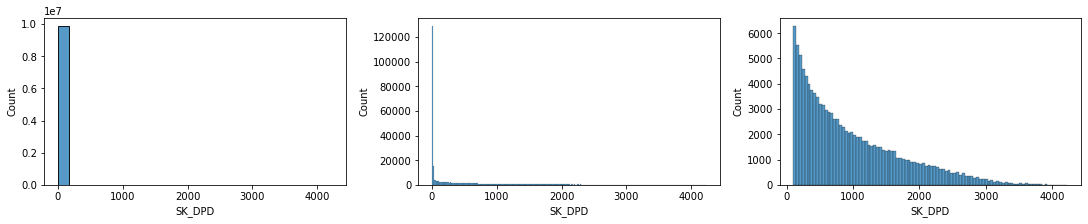

In [104]:
# checking potential outliers in 'SK_DPD'
fig, axes = plt.subplots(1, 3, figsize=(15, 3), constrained_layout=True)
g1 = sns.histplot(x='SK_DPD', data=pos, ax=axes[0])
g2 = sns.histplot(x='SK_DPD', data=pos[pos['SK_DPD']>1], ax=axes[1])
g3 = sns.histplot(x='SK_DPD', data=pos[pos['SK_DPD']>100], ax=axes[2])

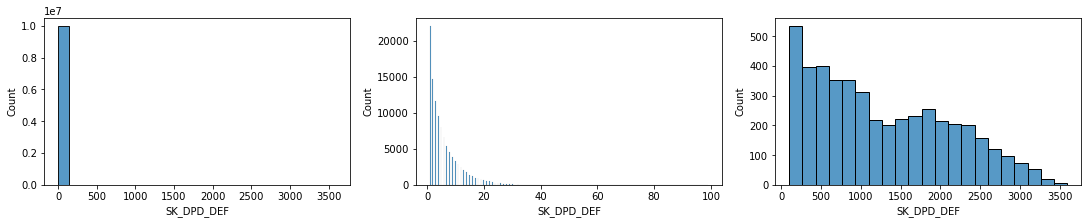

In [117]:
# checking potential outliers in SK_DPD_DEF
fig, axes = plt.subplots(1, 3, figsize=(15, 3), constrained_layout=True)
g1 = sns.histplot(x='SK_DPD_DEF', data=pos, ax=axes[0])
g2 = sns.histplot(x='SK_DPD_DEF', data=pos[pos['SK_DPD_DEF']>0][pos[pos['SK_DPD_DEF']>0]['SK_DPD_DEF']<100], ax=axes[1])
g3 = sns.histplot(x='SK_DPD_DEF', data=pos[pos['SK_DPD_DEF']>100], ax=axes[2])

### preprocessing

In [119]:
# encoding
print(pos.shape)
pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)
print(pos.shape)
check_encoded_cat_cols(pos, cat_cols)

(10001358, 8)
(10001358, 17)
nb of categorical columns created though OHE =  10
--------------------
['NAME_CONTRACT_STATUS_Active', 'NAME_CONTRACT_STATUS_Amortized debt', 'NAME_CONTRACT_STATUS_Approved', 'NAME_CONTRACT_STATUS_Canceled', 'NAME_CONTRACT_STATUS_Completed', 'NAME_CONTRACT_STATUS_Demand', 'NAME_CONTRACT_STATUS_Returned to the store', 'NAME_CONTRACT_STATUS_Signed', 'NAME_CONTRACT_STATUS_XNA', 'NAME_CONTRACT_STATUS_nan']
----------------------------------------------------------------------------------------------------
NAME_CONTRACT_STATUS_Active
Nb of Nan = 0 out of 10001358
Nb of unique values = 2
--------------------
NAME_CONTRACT_STATUS_Amortized debt
Nb of Nan = 0 out of 10001358
Nb of unique values = 2
--------------------
NAME_CONTRACT_STATUS_Approved
Nb of Nan = 0 out of 10001358
Nb of unique values = 2
--------------------
NAME_CONTRACT_STATUS_Canceled
Nb of Nan = 0 out of 10001358
Nb of unique values = 2
--------------------
NAME_CONTRACT_STATUS_Completed
Nb of Na

In [120]:
# Creating new features through aggregations
    # defining aggregations for numeric features
aggregations = {
    'MONTHS_BALANCE': ['max', 'mean', 'size'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
}
    # defining aggregations for categorical features
for cat in cat_cols:
    aggregations[cat] = ['mean']
    # performing them
pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['POS_' + e[0] + "__" + e[1].lower() for e in pos_agg.columns.tolist()])
    # check
print(pos_agg.shape)
pos_agg.head(5)

(337252, 17)


POS_MONTHS_BALANCE__max  POS_MONTHS_BALANCE__mean  POS_MONTHS_BALANCE__size  POS_SK_DPD__max  POS_SK_DPD__mean  POS_SK_DPD_DEF__max  POS_SK_DPD_DEF__mean  POS_NAME_CONTRACT_STATUS_Active__mean  POS_NAME_CONTRACT_STATUS_Amortized debt__mean  POS_NAME_CONTRACT_STATUS_Approved__mean  POS_NAME_CONTRACT_STATUS_Canceled__mean  POS_NAME_CONTRACT_STATUS_Completed__mean  POS_NAME_CONTRACT_STATUS_Demand__mean  POS_NAME_CONTRACT_STATUS_Returned to the store__mean  \
SK_ID_CURR                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
100001                          -53                -72.555556                         9                7          0.777778                    7              0.777778                               0.777778                                            0.0                                      0.0                                      0.0                                  0.222222                                    0.0                                                0.0      
100002                           -1                -10.000000                        19                0          0.000000                    0              0.000000                               1.000000                                            0.0                                      0.0                                      0.0                                  0.000000                                    0.0                                                0.0      
100003                          -18                -43.785714                        28                0          0.000000                    0              0.000000                               0.928571                                            0.0                                      0.0                                      0.0                                  0.071429                                    0.0                                                0.0      
100004                          -24                -25.500000                         4                0          0.000000                    0              0.000000                               0.750000                                            0.0                                      0.0                                      0.0                                  0.250000                                    0.0                                                0.0      
100005                          -15                -20.000000                        11                0          0.000000                    0              0.000000                               0.818182                                            0.0                                      0.0                                      0.0                                  0.090909                                    0.0                                                0.0      

            POS_NAME_CONTRACT_STATUS_Signed__mean  POS_NAME_CONTRACT_STATUS_XNA__mean  POS_NAME_CONTRACT_STATUS_nan__mean  
SK_ID_CURR                                                                                                                 
100001                                   0.000000                                 0.0                                   0  
100002                                   0.000000                                 0.0                                   0  
100003                                   0.000000                                 0.0                                   0  
100004                                   0.000000                                 0.0  

In [121]:
# Creating a new feature: count of previous credit and cash loans by ID of loan in current sample
pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
print(pos_agg.shape)

(337252, 18)


In [122]:
del pos
gc.collect()

1981999

In [123]:
simplified_analyse_col_distr(pos_agg)

df shape = (337252, 18)
nb of duplicates = 110125
----------------------------------------
----------------------------------------
POS_MONTHS_BALANCE__max  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 337252
--------------------
min = -96
max = -1
mean = -12.591605090555431
std = 18.64859235371699
nan_std = 18.648592353711617
Relative_nan_std = -148.1033769689882
----------------------------------------
----------------------------------------
POS_MONTHS_BALANCE__mean  -- dtype =  float64
--------------------
Nb of Nan = 0 out of 337252
--------------------
min = -96.0
max = -1.0
mean = -31.87326271597563
std = 20.081163314171487
nan_std = 20.0811633141713
Relative_nan_std = -63.00316190757009
----------------------------------------
----------------------------------------
POS_MONTHS_BALANCE__size  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 337252
--------------------
min = 1
max = 295
mean = 29.655444593360453
std = 24.531934518927784
nan_std = 24.531

### Full and clean code for preprocessing 'POS_CASH_balance' Data

In [34]:
def pos_cash(num_rows=None, nan_as_category=True):
    pos = pd.read_csv(path+'POS_CASH_balance.csv', nrows=num_rows)
    print('POS shape:', pos.shape)
    
    # OHE encoding of categorical features
    pos, cat_cols = one_hot_encoder(pos, nan_as_category)
    
    # Creating new features through aggregations
        # defining aggregations for numeric features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
        # defining aggregations for categorical features
    for cat in cat_cols:
        aggregations[cat] = ['mean']
        # performing them
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "__" + e[1].lower() for e in pos_agg.columns.tolist()])
    
    # Creating a new feature: count of previous credit and cash loans by ID of loan in current sample
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    
    del pos
    gc.collect()
    return pos_agg

In [133]:
# testing it
num_rows = 10000
pos_agg = pos_cash(num_rows)
print(pos_agg.shape)
pos_agg.head(2)

POS shape: (10000, 8)
(9494, 15)


POS_MONTHS_BALANCE__max  POS_MONTHS_BALANCE__mean  POS_MONTHS_BALANCE__size  POS_SK_DPD__max  POS_SK_DPD__mean  POS_SK_DPD_DEF__max  POS_SK_DPD_DEF__mean  POS_NAME_CONTRACT_STATUS_Active__mean  POS_NAME_CONTRACT_STATUS_Approved__mean  POS_NAME_CONTRACT_STATUS_Completed__mean  POS_NAME_CONTRACT_STATUS_Demand__mean  POS_NAME_CONTRACT_STATUS_Returned to the store__mean  POS_NAME_CONTRACT_STATUS_Signed__mean  POS_NAME_CONTRACT_STATUS_nan__mean  POS_COUNT
SK_ID_CURR                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
100028                          -47                     -47.0                         1                0               0.0                    0                   0.0                                    1.0                                        0                                       0.0                                      0                                                  0                                       0.0                                   0          1
100047                          -40                     -40.0                         1                0               0.0                    0                   0.0                                    1.0                                        0                                       0.0                                      0                                                  0                                       0.0                                   0          1

In [132]:
# missing features - testing it again with higher number of rows considered
num_rows = 1000000
pos_agg = pos_cash(num_rows)
print(pos_agg.shape)
pos_agg.head(2)


POS shape: (1000000, 8)
(258189, 16)


POS_MONTHS_BALANCE__max  POS_MONTHS_BALANCE__mean  POS_MONTHS_BALANCE__size  POS_SK_DPD__max  POS_SK_DPD__mean  POS_SK_DPD_DEF__max  POS_SK_DPD_DEF__mean  POS_NAME_CONTRACT_STATUS_Active__mean  POS_NAME_CONTRACT_STATUS_Approved__mean  POS_NAME_CONTRACT_STATUS_Canceled__mean  POS_NAME_CONTRACT_STATUS_Completed__mean  POS_NAME_CONTRACT_STATUS_Demand__mean  POS_NAME_CONTRACT_STATUS_Returned to the store__mean  POS_NAME_CONTRACT_STATUS_Signed__mean  POS_NAME_CONTRACT_STATUS_nan__mean  \
SK_ID_CURR                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
100002                          -13                     -13.0                         1                0               0.0                    0                   0.0                                    1.0                                      0.0                                      0.0                                       0.0                                    0.0                                                0.0                                       0.0                                   0   
100003                          -23                     -44.5                         2                0               0.0                    0                   0.0                                    1.0                                      0.0                                      0.0                                       0.0                                    0.0                                                0.0                                       0.0                                   0   

            POS_COUNT  
SK_ID_CURR             
100002              1  
100003              2

**Note: nb of features in final pos_agg depends on the number of rows sampled, with values of NAME_CONTRACT_STATUS with less occurences being not represented in final pos_agg df (i.e. as POS_NAME_CONTRACT_STATUS_XXXValueXXX__mean) as they are not sampled**

In [35]:
# testing on all rows
num_rows = None
pos_agg = pos_cash(num_rows)
print(pos_agg.shape)
pos_agg.head(2)

POS shape: (10001358, 8)
(337252, 18)


POS_MONTHS_BALANCE__max  POS_MONTHS_BALANCE__mean  POS_MONTHS_BALANCE__size  POS_SK_DPD__max  POS_SK_DPD__mean  POS_SK_DPD_DEF__max  POS_SK_DPD_DEF__mean  POS_NAME_CONTRACT_STATUS_Active__mean  POS_NAME_CONTRACT_STATUS_Amortized debt__mean  POS_NAME_CONTRACT_STATUS_Approved__mean  POS_NAME_CONTRACT_STATUS_Canceled__mean  POS_NAME_CONTRACT_STATUS_Completed__mean  POS_NAME_CONTRACT_STATUS_Demand__mean  POS_NAME_CONTRACT_STATUS_Returned to the store__mean  \
SK_ID_CURR                                                                                                                                                                                                                                                                                                                                                                                                                                                                             
100001                          -53                -72.555556                         9                7          0.777778                    7              0.777778                               0.777778                                            0.0                                      0.0                                      0.0                                  0.222222                                    0.0                                                0.0      
100002                           -1                -10.000000                        19                0          0.000000                    0              0.000000                               1.000000                                            0.0                                      0.0                                      0.0                                  0.000000                                    0.0                                                0.0      

            POS_NAME_CONTRACT_STATUS_Signed__mean  POS_NAME_CONTRACT_STATUS_XNA__mean  POS_NAME_CONTRACT_STATUS_nan__mean  POS_COUNT  
SK_ID_CURR                                                                                                                            
100001                                        0.0                                 0.0                                   0          9  
100002                                        0.0                                 0.0                                   0         19

## 'Installments_payments' Data
### data loading + detailed preview

In [134]:
ins = pd.read_csv(path+'installments_payments.csv', nrows=None)

In [135]:
simplified_analyse_col_distr(ins)

df shape = (13605401, 8)
nb of duplicates = 0
----------------------------------------
----------------------------------------
SK_ID_PREV  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 13605401
--------------------
min = 1000001
max = 2843499
mean = 1903364.9695492988
std = 536202.8858403736
nan_std = 536202.885840222
Relative_nan_std = 28.171312092981857
----------------------------------------
----------------------------------------
SK_ID_CURR  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 13605401
--------------------
min = 100001
max = 456255
mean = 278444.88173821557
std = 102718.3066365822
nan_std = 102718.30663658971
Relative_nan_std = 36.889996323639366
----------------------------------------
----------------------------------------
NUM_INSTALMENT_VERSION  -- dtype =  float64
--------------------
Nb of Nan = 0 out of 13605401
--------------------
min = 0.0
max = 178.0
mean = 0.8566373016127933
std = 1.0352156976063478
nan_std = 1.0352156977308147


### Exploring potential outliers

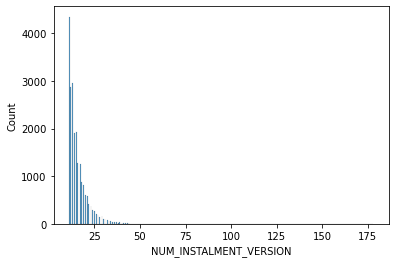

In [138]:
# checking potential outliers
sns.histplot(x='NUM_INSTALMENT_VERSION', data=ins[ins['NUM_INSTALMENT_VERSION']>10])

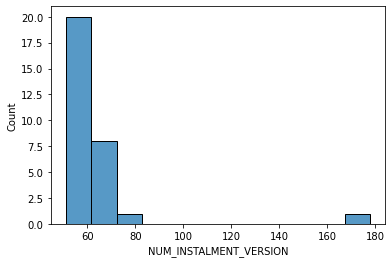

In [139]:
sns.histplot(x='NUM_INSTALMENT_VERSION', data=ins[ins['NUM_INSTALMENT_VERSION']>50])

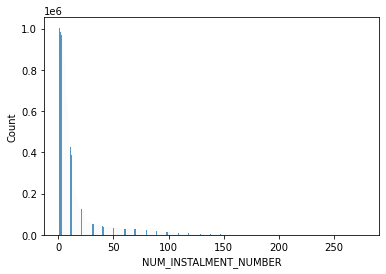

In [140]:
sns.histplot(x='NUM_INSTALMENT_NUMBER', data=ins)

### Exploring NaN

In [141]:
ins[ins['DAYS_ENTRY_PAYMENT'].isna()==True]

SK_ID_PREV  SK_ID_CURR  NUM_INSTALMENT_VERSION  NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  AMT_PAYMENT
3764207      1531600      103793                     1.0                      7           -668.0                 NaN       49741.020          NaN
3764208      1947105      159974                     1.0                     24            -36.0                 NaN       22849.515          NaN
3764209      1843773      167270                     1.0                     22            -20.0                 NaN       48092.355          NaN
3764210      1691592      192536                     1.0                      5          -2561.0                 NaN        7675.425          NaN
3764211      1531299      157088                     0.0                     11          -1847.0                 NaN          67.500          NaN
...              ...         ...                     ...                    ...              ...                 ...             ...          ...
13605396     2186857      428057                     0.0                     66          -1624.0                 NaN          67.500          NaN
13605397     1310347      414406                     0.0                     47          -1539.0                 NaN          67.500          NaN
13605398     1308766      402199                     0.0                     43             -7.0                 NaN       43737.435          NaN
13605399     1062206      409297                     0.0                     43          -1986.0                 NaN          67.500          NaN
13605400     2448869      434321                     1.0                     19            -27.0                 NaN       11504.250          NaN

[2905 rows x 8 columns]

In [143]:
ins[ins['DAYS_ENTRY_PAYMENT']==0]

Empty DataFrame
Columns: [SK_ID_PREV, SK_ID_CURR, NUM_INSTALMENT_VERSION, NUM_INSTALMENT_NUMBER, DAYS_INSTALMENT, DAYS_ENTRY_PAYMENT, AMT_INSTALMENT, AMT_PAYMENT]
Index: []

In [145]:
ins[ins['DAYS_ENTRY_PAYMENT'].isna()==True][ins[ins['DAYS_ENTRY_PAYMENT'].isna()==True]['AMT_PAYMENT'].isna()==True].shape[0]

2905

Those 2905 could be replaced by 0 ==> kind of done after, i.e. done on features newly created from those ones

### preprocessing

In [147]:
# Why are they encoding cat cols while there is none??? ==> for nothing
print(ins.shape)
ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)
print(ins.shape)

(13605401, 8)
(13605401, 8)


* **Creation of new simple features**

In [148]:
    # Percentage and difference of amount due vs amount paid for each installment
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']

In [167]:
    # Days past due and days before due (no negative values)
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
for feat in ['DPD', 'DBD']: print(feat, 
                                  '--NaN=', ins[feat].isna().sum(),
                                  '--Neg val=', ins[ins[feat]<0].shape[0],
                                  '--Pos val=', ins[ins[feat]>0].shape[0],
                                  '--out of', ins.shape[0], 'values')

DPD --NaN= 2905 --Neg val= 9309477 --Pos val= 1146669 --out of 13605401 values
DBD --NaN= 2905 --Neg val= 1146669 --Pos val= 9309477 --out of 13605401 values


In [168]:
    # NaN imputation
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
for feat in ['DPD', 'DBD']: print(feat, 
                                  '--NaN=', ins[feat].isna().sum(),
                                  '--Neg val=', ins[ins[feat]<0].shape[0],
                                  '--Pos val=', ins[ins[feat]>0].shape[0],
                                  '--out of', ins.shape[0], 'values')

DPD --NaN= 0 --Neg val= 0 --Pos val= 1146669 --out of 13605401 values
DBD --NaN= 0 --Neg val= 0 --Pos val= 9309477 --out of 13605401 values


* **Creation of new features through aggregations**

In [171]:
def std(x): return np.nanstd(x)
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'DPD': ['max', 'mean', 'sum'],
    'DBD': ['max', 'mean', 'sum'],
    'PAYMENT_PERC': ['max', 'mean', 'sum', std],
    'PAYMENT_DIFF': ['max', 'mean', 'sum', std],
    'AMT_INSTALMENT': ['max', 'mean', 'sum'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
}
ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "__" + e[1].lower() for e in ins_agg.columns.tolist()])

C:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
C:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [172]:
print(ins_agg.shape)

(339587, 25)


In [173]:
# Adding another new feature: count of installments
ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()

In [174]:
# look at final df
simplified_analyse_col_distr(ins_agg)

df shape = (339587, 26)
nb of duplicates = 243
----------------------------------------
----------------------------------------
INSTAL_NUM_INSTALMENT_VERSION__nunique  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 339587
--------------------
min = 1
max = 59
mean = 2.3034126748079284
std = 1.8706038877704465
nan_std = 1.8706038877693896
Relative_nan_std = 81.21010656179406
----------------------------------------
----------------------------------------
INSTAL_DPD__max  -- dtype =  float64
--------------------
Nb of Nan = 0 out of 339587
--------------------
min = 0.0
max = 2884.0
mean = 17.843636534967477
std = 108.27369169732826
nan_std = 108.2736916973392
Relative_nan_std = 606.7916228015488
----------------------------------------
----------------------------------------
INSTAL_DPD__mean  -- dtype =  float64
--------------------
Nb of Nan = 0 out of 339587
--------------------
min = 0.0
max = 1885.3863636363637
mean = 1.0270726298075081
std = 8.813822844699308
nan_st

C:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


nan_std = 15236.034680876957
Relative_nan_std = 225.13275539592652
----------------------------------------
----------------------------------------
INSTAL_PAYMENT_DIFF__mean  -- dtype =  float64
--------------------
Nb of Nan = 9 out of 339587
--------------------
min = -337496.805
max = 146145.9
mean = -390.7862638420607
std = 5242.740058902302
nan_std = 5242.740058896433
Relative_nan_std = -1341.5876001760714
----------------------------------------
----------------------------------------
INSTAL_PAYMENT_DIFF__sum  -- dtype =  float64
--------------------
Nb of Nan = 0 out of 339587
--------------------
min = -4417384.23
max = 3037735.5749999993
mean = -7496.631002703287
std = 177788.36186648163
nan_std = 177788.36186675922
Relative_nan_std = -2371.5768030018908
----------------------------------------
----------------------------------------
INSTAL_PAYMENT_DIFF__std  -- dtype =  float64
--------------------
Nb of Nan = 9 out of 339587
--------------------
min = 0.0
max = 624695.476

In [186]:
# are duplicates real ones? ==> no, they concern different SK_ID_CURR
ins_agg[ins_agg.duplicated()==True].index.nunique()

243

In [189]:
ins_agg[ins_agg['INSTAL_PAYMENT_PERC__max'].isna()==True]

INSTAL_NUM_INSTALMENT_VERSION__nunique  INSTAL_DPD__max  INSTAL_DPD__mean  INSTAL_DPD__sum  INSTAL_DBD__max  INSTAL_DBD__mean  INSTAL_DBD__sum  INSTAL_PAYMENT_PERC__max  INSTAL_PAYMENT_PERC__mean  INSTAL_PAYMENT_PERC__sum  INSTAL_PAYMENT_PERC__std  INSTAL_PAYMENT_DIFF__max  INSTAL_PAYMENT_DIFF__mean  INSTAL_PAYMENT_DIFF__sum  INSTAL_PAYMENT_DIFF__std  INSTAL_AMT_INSTALMENT__max  INSTAL_AMT_INSTALMENT__mean  INSTAL_AMT_INSTALMENT__sum  INSTAL_AMT_PAYMENT__min  \
SK_ID_CURR                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
151950                                           1              0.0               0.0              0.0              0.0               0.0              0.0                       NaN                        NaN                       0.0                       NaN                       NaN                        NaN                       0.0                       NaN                  312588.000                312588.000000                  312588.000                      NaN   
153598                                           1              0.0               0.0              0.0              0.0               0.0              0.0                       NaN                        NaN                       0.0                       NaN                       NaN                        NaN                       0.0                       NaN                  233338.680                233338.680000                  233338.680                      NaN   
220039                                           1              0.0               0.0              0.0              0.0               0.0              0.0                       NaN                        NaN                       0.0                       NaN                       NaN                        NaN                       0.0                       NaN                   54180.090                 54180.090000                   54180.090                      NaN   
230272                                           1              0.0               0.0              0.0              0.0               0.0              0.0                       NaN                        NaN                       0.0                       NaN                       NaN                        NaN                       0.0                       NaN                   79425.045                 79425.045000                   79425.045                      NaN   
263534                                           1              0.0               0.0              0.0              0.0               0.0              0.0                       NaN                        NaN                       0.0                       NaN                       NaN                        NaN                       0.0                       NaN                   99838.530                 99838.530000                   99838.530                      NaN   
329430                                           1              0.0               0.0              0.0              0.0               0.0              0.0                       NaN                        NaN                       0.0                       NaN                       NaN                        NaN                       0.0                       NaN                     104.040                   104.040000                     104.040                      NaN   
338747                                           1              0.0               0.0              0.0              0.0               0.0              0.0                       NaN        

In [188]:
ins_agg

INSTAL_NUM_INSTALMENT_VERSION__nunique  INSTAL_DPD__max  INSTAL_DPD__mean  INSTAL_DPD__sum  INSTAL_DBD__max  INSTAL_DBD__mean  INSTAL_DBD__sum  INSTAL_PAYMENT_PERC__max  INSTAL_PAYMENT_PERC__mean  INSTAL_PAYMENT_PERC__sum  INSTAL_PAYMENT_PERC__std  INSTAL_PAYMENT_DIFF__max  INSTAL_PAYMENT_DIFF__mean  INSTAL_PAYMENT_DIFF__sum  INSTAL_PAYMENT_DIFF__std  INSTAL_AMT_INSTALMENT__max  INSTAL_AMT_INSTALMENT__mean  INSTAL_AMT_INSTALMENT__sum  INSTAL_AMT_PAYMENT__min  \
SK_ID_CURR                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
100001                                           2             11.0          1.571429             11.0             36.0          8.857143             62.0                   1.00000                   1.000000                  7.000000                  0.000000                     0.000                    0.00000                     0.000                  0.000000                   17397.900                  5885.132143                   41195.925                 3951.000   
100002                                           2              0.0          0.000000              0.0             31.0         20.421053            388.0                   1.00000                   1.000000                 19.000000                  0.000000                     0.000                    0.00000                     0.000                  0.000000                   53093.745                 11559.247105                  219625.695                 9251.775   
100003                                           2              0.0          0.000000              0.0             14.0          7.160000            179.0                   1.00000                   1.000000                 25.000000                  0.000000                     0.000                    0.00000                     0.000                  0.000000                  560835.360                 64754.586000                 1618864.650                 6662.970   
100004                                           2              0.0          0.000000              0.0             11.0          7.666667             23.0                   1.00000                   1.000000                  3.000000                  0.000000                     0.000                    0.00000                     0.000                  0.000000                   10573.965                  7096.155000                   21288.465                 5357.250   
100005                                           2              1.0          0.111111              1.0             37.0         23.666667            213.0                   1.00000                   1.000000                  9.000000                  0.000000                     0.000                    0.00000                     0.000                  0.000000                   17656.245                  6240.205000                   56161.845                 4813.200   
...                                            ...              ...               ...              ...              ...               ...              ...                       ...                        ...                       ...                       ...                       ...                        ...                       ...                       ...                         ...                          ...                         ...                      ...   
456251                                           2              0.0          0.000000              0.0             46.0         36.285714            254.0                   1.00000        

In [190]:
del ins
gc.collect()

3109

### full and clean code to prepocess Installments_payments Data

In [21]:
def installments_payments(num_rows=None, nan_as_category=True):
    ins = pd.read_csv(path+'installments_payments.csv', nrows=num_rows)
    print('INSTAL shape:', ins.shape)
    
    # Creating new simple features as raw data: 
        # Percentage and difference of amount due vs amount paid for each installment
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
        # Days past due and days before due
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0) # NaN and negative values imputation
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0) # NaN and negative values imputation
    
    # Creating new features through aggregations
    def std(x): return np.nanstd(x)
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', std],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', std],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "__" + e[1].lower() for e in ins_agg.columns.tolist()])
    
    # Adding another new feature: count of installments
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    
    del ins
    gc.collect()
    return ins_agg

In [192]:
# Testing it
num_rows = 10000
ins_agg = installments_payments(num_rows)
print(ins_agg.shape)
ins_agg.head(2)

INSTAL shape: (10000, 8)
(8893, 26)


INSTAL_NUM_INSTALMENT_VERSION__nunique  INSTAL_DPD__max  INSTAL_DPD__mean  INSTAL_DPD__sum  INSTAL_DBD__max  INSTAL_DBD__mean  INSTAL_DBD__sum  INSTAL_PAYMENT_PERC__max  INSTAL_PAYMENT_PERC__mean  INSTAL_PAYMENT_PERC__sum  INSTAL_PAYMENT_PERC__std  INSTAL_PAYMENT_DIFF__max  INSTAL_PAYMENT_DIFF__mean  INSTAL_PAYMENT_DIFF__sum  INSTAL_PAYMENT_DIFF__std  INSTAL_AMT_INSTALMENT__max  INSTAL_AMT_INSTALMENT__mean  INSTAL_AMT_INSTALMENT__sum  INSTAL_AMT_PAYMENT__min  \
SK_ID_CURR                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
100009                                           1              0.0               0.0              0.0             13.0              13.0             13.0                  1.000000                   1.000000                  1.000000                       0.0                     0.000                      0.000                     0.000                       0.0                     8821.26                      8821.26                     8821.26                 8821.260   
100011                                           1            958.0             958.0            958.0              0.0               0.0              0.0                  0.030825                   0.030825                  0.030825                       0.0                 14138.865                  14138.865                 14138.865                       0.0                    14588.55                     14588.55                    14588.55                  449.685   

            INSTAL_AMT_PAYMENT__max  INSTAL_AMT_PAYMENT__mean  INSTAL_AMT_PAYMENT__sum  INSTAL_DAYS_ENTRY_PAYMENT__max  INSTAL_DAYS_ENTRY_PAYMENT__mean  INSTAL_DAYS_ENTRY_PAYMENT__sum  INSTAL_COUNT  
SK_ID_CURR                                                                                                                                                                                             
100009                     8821.260                  8821.260                 8821.260                          -227.0                           -227.0                          -227.0             1  
100011                      449.685                   449.685                  449.685                         -1189.0                          -1189.0                         -1189.0             1

In [22]:
num_rows = None
ins_agg = installments_payments(num_rows)
print(ins_agg.shape)
ins_agg.head(2)

INSTAL shape: (13605401, 8)
(339587, 26)


INSTAL_NUM_INSTALMENT_VERSION__nunique  INSTAL_DPD__max  INSTAL_DPD__mean  INSTAL_DPD__sum  INSTAL_DBD__max  INSTAL_DBD__mean  INSTAL_DBD__sum  INSTAL_PAYMENT_PERC__max  INSTAL_PAYMENT_PERC__mean  INSTAL_PAYMENT_PERC__sum  INSTAL_PAYMENT_PERC__std  INSTAL_PAYMENT_DIFF__max  INSTAL_PAYMENT_DIFF__mean  INSTAL_PAYMENT_DIFF__sum  INSTAL_PAYMENT_DIFF__std  INSTAL_AMT_INSTALMENT__max  INSTAL_AMT_INSTALMENT__mean  INSTAL_AMT_INSTALMENT__sum  INSTAL_AMT_PAYMENT__min  \
SK_ID_CURR                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
100001                                           2             11.0          1.571429             11.0             36.0          8.857143             62.0                       1.0                        1.0                       7.0                       0.0                       0.0                        0.0                       0.0                       0.0                   17397.900                  5885.132143                   41195.925                 3951.000   
100002                                           2              0.0          0.000000              0.0             31.0         20.421053            388.0                       1.0                        1.0                      19.0                       0.0                       0.0                        0.0                       0.0                       0.0                   53093.745                 11559.247105                  219625.695                 9251.775   

            INSTAL_AMT_PAYMENT__max  INSTAL_AMT_PAYMENT__mean  INSTAL_AMT_PAYMENT__sum  INSTAL_DAYS_ENTRY_PAYMENT__max  INSTAL_DAYS_ENTRY_PAYMENT__mean  INSTAL_DAYS_ENTRY_PAYMENT__sum  INSTAL_COUNT  
SK_ID_CURR                                                                                                                                                                                             
100001                    17397.900               5885.132143                41195.925                         -1628.0                     -2195.000000                        -15365.0             7  
100002                    53093.745              11559.247105               219625.695                           -49.0                      -315.421053                         -5993.0            19

## 'Credit_card_balance' Data
### data loading + preview + EDA

In [194]:
cc = pd.read_csv(path+'credit_card_balance.csv', nrows=None)

In [195]:
simplified_analyse_col_distr(cc)

df shape = (3840312, 23)
nb of duplicates = 0
----------------------------------------
----------------------------------------
SK_ID_PREV  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 3840312
--------------------
min = 1000018
max = 2843496
mean = 1904503.589899727
std = 536469.4007162073
nan_std = 536469.4007161896
Relative_nan_std = 28.16846361231774
----------------------------------------
----------------------------------------
SK_ID_CURR  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 3840312
--------------------
min = 100006
max = 456250
mean = 278324.20728888694
std = 102704.46176090166
nan_std = 102704.46176089051
Relative_nan_std = 36.90101653798596
----------------------------------------
----------------------------------------
MONTHS_BALANCE  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 3840312
--------------------
min = -96
max = -1
mean = -34.52192061478338
std = 26.667747520527787
nan_std = 26.667747520541855
Relative_nan_std 

In [ ]:
# exploring NaN

In [196]:
cc[cc['AMT_DRAWINGS_ATM_CURRENT'].isna()==True]['NAME_CONTRACT_STATUS'].value_counts(dropna=False)

Active           721708
Completed         22805
Signed             4842
Sent proposal       439
Refused              17
Approved              5
Name: NAME_CONTRACT_STATUS, dtype: int64

In [197]:
cc[cc['CNT_INSTALMENT_MATURE_CUM'].isna()==True]['NAME_CONTRACT_STATUS'].value_counts(dropna=False)

Active           299881
Signed             4674
Sent proposal       513
Completed           146
Refused              17
Approved              5
Name: NAME_CONTRACT_STATUS, dtype: int64

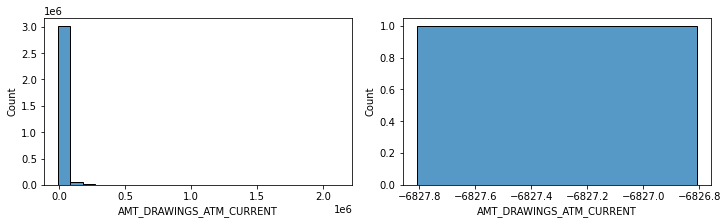

In [200]:
# exploring distribution of some features
fig, axes = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)
g1 = sns.histplot(x='AMT_DRAWINGS_ATM_CURRENT', data=cc, ax=axes[0])
g2 = sns.histplot(x='AMT_DRAWINGS_ATM_CURRENT', data=cc[cc['AMT_DRAWINGS_ATM_CURRENT']<0], ax=axes[1])

In [201]:
cc[cc['AMT_DRAWINGS_ATM_CURRENT']<0]

SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  AMT_BALANCE  AMT_CREDIT_LIMIT_ACTUAL  AMT_DRAWINGS_ATM_CURRENT  AMT_DRAWINGS_CURRENT  AMT_DRAWINGS_OTHER_CURRENT  AMT_DRAWINGS_POS_CURRENT  AMT_INST_MIN_REGULARITY  AMT_PAYMENT_CURRENT  AMT_PAYMENT_TOTAL_CURRENT  AMT_RECEIVABLE_PRINCIPAL  AMT_RECIVABLE  AMT_TOTAL_RECEIVABLE  CNT_DRAWINGS_ATM_CURRENT  CNT_DRAWINGS_CURRENT  CNT_DRAWINGS_OTHER_CURRENT  CNT_DRAWINGS_POS_CURRENT  CNT_INSTALMENT_MATURE_CUM NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF
2047409     1793522      317928             -20          0.0                        0                  -6827.31                   0.0                         0.0                       0.0                  2102.31              2172.69                    2172.69                       0.0            0.0                   0.0                       1.0                     1                         0.0                       0.0                       60.0               Active       0           0

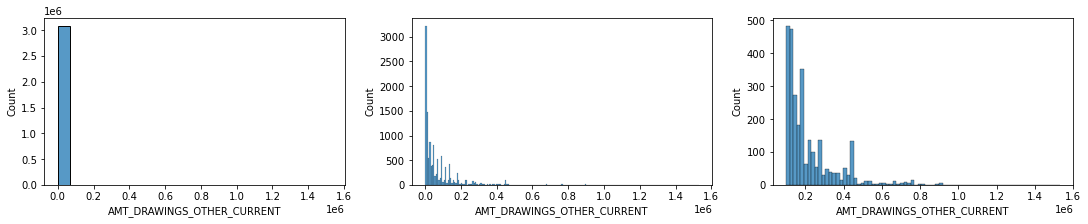

In [207]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3), constrained_layout=True)
g1 = sns.histplot(x='AMT_DRAWINGS_OTHER_CURRENT', data=cc, ax=axes[0])
g2 = sns.histplot(x='AMT_DRAWINGS_OTHER_CURRENT', data=cc[cc['AMT_DRAWINGS_OTHER_CURRENT']>300], ax=axes[1])
g3 = sns.histplot(x='AMT_DRAWINGS_OTHER_CURRENT', data=cc[cc['AMT_DRAWINGS_OTHER_CURRENT']>100000], ax=axes[2])

### preprocessing

In [209]:
# encoding
cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)
check_encoded_cat_cols(cc, cat_cols)

nb of categorical columns created though OHE =  8
--------------------
['NAME_CONTRACT_STATUS_Active', 'NAME_CONTRACT_STATUS_Approved', 'NAME_CONTRACT_STATUS_Completed', 'NAME_CONTRACT_STATUS_Demand', 'NAME_CONTRACT_STATUS_Refused', 'NAME_CONTRACT_STATUS_Sent proposal', 'NAME_CONTRACT_STATUS_Signed', 'NAME_CONTRACT_STATUS_nan']
----------------------------------------------------------------------------------------------------
NAME_CONTRACT_STATUS_Active
Nb of Nan = 0 out of 3840312
Nb of unique values = 2
--------------------
NAME_CONTRACT_STATUS_Approved
Nb of Nan = 0 out of 3840312
Nb of unique values = 2
--------------------
NAME_CONTRACT_STATUS_Completed
Nb of Nan = 0 out of 3840312
Nb of unique values = 2
--------------------
NAME_CONTRACT_STATUS_Demand
Nb of Nan = 0 out of 3840312
Nb of unique values = 2
--------------------
NAME_CONTRACT_STATUS_Refused
Nb of Nan = 0 out of 3840312
Nb of unique values = 2
--------------------
NAME_CONTRACT_STATUS_Sent proposal
Nb of Nan = 0 out 

In [210]:
# General aggregations
cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
cc_agg.columns = pd.Index(['CC_' + e[0] + "__" + e[1].lower() for e in cc_agg.columns.tolist()])

In [211]:
cc_agg.shape

(103558, 140)

In [212]:
check_nan(cc_agg)

nan in CC_MONTHS_BALANCE__min : 0 (ratio of 0.0 )
nan in CC_MONTHS_BALANCE__max : 0 (ratio of 0.0 )
nan in CC_MONTHS_BALANCE__mean : 0 (ratio of 0.0 )
nan in CC_MONTHS_BALANCE__sum : 0 (ratio of 0.0 )
nan in CC_MONTHS_BALANCE__var : 692 (ratio of 0.01 )
nan in CC_AMT_BALANCE__min : 0 (ratio of 0.0 )
nan in CC_AMT_BALANCE__max : 0 (ratio of 0.0 )
nan in CC_AMT_BALANCE__mean : 0 (ratio of 0.0 )
nan in CC_AMT_BALANCE__sum : 0 (ratio of 0.0 )
nan in CC_AMT_BALANCE__var : 692 (ratio of 0.01 )
nan in CC_AMT_CREDIT_LIMIT_ACTUAL__min : 0 (ratio of 0.0 )
nan in CC_AMT_CREDIT_LIMIT_ACTUAL__max : 0 (ratio of 0.0 )
nan in CC_AMT_CREDIT_LIMIT_ACTUAL__mean : 0 (ratio of 0.0 )
nan in CC_AMT_CREDIT_LIMIT_ACTUAL__sum : 0 (ratio of 0.0 )
nan in CC_AMT_CREDIT_LIMIT_ACTUAL__var : 692 (ratio of 0.01 )
nan in CC_AMT_DRAWINGS_ATM_CURRENT__min : 31364 (ratio of 0.3 )
nan in CC_AMT_DRAWINGS_ATM_CURRENT__max : 31364 (ratio of 0.3 )
nan in CC_AMT_DRAWINGS_ATM_CURRENT__mean : 31364 (ratio of 0.3 )
nan in CC_AMT_D

In [213]:
# General aggregations v2
def std(x): return np.nanstd(x)
cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', std])
cc_agg.columns = pd.Index(['CC_' + e[0] + "__" + e[1].lower() for e in cc_agg.columns.tolist()])
print(cc_agg.shape)
check_nan(cc_agg)

C:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


(103558, 140)
nan in CC_MONTHS_BALANCE__min : 0 (ratio of 0.0 )
nan in CC_MONTHS_BALANCE__max : 0 (ratio of 0.0 )
nan in CC_MONTHS_BALANCE__mean : 0 (ratio of 0.0 )
nan in CC_MONTHS_BALANCE__sum : 0 (ratio of 0.0 )
nan in CC_MONTHS_BALANCE__std : 0 (ratio of 0.0 )
nan in CC_AMT_BALANCE__min : 0 (ratio of 0.0 )
nan in CC_AMT_BALANCE__max : 0 (ratio of 0.0 )
nan in CC_AMT_BALANCE__mean : 0 (ratio of 0.0 )
nan in CC_AMT_BALANCE__sum : 0 (ratio of 0.0 )
nan in CC_AMT_BALANCE__std : 0 (ratio of 0.0 )
nan in CC_AMT_CREDIT_LIMIT_ACTUAL__min : 0 (ratio of 0.0 )
nan in CC_AMT_CREDIT_LIMIT_ACTUAL__max : 0 (ratio of 0.0 )
nan in CC_AMT_CREDIT_LIMIT_ACTUAL__mean : 0 (ratio of 0.0 )
nan in CC_AMT_CREDIT_LIMIT_ACTUAL__sum : 0 (ratio of 0.0 )
nan in CC_AMT_CREDIT_LIMIT_ACTUAL__std : 0 (ratio of 0.0 )
nan in CC_AMT_DRAWINGS_ATM_CURRENT__min : 31364 (ratio of 0.3 )
nan in CC_AMT_DRAWINGS_ATM_CURRENT__max : 31364 (ratio of 0.3 )
nan in CC_AMT_DRAWINGS_ATM_CURRENT__mean : 31364 (ratio of 0.3 )
nan in CC_

In [214]:
# Count credit card lines
cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()

In [216]:
# look at final df
simplified_analyse_col_distr(cc_agg)

df shape = (103558, 141)
nb of duplicates = 17832
----------------------------------------
----------------------------------------
CC_MONTHS_BALANCE__min  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 103558
--------------------
min = -96
max = -1
mean = -37.534531373722935
std = 33.3796603167083
nan_std = 33.37966031670725
Relative_nan_std = -88.93053701497811
----------------------------------------
----------------------------------------
CC_MONTHS_BALANCE__max  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 103558
--------------------
min = -12
max = -1
mean = -1.518965217559242
std = 0.734813625527533
nan_std = 0.7348136255274118
Relative_nan_std = -48.3759349478819
----------------------------------------
----------------------------------------
CC_MONTHS_BALANCE__mean  -- dtype =  float64
--------------------
Nb of Nan = 0 out of 103558
--------------------
min = -50.17977528089887
max = -1.0
mean = -19.50555265824665
std = 16.666490494462153
nan_std 

Relative_nan_std = 355.78220942877783
----------------------------------------
----------------------------------------
CC_AMT_DRAWINGS_POS_CURRENT__std  -- dtype =  float64
--------------------
Nb of Nan = 31364 out of 103558
--------------------
min = 0.0
max = 571716.2398543834
mean = 11608.053870910757
std = 22882.004451916953
nan_std = 22882.00445190709
Relative_nan_std = 197.1217975585755
----------------------------------------
----------------------------------------
CC_AMT_INST_MIN_REGULARITY__min  -- dtype =  float64
--------------------
Nb of Nan = 0 out of 103558
--------------------
min = 0.0
max = 34098.39
mean = 231.8536579984161
std = 1352.602688692011
nan_std = 1352.602688692951
Relative_nan_std = 583.3863913858073
----------------------------------------
----------------------------------------
CC_AMT_INST_MIN_REGULARITY__max  -- dtype =  float64
--------------------
Nb of Nan = 0 out of 103558
--------------------
min = 0.0
max = 202882.005
mean = 7149.6988911045255


Relative_nan_std = 162.48824271338637
----------------------------------------
----------------------------------------
CC_CNT_DRAWINGS_ATM_CURRENT__std  -- dtype =  float64
--------------------
Nb of Nan = 31364 out of 103558
--------------------
min = 0.0
max = 18.619546181365433
mean = 0.9201927951065395
std = 0.9537467581117209
nan_std = 0.9537467581118397
Relative_nan_std = 103.64640575146161
----------------------------------------
----------------------------------------
CC_CNT_DRAWINGS_CURRENT__min  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 103558
--------------------
min = 0
max = 78
mean = 0.09523165762181579
std = 1.010914124256963
nan_std = 1.0109141242563398
Relative_nan_std = 1061.531584665768
----------------------------------------
----------------------------------------
CC_CNT_DRAWINGS_CURRENT__max  -- dtype =  int64
--------------------
Nb of Nan = 0 out of 103558
--------------------
min = 0
max = 165
mean = 6.748353579636532
std = 10.5843045311048

Nb of Nan = 0 out of 103558
--------------------
min = 0.0
max = 0.5
mean = 0.047955452254802404
std = 0.13129728771099283
nan_std = 0.1312972877110922
Relative_nan_std = 273.79011465363396
----------------------------------------
----------------------------------------
CC_NAME_CONTRACT_STATUS_Demand__min  -- dtype =  uint8
--------------------
Nb of Nan = 0 out of 103558
--------------------
----------------------------------------
----------------------------------------
CC_NAME_CONTRACT_STATUS_Demand__max  -- dtype =  uint8
--------------------
Nb of Nan = 0 out of 103558
--------------------
----------------------------------------
----------------------------------------
CC_NAME_CONTRACT_STATUS_Demand__mean  -- dtype =  float64
--------------------
Nb of Nan = 0 out of 103558
--------------------
min = 0.0
max = 1.0
mean = 0.00014348939159403553
std = 0.01052484661679591
nan_std = 0.010524846616798669
Relative_nan_std = 7334.930129591656
----------------------------------------
-

In [217]:
# are duplicates real ones? ==> no, they concern different SK_ID_CURR
cc_agg[cc_agg.duplicated()==True].index.nunique()

17832

In [218]:
cc_agg.head(10)

CC_MONTHS_BALANCE__min  CC_MONTHS_BALANCE__max  CC_MONTHS_BALANCE__mean  CC_MONTHS_BALANCE__sum  CC_MONTHS_BALANCE__std  CC_AMT_BALANCE__min  CC_AMT_BALANCE__max  CC_AMT_BALANCE__mean  CC_AMT_BALANCE__sum  CC_AMT_BALANCE__std  CC_AMT_CREDIT_LIMIT_ACTUAL__min  CC_AMT_CREDIT_LIMIT_ACTUAL__max  CC_AMT_CREDIT_LIMIT_ACTUAL__mean  CC_AMT_CREDIT_LIMIT_ACTUAL__sum  CC_AMT_CREDIT_LIMIT_ACTUAL__std  CC_AMT_DRAWINGS_ATM_CURRENT__min  CC_AMT_DRAWINGS_ATM_CURRENT__max  \
SK_ID_CURR                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
100006                          -6                      -1                     -3.5                     -21                1.707825                  0.0                0.000              0.000000                0.000             0.000000                           270000                           270000                     270000.000000                          1620000                         0.000000                               NaN                               NaN   
100011                         -75                      -2                    -38.5                   -2849               21.360009                  0.0           189000.000          54482.111149          4031676.225         67665.353363                            90000                           180000                     164189.189189                         12150000                     34248.959612                               0.0                          180000.0   
100013                         -96                      -1                    -48.5                   -4656               27.711309                  0.0           161420.220          18159.919219          1743352.245         43011.622650                            45000                           157500                     131718.750000                         12645000                     47283.377348                               0.0                          157500.0   
100021                         -18                      -2                    -10.0                    -170                4.898979                  0.0                0.000              0.000000                0.000             0.000000                           675000                           675000                     675000.000000                         11475000                         0.000000                               NaN                               NaN   
100023                         -11                      -4                     -7.5                     -60                2.291288                  0.0                0.000              0.000000                0.000             0.000000                            45000                           225000                     135000.000000                          1080000                     90000.000000                               NaN                               NaN   
100028                         -49                      -1                    -25.0                   -1225               14.142136                  0.0            37335.915           8085.058163           396167.850          7813.823708                           225000                           225000                     225000.000000                         11025000                         0.000000                               0.0                           18000.0   
100036                         -13                      -2                     -7.5                     -90                3.452053                  0.0                0.000              0.000000                0

In [219]:
del cc
gc.collect()

152164

### full and clean code to preprocess 'Credit_card_balance' Data

In [24]:
def credit_card_balance(num_rows=None, nan_as_category=True):
    cc = pd.read_csv(path+'credit_card_balance.csv', nrows=num_rows)
    print('cc shape:', cc.shape)
    
    # OHE encoding of the categorical feature
    cc, cat_cols = one_hot_encoder(cc, nan_as_category)
    
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
    def std(x): return np.nanstd(x)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', std])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "__" + e[1].lower() for e in cc_agg.columns.tolist()])
    
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    
    del cc
    gc.collect()
    return cc_agg

In [221]:
# testing it
num_rows = 10000
cc_agg = credit_card_balance(num_rows)
print(cc_agg.shape)
cc_agg.head(2)

cc shape: (10000, 23)


C:\Users\user\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


(9520, 131)


CC_MONTHS_BALANCE__min  CC_MONTHS_BALANCE__max  CC_MONTHS_BALANCE__mean  CC_MONTHS_BALANCE__sum  CC_MONTHS_BALANCE__std  CC_AMT_BALANCE__min  CC_AMT_BALANCE__max  CC_AMT_BALANCE__mean  CC_AMT_BALANCE__sum  CC_AMT_BALANCE__std  CC_AMT_CREDIT_LIMIT_ACTUAL__min  CC_AMT_CREDIT_LIMIT_ACTUAL__max  CC_AMT_CREDIT_LIMIT_ACTUAL__mean  CC_AMT_CREDIT_LIMIT_ACTUAL__sum  CC_AMT_CREDIT_LIMIT_ACTUAL__std  CC_AMT_DRAWINGS_ATM_CURRENT__min  CC_AMT_DRAWINGS_ATM_CURRENT__max  \
SK_ID_CURR                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
100048                          -2                      -2                     -2.0                      -2                     0.0              27302.4              27302.4               27302.4              27302.4                  0.0                           225000                           225000                            225000                           225000                              0.0                           27000.0                           27000.0   
100059                          -4                      -4                     -4.0                      -4                     0.0                  0.0                  0.0                   0.0                  0.0                  0.0                                0                                0                                 0                                0                              0.0                               NaN                               NaN   

            CC_AMT_DRAWINGS_ATM_CURRENT__mean  CC_AMT_DRAWINGS_ATM_CURRENT__sum  CC_AMT_DRAWINGS_ATM_CURRENT__std  CC_AMT_DRAWINGS_CURRENT__min  CC_AMT_DRAWINGS_CURRENT__max  CC_AMT_DRAWINGS_CURRENT__mean  CC_AMT_DRAWINGS_CURRENT__sum  CC_AMT_DRAWINGS_CURRENT__std  CC_AMT_DRAWINGS_OTHER_CURRENT__min  CC_AMT_DRAWINGS_OTHER_CURRENT__max  CC_AMT_DRAWINGS_OTHER_CURRENT__mean  CC_AMT_DRAWINGS_OTHER_CURRENT__sum  CC_AMT_DRAWINGS_OTHER_CURRENT__std  CC_AMT_DRAWINGS_POS_CURRENT__min  \
SK_ID_CURR                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
100048                                27000.0                           27000.0                               0.0                       27000.0                       27000.0                        27000.0                       27000.0                           0.0                                 0.0                                 0.0                                  0.0                                 0.0                                 0.0                               0.0   
100059                                    NaN                               0.0                               NaN                           0.0                           0.0                            0.0                           0.0                           0.0                                 NaN                                 NaN                                  NaN                                 0.0                                 NaN                               NaN   

            CC_AMT_DRAWINGS_POS_CURRENT__max  CC_AMT_DRAWINGS_POS_CURRENT__mean  CC_AMT_DRAWINGS_POS_CURRENT__sum  CC_AMT_DRAWINGS_POS_CURRENT__std  CC_AMT_INST_MIN_REGULARITY__m

In [25]:
num_rows = None
cc_agg = credit_card_balance(num_rows)
print(cc_agg.shape)
cc_agg.head(2)

cc shape: (3840312, 23)
(103558, 141)


CC_MONTHS_BALANCE__min  CC_MONTHS_BALANCE__max  CC_MONTHS_BALANCE__mean  CC_MONTHS_BALANCE__sum  CC_MONTHS_BALANCE__std  CC_AMT_BALANCE__min  CC_AMT_BALANCE__max  CC_AMT_BALANCE__mean  CC_AMT_BALANCE__sum  CC_AMT_BALANCE__std  CC_AMT_CREDIT_LIMIT_ACTUAL__min  CC_AMT_CREDIT_LIMIT_ACTUAL__max  CC_AMT_CREDIT_LIMIT_ACTUAL__mean  CC_AMT_CREDIT_LIMIT_ACTUAL__sum  CC_AMT_CREDIT_LIMIT_ACTUAL__std  CC_AMT_DRAWINGS_ATM_CURRENT__min  CC_AMT_DRAWINGS_ATM_CURRENT__max  \
SK_ID_CURR                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
100006                          -6                      -1                     -3.5                     -21                1.707825                  0.0                  0.0              0.000000                0.000             0.000000                           270000                           270000                     270000.000000                          1620000                         0.000000                               NaN                               NaN   
100011                         -75                      -2                    -38.5                   -2849               21.360009                  0.0             189000.0          54482.111149          4031676.225         67665.353363                            90000                           180000                     164189.189189                         12150000                     34248.959612                               0.0                          180000.0   

            CC_AMT_DRAWINGS_ATM_CURRENT__mean  CC_AMT_DRAWINGS_ATM_CURRENT__sum  CC_AMT_DRAWINGS_ATM_CURRENT__std  CC_AMT_DRAWINGS_CURRENT__min  CC_AMT_DRAWINGS_CURRENT__max  CC_AMT_DRAWINGS_CURRENT__mean  CC_AMT_DRAWINGS_CURRENT__sum  CC_AMT_DRAWINGS_CURRENT__std  CC_AMT_DRAWINGS_OTHER_CURRENT__min  CC_AMT_DRAWINGS_OTHER_CURRENT__max  CC_AMT_DRAWINGS_OTHER_CURRENT__mean  CC_AMT_DRAWINGS_OTHER_CURRENT__sum  CC_AMT_DRAWINGS_OTHER_CURRENT__std  CC_AMT_DRAWINGS_POS_CURRENT__min  \
SK_ID_CURR                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
100006                                    NaN                               0.0                               NaN                           0.0                           0.0                       0.000000                           0.0                      0.000000                                 NaN                                 NaN                                  NaN                                 0.0                                 NaN                               NaN   
100011                            2432.432432                          180000.0                      20782.711813                           0.0                      180000.0                    2432.432432                      180000.0                  20782.711813                                 0.0                                 0.0                                  0.0                                 0.0                                 0.0                               0.0   

            CC_AMT_DRAWINGS_POS_CURRENT__max  CC_AMT_DRAWINGS_POS_CURRENT__mean  CC_AMT_DRAWINGS_POS_CURRENT__sum  CC_AMT_DRAWINGS_POS_CURRENT__std  CC_AMT_INST_MIN_REGULARITY__m

# Combining all previously preprocessed datasets

In [26]:
df1 = df.copy(deep=True)

In [27]:
df.shape

(307507, 188)

In [28]:
# nb of features to be joinded:
188+121+284+18+26+141

778

In [29]:
# bureau_agg on df ==> 121 features added: ok
df = df.join(bureau_agg, how='left', on='SK_ID_CURR')
print(df.shape)

(307507, 309)


In [30]:
del bureau_agg
gc.collect()

20

In [31]:
# prev_agg on new df ==> 284 features added: ok
df = df.join(prev_agg, how='left', on='SK_ID_CURR')
print(df.shape)

(307507, 593)


In [32]:
del prev_agg
gc.collect()

20

In [36]:
# pos_agg on new df ==> 18 features added: ok
df = df.join(pos_agg, how='left', on='SK_ID_CURR')
print(df.shape)

(307507, 611)


In [37]:
del pos_agg
gc.collect()

20

In [38]:
# ins_agg on new df ==> 26 features added: ok
df = df.join(ins_agg, how='left', on='SK_ID_CURR')
print(df.shape)

(307507, 637)


In [39]:
del ins_agg
gc.collect()

20

In [40]:
# cc_agg on new df ==> 141 features added: ok
df = df.join(cc_agg, how='left', on='SK_ID_CURR')
print(df.shape)

(307507, 778)


In [41]:
del cc_agg
gc.collect()

20

In [256]:
# Exporting combined_df
df.to_csv('combined_df.csv')

# Further preprocessing / analysis of combined preprocessed datasets (i.e. df)

In [194]:
df = pd.read_csv('combined_df.csv')

In [4]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307507 entries, 0 to 307506
Columns: 779 entries, Unnamed: 0 to CC_COUNT
dtypes: float64(671), int64(108)
memory usage: 1.8 GB


In [5]:
df.head(0)

Empty DataFrame
Columns: [Unnamed: 0, SK_ID_CURR, TARGET, CODE_GENDER, FLAG_OWN_CAR, FLAG_OWN_REALTY, CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE, REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, OWN_CAR_AGE, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_PHONE, FLAG_EMAIL, CNT_FAM_MEMBERS, REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, REG_REGION_NOT_LIVE_REGION, REG_REGION_NOT_WORK_REGION, LIVE_REGION_NOT_WORK_REGION, REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY, EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, APARTMENTS_AVG, BASEMENTAREA_AVG, YEARS_BEGINEXPLUATATION_AVG, YEARS_BUILD_AVG, COMMONAREA_AVG, ELEVATORS_AVG, ENTRANCES_AVG, FLOORSMAX_AVG, FLOORSMIN_AVG, LANDAREA_AVG, LIVINGAPARTMENTS_AVG, LIVINGAREA_AVG, NONLIVINGAPARTMENTS_AVG, NONLIVINGAREA_AVG, APARTMENTS_MODE, BASEMENTAREA_MODE, YEARS_BEGINEXPLUATATION_MODE, YEARS_BUILD_MODE, COMMONAREA_MODE, ELEVATORS_MODE, ENTRANCES_MODE, FLOORSMAX_MODE, FLOORSMIN_MODE, LANDAREA_MODE, LIVINGAPARTMENTS_MODE, LIVINGAREA_MODE, NONLIVINGAPARTMENTS_MODE, NONLIVINGAREA_MODE, APARTMENTS_MEDI, BASEMENTAREA_MEDI, YEARS_BEGINEXPLUATATION_MEDI, YEARS_BUILD_MEDI, COMMONAREA_MEDI, ELEVATORS_MEDI, ENTRANCES_MEDI, FLOORSMAX_MEDI, FLOORSMIN_MEDI, LANDAREA_MEDI, LIVINGAPARTMENTS_MEDI, LIVINGAREA_MEDI, NONLIVINGAPARTMENTS_MEDI, NONLIVINGAREA_MEDI, TOTALAREA_MODE, OBS_30_CNT_SOCIAL_CIRCLE, DEF_30_CNT_SOCIAL_CIRCLE, OBS_60_CNT_SOCIAL_CIRCLE, DEF_60_CNT_SOCIAL_CIRCLE, DAYS_LAST_PHONE_CHANGE, AMT_REQ_CREDIT_BUREAU_HOUR, AMT_REQ_CREDIT_BUREAU_DAY, AMT_REQ_CREDIT_BUREAU_WEEK, AMT_REQ_CREDIT_BUREAU_MON, AMT_REQ_CREDIT_BUREAU_QRT, AMT_REQ_CREDIT_BUREAU_YEAR, WEEKDAY_APPR_PROCESS_START_SIN, WEEKDAY_APPR_PROCESS_START_COS, HOUR_APPR_PROCESS_START_SIN, HOUR_APPR_PROCESS_START_COS, NEW_DAYS_EMPLOYED_PERC, NEW_INCOME_CREDIT_PERC, NEW_INCOME_PER_PERSON, NEW_ANNUITY_INCOME_PERC, NEW_PAYMENT_RATE, NEW_INC_PER_CHLD, NEW_LVR, NEW_LVR_RISK, NEW_EXT_SOURCE_MEAN, ...]
Index: []

[0 rows x 779 columns]

In [195]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.shape

(307507, 778)

In [8]:
# check duplicates
df.duplicated().sum()

0

In [9]:
df.describe(include='all')

SK_ID_CURR        TARGET    CODE_GENDER   FLAG_OWN_CAR  \
count  307507.000000  307507.00000  307507.000000  307507.000000   
mean   278181.527256       0.08073       0.658352       0.340106   
std    102790.132982       0.27242       0.474263       0.473745   
min    100002.000000       0.00000       0.000000       0.000000   
25%    189146.500000       0.00000       0.000000       0.000000   
50%    278203.000000       0.00000       1.000000       0.000000   
75%    367143.500000       0.00000       1.000000       1.000000   
max    456255.000000       1.00000       1.000000       1.000000   

       FLAG_OWN_REALTY   CNT_CHILDREN  AMT_INCOME_TOTAL    AMT_CREDIT  \
count    307507.000000  307507.000000      3.075070e+05  3.075070e+05   
mean          0.306331       0.417047      1.687977e+05  5.990286e+05   
std           0.460970       0.722119      2.371246e+05  4.024926e+05   
min           0.000000       0.000000      2.565000e+04  4.500000e+04   
25%           0.000000       0.000000      1.125000e+05  2.700000e+05   
50%           0.000000       0.000000      1.471500e+05  5.135310e+05   
75%           1.000000       1.000000      2.025000e+05  8.086500e+05   
max           1.000000      19.000000      1.170000e+08  4.050000e+06   

         AMT_ANNUITY  AMT_GOODS_PRICE  ...  \
count  307495.000000     3.072290e+05  ...   
mean    27108.666786     5.383977e+05  ...   
std     14493.798379     3.694472e+05  ...   
min      1615.500000     4.050000e+04  ...   
25%     16524.000000     2.385000e+05  ...   
50%     24903.000000     4.500000e+05  ...   
75%     34596.000000     6.795000e+05  ...   
max    258025.500000     4.050000e+06  ...   

       CC_NAME_CONTRACT_STATUS_Signed__max  \
count                         86905.000000   
mean                              0.049376   
std                               0.216653   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                               0.000000   
max                               1.000000   

       CC_NAME_CONTRACT_STATUS_Signed__mean  \
count                          86905.000000   
mean                               0.003738   
std                                0.031882   
min                                0.000000   
25%                                0.000000   
50%                                0.000000   
75%                                0.000000   
max                                1.000000   

       CC_NAME_CONTRACT_STATUS_Signed__sum  \
count                         86905.000000   
mean                              0.114366   
std                               1.323208   
min                               0.000000   
25%                               0.000000   
50%                               0.000000   
75%                               0.000000   
max                              62.000000   

       CC_NAME_CONTRACT_STATUS_Signed__std  CC_NAME_CONTRACT_STATUS_nan__min  \
count                         86905.000000                           86905.0   
mean                              0.010453                               0.0   
std                               0.050976                               0.0   
min                               0.000000                               0.0   
25%                               0.000000                               0.0   
50%                               0.000000                               0.0   
75%                               0.000000                               0.0   
max                               0.500000                               0.0   

       CC_NAME_CONTRACT_STATUS_nan__max  CC_NAME_CONTRACT_STATUS_nan__mean  \
count                           86905.0                            86905.0   
mean                                0.0                                0.0   
std                                 0.0                                0.0   
min                                 0

## Dropping features with single unique value, with too many NaN

In [5]:
col_with_single_val = []
col_nan_sup_80 = []
col_nan_sup_75 = []
col_nan_sup_70 = []
col_nan_sup_60 = []
col_nan_sup_50 = []
for col in df.columns.tolist():
    if np.min(df[col]) == np.max(df[col]):
        col_with_single_val.append(col)
    if df[col].isna().sum()/df.shape[0] >= 0.8:
        col_nan_sup_80.append(col)
    if df[col].isna().sum()/df.shape[0] >= 0.75:
        col_nan_sup_75.append(col)
    if df[col].isna().sum()/df.shape[0] >= 0.7:
        col_nan_sup_70.append(col)
    if df[col].isna().sum()/df.shape[0] >= 0.6:
        col_nan_sup_60.append(col)
    if df[col].isna().sum()/df.shape[0] >= 0.5:
        col_nan_sup_50.append(col)
print('nb features with single unique value =', len(col_with_single_val))
print('nb features with more than 80% of nan =', len(col_nan_sup_80))
print('nb features with more than 75% of nan =', len(col_nan_sup_75))
print('nb features with more than 70% of nan =', len(col_nan_sup_70))
print('nb features with more than 60% of nan =', len(col_nan_sup_60))
print('nb features with more than 50% of nan =', len(col_nan_sup_50))
print('-' * 50)
print('List of features with single unique value:\n', col_with_single_val)
print('-' * 50)
print('List of features with more than 80% of nan:\n', col_nan_sup_75)

nb features with single unique value = 35
nb features with more than 80% of nan = 36
nb features with more than 75% of nan = 41
nb features with more than 70% of nan = 176
nb features with more than 60% of nan = 224
nb features with more than 50% of nan = 248
--------------------------------------------------
List of features with single unique value:
 ['NAME_CONTRACT_TYPE_nan', 'NAME_INCOME_TYPE_nan', 'NAME_EDUCATION_TYPE_nan', 'NAME_FAMILY_STATUS_nan', 'NAME_HOUSING_TYPE_nan', 'ORGANIZATION_TYPE_nan', 'NEW_AGE_SEGMENT_nan', 'BURO_CREDIT_ACTIVE_nan__mean', 'BURO_CREDIT_CURRENCY_nan__mean', 'BURO_CREDIT_TYPE_nan__mean', 'BURO_Simplified_STATUS_nan__mean__mean', 'PREV_NAME_CONTRACT_TYPE_nan__mean', 'PREV_NAME_CASH_LOAN_PURPOSE_nan__mean', 'PREV_NAME_CONTRACT_STATUS_nan__mean', 'PREV_NAME_PAYMENT_TYPE_nan__mean', 'PREV_CODE_REJECT_REASON_nan__mean', 'PREV_NAME_CLIENT_TYPE_nan__mean', 'PREV_NAME_GOODS_CATEGORY_nan__mean', 'PREV_NAME_PORTFOLIO_nan__mean', 'PREV_NAME_PRODUCT_TYPE_nan__mean'

In [196]:
print('initial df shape:', df.shape)
for col in col_with_single_val:
    df.drop(col, axis=1, inplace=True)
print('df shape after dropping features with single unique values:', df.shape)
for col in col_nan_sup_75:
    df.drop(col, axis=1, inplace=True)
print('df shape after dropping features with more than 75% of NaN:', df.shape)

initial df shape: (307507, 778)
df shape after dropping features with single unique values: (307507, 743)
df shape after dropping features with more than 75% of NaN: (307507, 702)


In [197]:
df1 = df.copy(deep=True)

In [198]:
print(df.shape)
print(df1.shape)

(307507, 702)
(307507, 702)


In [235]:
df = df1.copy(deep=True)

In [236]:
df.shape

(307507, 702)

## Pairs of features highly correlated
* **Finding them**

In [10]:
correl = df.iloc[:,1:].corr()

In [241]:
correl3 = correl.copy(deep=True)

# Remove duplicate and identity entries
correl3.loc[:,:] = np.tril(correl3.values, k=-1)
correl3 = correl3[correl3!=0]

# Filter according to threshold
correl3 = correl3[((correl3 >= 0.9) | (correl3 <= -0.9))]

# Unstack, sort ascending, and reset the index, so features are in columns
# instead of indexes (allowing e.g. a pretty print in Jupyter).
# Also rename these it for good measure.
corr_cols = correl3.unstack().sort_values(ascending=False)\
    .drop_duplicates().dropna().reset_index()\
    .rename(columns={"level_0": "feature_a", "level_1": "feature_b", 0: "correlation"})
corr_cols

feature_a                                     feature_b  correlation
0       BURO_CREDIT_ACTIVE_Active__count__max  BURO_closed_CREDIT_ACTIVE_Active__count__max     1.000000
1                       CC_AMT_RECIVABLE__min                  CC_AMT_TOTAL_RECEIVABLE__min     1.000000
2                       CC_AMT_RECIVABLE__std                  CC_AMT_TOTAL_RECEIVABLE__std     0.999999
3                      CC_AMT_RECIVABLE__mean                 CC_AMT_TOTAL_RECEIVABLE__mean     0.999999
4                       CC_AMT_RECIVABLE__max                  CC_AMT_TOTAL_RECEIVABLE__max     0.999998
..                                        ...                                           ...          ...
327                    CC_MONTHS_BALANCE__min                        CC_MONTHS_BALANCE__std    -0.999751
328                            FLAG_EMP_PHONE                         ORGANIZATION_TYPE_XNA    -0.999868
329                                DAYS_BIRTH                                       NEW_AGE    -1.000000
330  PREV_NAME_CONTRACT_TYPE_Cash loans__mean         PREV_NAME_CASH_LOAN_PURPOSE_XAP__mean    -1.000000
331             NAME_CONTRACT_TYPE_Cash loans            NAME_CONTRACT_TYPE_Revolving loans    -1.000000

[332 rows x 3 columns]

* **Removing one feature from each pair of highly correlated features**

In [237]:
corr_feat_todrop_list = []
corr_feat_kept_list = []
nb_feat_before = df.shape[1]

for i in range(332):
    feat_a = [e for e in df.columns.tolist() if e.startswith(corr_cols.loc[i, 'feature_a']) == True][0]
    feat_b = [e for e in df.columns.tolist() if e.startswith(corr_cols.loc[i, 'feature_b']) == True][0]
    # For each pair of features highly correlated, we will keep the feature with less NaN, and drop the other
    if df[feat_a].isna().sum() < df[feat_b].isna().sum():
        feat_tokeep = feat_a
        feat_todrop = feat_b
    else:
        feat_tokeep = feat_b
        feat_todrop = feat_a
    corr_feat_todrop_list.append(feat_todrop)
    corr_feat_kept_list.append(feat_tokeep)
    # Before doing it, we will replace NaN of the feature to keep 
    # by normalized (relative to feat_tokeep) values from the feature to drop
    # For this we need min and max values of both features:
    min_k = np.min(df[feat_tokeep])
    max_k = np.max(df[feat_tokeep])
    min_d = np.min(df[feat_todrop])
    max_d = np.max(df[feat_todrop])
    # to track nb of nan replaced:
    nb_nan_before = df[feat_tokeep].isna().sum()
    # And we will rename the feature kept by adding to its initial name the dropped feature's name
    # in 2 different ways depending if these features are positively or negatively correlated
    if corr_cols.loc[i, 'correlation'] > 0:
        df[feat_tokeep].fillna((max_k-min_k)*(((df[feat_todrop]-min_d)/(max_d-min_d))+(min_k/(max_k-min_k))),
                            inplace=True)
        df.rename(columns={feat_tokeep: feat_tokeep+'_//_'+feat_todrop}, inplace=True)
        nb_nan_after = df[feat_tokeep+'_//_'+feat_todrop].isna().sum()
    if corr_cols.loc[i, 'correlation'] < 0:
        df[feat_tokeep].fillna((min_k-max_k)*(((df[feat_todrop]-min_d)/(max_d-min_d))+(max_k/(min_k-max_k))),
                            inplace=True)
        df.rename(columns={feat_tokeep: feat_tokeep+'_//INV_'+feat_todrop}, inplace=True)
        nb_nan_after = df[feat_tokeep+'_//INV_'+feat_todrop].isna().sum()
    print('{}-- feature kept: {}, feature to drop: {}, nb nan replaced:{}'.format(i,feat_tokeep, feat_todrop,
                                                                             (nb_nan_before-nb_nan_after)))

# Dropping features to drop
corr_feat_todrop_list = list(dict.fromkeys(corr_feat_todrop_list)) # to remove duplicates from the list of features to drop
corr_feat_todrop_list_ = [col for col in df.columns for e in corr_feat_todrop_list if col.startswith(e) == True]
corr_feat_todrop_list_ = list(dict.fromkeys(corr_feat_todrop_list_))
print('-' * 100)
print('####### dropping {} features now...'.format(len(corr_feat_todrop_list_)))
    # dropping them   
for feat in corr_feat_todrop_list_:
    print(feat)
    df.drop(feat, axis=1, inplace=True)
print('-' * 100)
print('df shape after dropping one feature from each pair of highly correlated (0.9) features:', df.shape)
print('nb of dropped features = ', nb_feat_before - df.shape[1]) # as a reminder at the bottom

0-- feature kept: BURO_CREDIT_ACTIVE_Active__count__max, feature to drop: BURO_closed_CREDIT_ACTIVE_Active__count__max, nb nan replaced:0
1-- feature kept: CC_AMT_TOTAL_RECEIVABLE__min, feature to drop: CC_AMT_RECIVABLE__min, nb nan replaced:0
2-- feature kept: CC_AMT_TOTAL_RECEIVABLE__std, feature to drop: CC_AMT_RECIVABLE__std, nb nan replaced:0
3-- feature kept: CC_AMT_TOTAL_RECEIVABLE__mean, feature to drop: CC_AMT_RECIVABLE__mean, nb nan replaced:0
4-- feature kept: CC_AMT_TOTAL_RECEIVABLE__max, feature to drop: CC_AMT_RECIVABLE__max, nb nan replaced:0
5-- feature kept: CC_AMT_TOTAL_RECEIVABLE__sum, feature to drop: CC_AMT_RECIVABLE__sum, nb nan replaced:0
6-- feature kept: PREV_AMT_APPLICATION__max, feature to drop: PREV_AMT_GOODS_PRICE__max, nb nan replaced:0
7-- feature kept: CC_AMT_RECIVABLE__mean, feature to drop: CC_AMT_BALANCE__mean, nb nan replaced:0
8-- feature kept: CC_AMT_TOTAL_RECEIVABLE__mean_//_CC_AMT_RECIVABLE__mean, feature to drop: CC_AMT_BALANCE__mean, nb nan rep

69-- feature kept: CC_NAME_CONTRACT_STATUS_Sent proposal__sum, feature to drop: CC_NAME_CONTRACT_STATUS_Sent proposal__mean, nb nan replaced:0
70-- feature kept: LANDAREA_MEDI, feature to drop: LANDAREA_AVG, nb nan replaced:0
71-- feature kept: CC_SK_DPD__sum, feature to drop: CC_SK_DPD__mean, nb nan replaced:0
72-- feature kept: NONLIVINGAPARTMENTS_MEDI, feature to drop: NONLIVINGAPARTMENTS_AVG, nb nan replaced:0
73-- feature kept: NONLIVINGAREA_MEDI, feature to drop: NONLIVINGAREA_AVG, nb nan replaced:0
74-- feature kept: CC_NAME_CONTRACT_STATUS_Active__sum, feature to drop: CC_MONTHS_BALANCE__std, nb nan replaced:0
75-- feature kept: prevREFUSED_AMT_CREDIT__max, feature to drop: prevREFUSED_AMT_GOODS_PRICE__max, nb nan replaced:0
76-- feature kept: CC_COUNT_//_CC_MONTHS_BALANCE__std, feature to drop: CC_NAME_CONTRACT_STATUS_Active__sum_//_CC_MONTHS_BALANCE__std, nb nan replaced:0
77-- feature kept: PREV_DAYS_DECISION__min, feature to drop: prevAPPROVED_DAYS_DECISION__min, nb nan rep

141-- feature kept: CC_AMT_INST_MIN_REGULARITY__sum, feature to drop: CC_AMT_BALANCE__sum, nb nan replaced:0
142-- feature kept: YEARS_BEGINEXPLUATATION_MODE, feature to drop: YEARS_BEGINEXPLUATATION_AVG, nb nan replaced:0
143-- feature kept: CC_AMT_RECEIVABLE_PRINCIPAL__sum_//_CC_AMT_BALANCE__sum, feature to drop: CC_AMT_INST_MIN_REGULARITY__sum_//_CC_AMT_BALANCE__sum, nb nan replaced:0
144-- feature kept: CC_CNT_INSTALMENT_MATURE_CUM__sum, feature to drop: CC_CNT_INSTALMENT_MATURE_CUM__mean, nb nan replaced:0
145-- feature kept: CC_CNT_INSTALMENT_MATURE_CUM__mean, feature to drop: CC_CNT_INSTALMENT_MATURE_CUM__max, nb nan replaced:0
146-- feature kept: LIVINGAPARTMENTS_MODE, feature to drop: LIVINGAPARTMENTS_AVG, nb nan replaced:0
147-- feature kept: NONLIVINGAPARTMENTS_MODE, feature to drop: NONLIVINGAPARTMENTS_AVG, nb nan replaced:0
148-- feature kept: PREV_RATE_DOWN_PAYMENT__mean, feature to drop: prevAPPROVED_RATE_DOWN_PAYMENT__mean, nb nan replaced:0
149-- feature kept: CC_SK_DP

200-- feature kept: INSTAL_PAYMENT_PERC__mean, feature to drop: INSTAL_PAYMENT_PERC__std, nb nan replaced:0
201-- feature kept: CC_AMT_RECIVABLE__max_//_CC_AMT_BALANCE__max_//_CC_AMT_RECEIVABLE_PRINCIPAL__max_//_CC_AMT_INST_MIN_REGULARITY__max, feature to drop: CC_AMT_INST_MIN_REGULARITY__std_//_CC_AMT_BALANCE__std_//_CC_AMT_INST_MIN_REGULARITY__max_//_CC_AMT_BALANCE__max, nb nan replaced:0
202-- feature kept: CC_AMT_INST_MIN_REGULARITY__std_//_CC_AMT_BALANCE__std_//_CC_AMT_INST_MIN_REGULARITY__max_//_CC_AMT_BALANCE__max, feature to drop: CC_AMT_BALANCE__max, nb nan replaced:0
203-- feature kept: prevREFUSED_DAYS_DECISION__mean, feature to drop: prevREFUSED_DAYS_DECISION__max, nb nan replaced:0
204-- feature kept: CC_AMT_RECEIVABLE_PRINCIPAL__max_//_CC_AMT_BALANCE__max_//_CC_AMT_INST_MIN_REGULARITY__max_//_CC_AMT_BALANCE__max, feature to drop: CC_AMT_INST_MIN_REGULARITY__std_//_CC_AMT_BALANCE__std_//_CC_AMT_INST_MIN_REGULARITY__max_//_CC_AMT_BALANCE__max_//_CC_AMT_BALANCE__max, nb nan 

229-- feature kept: CC_AMT_RECEIVABLE_PRINCIPAL__max_//_CC_AMT_BALANCE__max_//_CC_AMT_INST_MIN_REGULARITY__max_//_CC_AMT_BALANCE__max_//_CC_AMT_INST_MIN_REGULARITY__std_//_CC_AMT_BALANCE__std_//_CC_AMT_INST_MIN_REGULARITY__max_//_CC_AMT_BALANCE__max_//_CC_AMT_BALANCE__max, feature to drop: CC_AMT_BALANCE__std_//_CC_AMT_BALANCE__max, nb nan replaced:0
230-- feature kept: prevREFUSED_AMT_APPLICATION__min, feature to drop: prevREFUSED_AMT_GOODS_PRICE__min, nb nan replaced:0
231-- feature kept: CC_NAME_CONTRACT_STATUS_Completed__std_//_CC_NAME_CONTRACT_STATUS_Completed__max, feature to drop: CC_NAME_CONTRACT_STATUS_Active__std, nb nan replaced:0
232-- feature kept: prevREFUSED_AMT_CREDIT__min_//_prevREFUSED_AMT_APPLICATION__min, feature to drop: prevREFUSED_AMT_GOODS_PRICE__min, nb nan replaced:0
233-- feature kept: prevREFUSED_AMT_GOODS_PRICE__mean, feature to drop: prevREFUSED_AMT_GOODS_PRICE__max, nb nan replaced:0
234-- feature kept: prevREFUSED_AMT_APPLICATION__max_//_prevREFUSED_AMT_

282-- feature kept: APARTMENTS_MODE_//_APARTMENTS_AVG_//_LIVINGAPARTMENTS_MODE_//_LIVINGAPARTMENTS_AVG_//_LIVINGAPARTMENTS_MEDI_//_LIVINGAPARTMENTS_AVG_//_LIVINGAPARTMENTS_MODE, feature to drop: LIVINGAPARTMENTS_AVG, nb nan replaced:0
283-- feature kept: CC_AMT_TOTAL_RECEIVABLE__std_//_CC_AMT_RECIVABLE__std_//_CC_AMT_BALANCE__std_//_CC_AMT_RECEIVABLE_PRINCIPAL__std_//_CC_AMT_INST_MIN_REGULARITY__std_//_CC_AMT_RECIVABLE__max_//_CC_AMT_BALANCE__max_//_CC_AMT_RECEIVABLE_PRINCIPAL__max_//_CC_AMT_INST_MIN_REGULARITY__max_//_CC_AMT_INST_MIN_REGULARITY__std_//_CC_AMT_BALANCE__std_//_CC_AMT_INST_MIN_REGULARITY__max_//_CC_AMT_BALANCE__max_//_CC_AMT_TOTAL_RECEIVABLE__max_//_CC_AMT_RECIVABLE__max_//_CC_AMT_BALANCE__max_//_CC_AMT_RECEIVABLE_PRINCIPAL__max_//_CC_AMT_INST_MIN_REGULARITY__max_//_CC_AMT_INST_MIN_REGULARITY__std_//_CC_AMT_BALANCE__std_//_CC_AMT_INST_MIN_REGULARITY__max_//_CC_AMT_BALANCE__max_//_CC_AMT_BALANCE__max_//_CC_AMT_RECEIVABLE_PRINCIPAL__max_//_CC_AMT_BALANCE__max_//_CC_AMT_INS

<ipython-input-237-b816f9dad19e>:34: RuntimeWarning: invalid value encountered in double_scalars
  df[feat_tokeep].fillna((min_k-max_k)*(((df[feat_todrop]-min_d)/(max_d-min_d))+(max_k/(min_k-max_k))),


303-- feature kept: EMERGENCYSTATE_MODE_No_//_HOUSETYPE_MODE_block of flats_//INV_WALLSMATERIAL_MODE_nan_//_HOUSETYPE_MODE_nan, feature to drop: HOUSETYPE_MODE_nan, nb nan replaced:0
304-- feature kept: PREV_CODE_REJECT_REASON_XAP__mean, feature to drop: PREV_NAME_CONTRACT_STATUS_Refused__mean, nb nan replaced:0
305-- feature kept: WALLSMATERIAL_MODE_nan_//_HOUSETYPE_MODE_nan, feature to drop: HOUSETYPE_MODE_block of flats, nb nan replaced:0
306-- feature kept: CC_NAME_CONTRACT_STATUS_Completed__mean, feature to drop: CC_NAME_CONTRACT_STATUS_Active__mean, nb nan replaced:0
307-- feature kept: NEW_DAYS_EMPLOYED_PERC, feature to drop: DAYS_EMPLOYED, nb nan replaced:0
308-- feature kept: PREV_NAME_PORTFOLIO_POS__mean_//_PREV_NAME_CONTRACT_TYPE_Consumer loans__mean, feature to drop: PREV_NAME_GOODS_CATEGORY_XNA__mean, nb nan replaced:0
309-- feature kept: BURO_CREDIT_CURRENCY_currency 2__mean, feature to drop: BURO_CREDIT_CURRENCY_currency 1__mean, nb nan replaced:0
310-- feature kept: CC_

LIVINGAREA_MEDI_//_LIVINGAREA_AVG_//_LIVINGAREA_MODE_//_APARTMENTS_MEDI_//_APARTMENTS_AVG_//_APARTMENTS_MODE_//_LIVINGAPARTMENTS_MEDI_//_LIVINGAPARTMENTS_AVG_//_LIVINGAPARTMENTS_MODE_//_LIVINGAPARTMENTS_AVG_//_LIVINGAPARTMENTS_MODE_//_LIVINGAPARTMENTS_AVG_//_APARTMENTS_AVG_//_LIVINGAPARTMENTS_AVG_//_LIVINGAPARTMENTS_MEDI_//_LIVINGAPARTMENTS_AVG_//_LIVINGAPARTMENTS_MODE_//_LIVINGAPARTMENTS_MODE_//_LIVINGAPARTMENTS_AVG
OBS_30_CNT_SOCIAL_CIRCLE
NEW_INCOME_PER_PERSON
NAME_CONTRACT_TYPE_Cash loans
NAME_INCOME_TYPE_Pensioner_//INV_FLAG_EMP_PHONE
HOUSETYPE_MODE_block of flats
HOUSETYPE_MODE_nan_//INV_HOUSETYPE_MODE_block of flats
WALLSMATERIAL_MODE_nan_//_HOUSETYPE_MODE_nan_//INV_HOUSETYPE_MODE_block of flats
EMERGENCYSTATE_MODE_No_//_HOUSETYPE_MODE_block of flats_//INV_WALLSMATERIAL_MODE_nan_//_HOUSETYPE_MODE_nan_//INV_HOUSETYPE_MODE_nan
BURO_AMT_CREDIT_SUM_DEBT__max_//_BURO_active_AMT_CREDIT_SUM_DEBT__max_//_BURO_active_AMT_CREDIT_SUM_DEBT__sum_//_BURO_active_AMT_CREDIT_SUM_DEBT__max
BURO_C

CC_AMT_TOTAL_RECEIVABLE__max_//_CC_AMT_RECIVABLE__max_//_CC_AMT_BALANCE__max_//_CC_AMT_RECEIVABLE_PRINCIPAL__max_//_CC_AMT_INST_MIN_REGULARITY__max_//_CC_AMT_INST_MIN_REGULARITY__std_//_CC_AMT_BALANCE__std_//_CC_AMT_INST_MIN_REGULARITY__max_//_CC_AMT_BALANCE__max_//_CC_AMT_RECIVABLE__std_//_CC_AMT_BALANCE__std_//_CC_AMT_RECEIVABLE_PRINCIPAL__std_//_CC_AMT_INST_MIN_REGULARITY__std_//_CC_AMT_RECIVABLE__max_//_CC_AMT_BALANCE__max_//_CC_AMT_RECEIVABLE_PRINCIPAL__max_//_CC_AMT_INST_MIN_REGULARITY__max_//_CC_AMT_INST_MIN_REGULARITY__std_//_CC_AMT_BALANCE__std_//_CC_AMT_INST_MIN_REGULARITY__max_//_CC_AMT_BALANCE__max_//_CC_AMT_BALANCE__std_//_CC_AMT_RECEIVABLE_PRINCIPAL__std_//_CC_AMT_BALANCE__std_//_CC_AMT_INST_MIN_REGULARITY__std_//_CC_AMT_BALANCE__std
CC_CNT_DRAWINGS_CURRENT__max
CC_CNT_DRAWINGS_CURRENT__sum
CC_CNT_INSTALMENT_MATURE_CUM__max
CC_CNT_INSTALMENT_MATURE_CUM__mean_//_CC_CNT_INSTALMENT_MATURE_CUM__max
CC_SK_DPD__max
CC_SK_DPD__mean_//_CC_SK_DPD__max
CC_SK_DPD__sum_//_CC_SK_DPD__

## How to further reduce dimension through feature selection/removal?
* drop cols with >50% NaN ?
* drop 1 col from each pair of > 0.8 correlated features ?
* ANOVA ?

### Based on NaN

In [243]:
col_nan_sup_70b = []
col_nan_sup_60b = []
col_nan_sup_50b = []
for col in df.columns.tolist():
    if df[col].isna().sum()/df.shape[0] >= 0.8:
        col_nan_sup_80b.append(col)
    if df[col].isna().sum()/df.shape[0] >= 0.75:
        col_nan_sup_75b.append(col)
    if df[col].isna().sum()/df.shape[0] >= 0.7:
        col_nan_sup_70b.append(col)
    if df[col].isna().sum()/df.shape[0] >= 0.6:
        col_nan_sup_60b.append(col)
    if df[col].isna().sum()/df.shape[0] >= 0.5:
        col_nan_sup_50b.append(col)
print('nb features with more than 70% of nan =', len(col_nan_sup_70b))
print('nb features with more than 60% of nan =', len(col_nan_sup_60b))
print('nb features with more than 50% of nan =', len(col_nan_sup_50b))

nb features with more than 70% of nan = 62
nb features with more than 60% of nan = 88
nb features with more than 50% of nan = 95


### Based on correlated features

In [328]:
correl2 = correl.copy(deep=True)

# Remove duplicate and identity entries
correl2.loc[:,:] = np.tril(correl2.values, k=-1)
correl2 = correl2[correl2!=0]

# Filter according to threshold of 0.8 (taking out features already dealt with)
correl2 = correl2[(((correl2 >= 0.80) & (correl2 < 0.9)) | ((correl2 <= -0.80) & (correl2 > -0.9)))]

# Unstack, sort ascending, and reset the index, so features are in columns
# instead of indexes (allowing e.g. a pretty print in Jupyter).
# Also rename these it for good measure.
corr_cols2 = correl2.unstack().sort_values(ascending=False)\
    .drop_duplicates().dropna().reset_index()\
    .rename(columns={"level_0": "feature_a", "level_1": "feature_b", 0: "correlation"})
corr_cols2

feature_a                                          feature_b  correlation
0         CC_NAME_CONTRACT_STATUS_Signed__max                CC_NAME_CONTRACT_STATUS_Signed__std     0.899739
1           prevREFUSED_AMT_APPLICATION__mean                        prevREFUSED_AMT_CREDIT__max     0.899479
2    PREV_NAME_GOODS_CATEGORY_Furniture__mean          PREV_NAME_SELLER_INDUSTRY_Furniture__mean     0.899331
3                             LIVINGAREA_MODE                                     TOTALAREA_MODE     0.899246
4                   PREV_AMT_GOODS_PRICE__min                       prevAPPROVED_AMT_CREDIT__min     0.898406
..                                        ...                                                ...          ...
314  PREV_NAME_CONTRACT_TYPE_Cash loans__mean       PREV_NAME_CONTRACT_TYPE_Consumer loans__mean    -0.875520
315      NAME_EDUCATION_TYPE_Higher education  NAME_EDUCATION_TYPE_Secondary / secondary special    -0.888007
316             PREV_NAME_PORTFOLIO_POS__mean                PREV_NAME_SELLER_INDUSTRY_XNA__mean    -0.890031
317                         PREV_APP_LVR__min                prevAPPROVED_RATE_DOWN_PAYMENT__max    -0.895260
318               PREV_RATE_DOWN_PAYMENT__max                          prevAPPROVED_APP_LVR__min    -0.899694

[319 rows x 3 columns]

### Based on f-score relative to TARGET (ANOVA)

In [258]:
del df1
gc.collect()

7529

In [259]:
from sklearn.feature_selection import f_classif

X = df.iloc[:,2:].copy(deep=True)
X[X==np.inf]=np.nan
X.fillna(X.median(), inplace=True)

anova = pd.DataFrame(f_classif(X=X, y=df['TARGET'])).transpose()

In [262]:
anova.columns = ['f-score','p-value']
anova['columns_name'] = X.columns

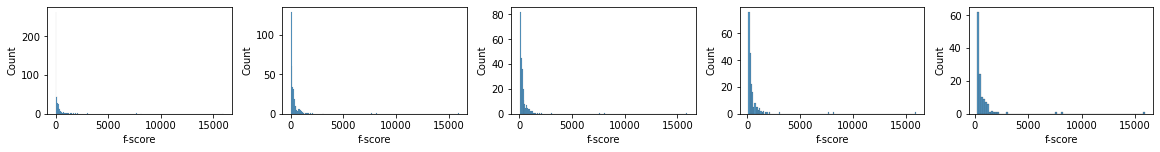

In [398]:
fig, axes = plt.subplots(1, 5, figsize=(16, 2), constrained_layout=True)
g1 = sns.histplot(x='f-score', data=anova, ax=axes[0])
g2 = sns.histplot(x='f-score', data=anova[anova['f-score']>10], ax=axes[1])
g3 = sns.histplot(x='f-score', data=anova[anova['f-score']>50], ax=axes[2])
g4 = sns.histplot(x='f-score', data=anova[anova['f-score']>100], ax=axes[3])
g4 = sns.histplot(x='f-score', data=anova[anova['f-score']>200], ax=axes[4])

In [393]:
for thresh in [0,10,50,100]:
    print('threshold =', thresh)
    print('max:', anova[anova['f-score']>thresh]['p-value'].max())

threshold = 0
max: 0.9883574678109508
threshold = 10
max: 0.0014061605622347807
threshold = 50
max: 1.181182345164663e-12
threshold = 100
max: 1.0681807068126723e-23


In [278]:
np.median(anova['f-score'])

44.14147483410649

In [279]:
np.mean(anova['f-score'])

232.4362639471128

In [280]:
anova_selected = anova[anova['f-score'] > 50]
anova_selected.sort_values('f-score',ascending=False)

f-score       p-value                                       columns_name
56   15939.286359  0.000000e+00                                NEW_EXT_SOURCE_MEAN
21    8109.493617  0.000000e+00                                       EXT_SOURCE_2
22    7659.890000  0.000000e+00                                       EXT_SOURCE_3
20    3036.648251  0.000000e+00                                       EXT_SOURCE_1
135   2085.799547  0.000000e+00                             BURO_DAYS_CREDIT__mean
..            ...           ...                                                ...
349     54.050020  1.959319e-13             PREV_CHANNEL_TYPE_Contact center__mean
378     53.284656  2.892433e-13  PREV_PRODUCT_COMBINATION_Cash X-Sell: middle__...
393     51.895406  5.867043e-13                     prevAPPROVED_CNT_PAYMENT__mean
297     51.243645  8.176551e-13                  PREV_CODE_REJECT_REASON_SCO__mean
5       50.521544  1.181182e-12                                        AMT_ANNUITY

[243 rows x 3 columns]

In [324]:
anova_unselected = anova[anova['f-score'] < 50]
anova_unselected.sort_values('f-score',ascending=False)

f-score       p-value                                       columns_name
52   49.643455  1.847687e-12                                   NEW_PAYMENT_RATE
241  49.444381  2.044985e-12  PREV_APP_SUCCESS_RATE__min_//_prevAPPROVED_APP...
126  49.247492  2.260848e-12                    WALLSMATERIAL_MODE_Stone, brick
486  48.971011  2.603011e-12                  CC_CNT_INSTALMENT_MATURE_CUM__min
53   48.275616  3.710599e-12  NEW_INC_PER_CHLD_//_NEW_INCOME_PER_PERSON_//_A...
..         ...           ...                                                ...
287   0.004477  9.466508e-01  PREV_NAME_CASH_LOAN_PURPOSE_XNA__mean_//_PREV_...
217   0.002322  9.615640e-01           BURO_closed_AMT_CREDIT_SUM_OVERDUE__mean
39    0.001679  9.673116e-01                         AMT_REQ_CREDIT_BUREAU_HOUR
254   0.001214  9.722108e-01           PREV_WEEKDAY_APPR_PROCESS_START_COS__min
332   0.000213  9.883575e-01   PREV_NAME_GOODS_CATEGORY_Office Appliances__mean

[266 rows x 3 columns]

In [388]:
print('if we drop the {} features with f-score <50, df would be with {} features'\
      .format(anova_unselected.shape[0],
              df.shape[1]-anova_unselected.shape[0]))

if we drop the 266 features with f-score <50, df would be with 245 features


### ==> Effects on df dimensions if dropping features with >50 % nan AND/OR correlated at >80% with another feature AND/OR f-score <50

In [302]:
#list of features correlated at > 80%
all_corr_cols2 = corr_cols2['feature_a'].tolist()
print(len(all_corr_cols2))
for e in corr_cols2['feature_b']:
    all_corr_cols2.append(e)
print(len(all_corr_cols2))
all_corr_cols2 = list(dict.fromkeys(all_corr_cols2))
print(len(all_corr_cols2))

319
638
242


* what if we drop features with >50% nan AND >80% correl AND <50 f-score?

    *==> no such feature --> df with same size*

In [303]:
# features with >50% nan AND >80% correl AND <50 f-score
feat_list = []
for feat in col_nan_sup_50b:
    for col in all_corr_cols2:
        if feat.startswith(col) == True:
            if feat in anova_unselected['columns_name']:
                feat_list.append(feat)
print('nb features = ', len(feat_list))

nb features =  0


* what if we drop features meeting 2 conditions among (1) having >50% nan, (2) being >80% correl, (3) having <50 f-score?

    *==> 74 features as such --> df would be with 437 features*

In [315]:
# features with >50% nan AND >80% correl OR <50 f-score
feat_list = []
for feat in col_nan_sup_50b:
    for col in all_corr_cols2:
        if feat.startswith(col) == True or feat in anova_unselected['columns_name']:
            feat_list.append(feat)
print('nb features = ', len(feat_list))

nb features =  41


In [316]:
feat_to_drop = [e for e in feat_list]
len(feat_to_drop)

41

In [317]:
# features with >80% correl AND <50 f-score
feat_list = []
for feat in anova_unselected['columns_name']:
    for col in all_corr_cols2:
        if feat.startswith(col) == True :
            feat_list.append(feat)
print('nb features = ', len(feat_list))

nb features =  51


In [318]:
print('nb features = ', len(feat_to_drop))
for e in feat_list:
    feat_to_drop.append(e)
print('nb features = ', len(feat_to_drop))
feat_to_drop = list(dict.fromkeys(feat_to_drop))
print('nb features = ', len(feat_to_drop))

nb features =  41
nb features =  92
nb features =  74


In [320]:
df.shape[1]-74

437

* what if we drop features with >50% nan OR >80% correl OR <50 f-score?

    *==> 385 features as such --> df would be with 126 features*

In [319]:
# features with >50% nan OR >80% correl OR <50 f-score
feat_list = [feat for feat in col_nan_sup_50b]
print('nb features = ', len(feat_list))
for col in all_corr_cols2:
    for feat in df.columns.tolist():
        if feat.startswith(col) == True:
            feat_list.append(feat)
print('nb features = ', len(feat_list))
for feat in anova_unselected['columns_name']:
    feat_list.append(feat)
print('nb features = ', len(feat_list))
feat_list = list(dict.fromkeys(feat_list))
print('nb features = ', len(feat_list))

nb features =  95
nb features =  244
nb features =  510
nb features =  385


In [313]:
df.shape[1]-385

126

* what if we drop features with >80% correl OR <50 f-score?

    *==> 364 features as such --> df would be with 147 features*

In [321]:
# features >80% correl OR <50 f-score
feat_list = [feat for feat in anova_unselected['columns_name']]
print('nb features = ', len(feat_list))
for col in all_corr_cols2:
    for feat in df.columns.tolist():
        if feat.startswith(col) == True:
            feat_list.append(feat)
print('nb features = ', len(feat_list))
feat_list = list(dict.fromkeys(feat_list))
print('nb features = ', len(feat_list))

nb features =  266
nb features =  415
nb features =  364


In [322]:
df.shape[1]-364

147

* what if we drop features with >50% nan OR <50 f-score?

    *==> 310 features as such --> df would be with 201 features*

In [337]:
# features >50% nan OR <50 f-score
feat_list = [feat for feat in anova_unselected['columns_name']]
print('nb features = ', len(feat_list))
for feat in col_nan_sup_50b:
    feat_list.append(feat)
print('nb features = ', len(feat_list))
feat_list = list(dict.fromkeys(feat_list))
print('nb features = ', len(feat_list))
print('df would have {} features'.format(df.shape[1]-len(feat_list)))

nb features =  266
nb features =  361
nb features =  310
df would have 201 features


In [385]:
# check f-score of features with >50% nan
anova_selected[anova_selected['columns_name'].isin(col_nan_sup_50b)].sort_values('f-score',ascending=False)

f-score        p-value                                       columns_name
20   3036.648251   0.000000e+00                                       EXT_SOURCE_1
483  1126.304068  1.776282e-246  CC_CNT_DRAWINGS_CURRENT__std_//_CC_CNT_DRAWING...
477   751.374777  3.191665e-165  CC_AMT_TOTAL_RECEIVABLE__mean_//_CC_AMT_RECIVA...
482   690.948322  4.100791e-152                      CC_CNT_DRAWINGS_CURRENT__mean
158   582.066752  1.755517e-128  BURO_MONTHS_BALANCE__size__mean_//_BURO_closed...
415   517.787292  1.595396e-114                          prevREFUSED_APP_LVR__mean
414   508.346950  1.792138e-112                           prevREFUSED_APP_LVR__max
468   495.199366  1.286294e-109  CC_AMT_DRAWINGS_CURRENT__std_//_CC_AMT_DRAWING...
476   419.971429   2.858770e-93  CC_AMT_TOTAL_RECEIVABLE__min_//_CC_AMT_RECIVAB...
27    389.182544   1.411064e-86  ELEVATORS_MEDI_//_ELEVATORS_AVG_//_ELEVATORS_MODE
467   375.790458   1.152242e-83                      CC_AMT_DRAWINGS_CURRENT__mean
479   350.390676   3.851477e-78  CC_AMT_TOTAL_RECEIVABLE__std_//_CC_AMT_RECIVAB...
407   334.074406   1.364599e-74  prevREFUSED_CNT_PAYMENT__mean_//_prevREFUSED_C...
183   316.729058   8.109860e-71             BURO_Simplified_STATUS_DPD__mean__mean
182   287.551036   1.817816e-64               BURO_Simplified_STATUS_C__mean__mean
480   285.943341   4.069484e-64                   CC_CNT_DRAWINGS_ATM_CURRENT__sum
413   226.861550   3.006968e-51                           prevREFUSED_APP_LVR__min
408   212.789445   3.511045e-48                  prevREFUSED_APP_SUCCESS_RATE__min
508   210.440465   1.141686e-47  CC_COUNT_//_CC_MONTHS_BALANCE__std_//_CC_NAME_...
411   200.115438   2.036644e-45                  prevREFUSED_APP_SUCCESS_RATE__std
419   186.853055   1.591200e-42    prevREFUSED_WEEKDAY_APPR_PROCESS_START_COS__min
181   182.556779   1.377475e-41               BURO_Simplified_STATUS_0__mean__mean
465   179.632146   5.987607e-41                   CC_AMT_DRAWINGS_ATM_CURRENT__sum
485   178.154351   1.258170e-40  CC_CNT_DRAWINGS_POS_CURRENT__sum_//_CC_CNT_DRA...
475   153.868505   2.523078e-35  CC_AMT_PAYMENT_TOTAL_CURRENT__std_//_CC_AMT_PA...
30    135.650277   2.415974e-31  FLOORSMIN_MEDI_//_FLOORSMIN_AVG_//_FLOORSMIN_MODE
410   129.711348   4.805448e-30                 prevREFUSED_APP_SUCCESS_RATE__mean
420   129.014243   6.826481e-30    prevREFUSED_WEEKDAY_APPR_PROCESS_START_COS__max
463   126.697105   2.192918e-29                    CC_AMT_CREDIT_LIMIT_ACTUAL__sum
188   116.553176   3.636680e-27                       BURO_active_DAYS_CREDIT__var
422   116.043099   4.702853e-27  prevREFUSED_HOUR_APPR_PROCESS_START_SIN__mean_...
405   108.062862   2.629164e-25  prevREFUSED_DAYS_DECISION__mean_//_prevREFUSED...
424   102.879178   3.593617e-24       prevREFUSED_HOUR_APPR_PROCESS_START_COS__max
33    100.720499   1.068181e-23  NONLIVINGAREA_MEDI_//_NONLIVINGAREA_AVG_//_NON...
23     91.582754   1.077698e-21  BASEMENTAREA_MEDI_//_BASEMENTAREA_AVG_//_BASEM...
193    85.434975   2.409058e-20           BURO_active_AMT_CREDIT_MAX_OVERDUE__mean
26     81.395972   1.857561e-19  COMMONAREA_MEDI_//_COMMONAREA_AVG_//_COMMONARE...
9      78.558969   7.804591e-19                                        OWN_CAR_AGE
28     76.166712   2.619641e-18  ENTRANCES_MEDI_//_ENTRANCES_AVG_//_ENTRANCES_MODE
487    73.756505   8.877479e-18  CC_CNT_INSTALMENT_MATURE_CUM__sum_//_CC_CNT_IN...
473    72.683984   1.528367e-17                 CC_AMT_PAYMENT_TOTAL_CURRENT__mean
481    67.083077   2.612856e-16                       CC_CNT_DRAWINGS_CURRENT__min
425    66.947381   2.798997e-16      prevREFUSED_HOUR_APPR_PROCESS_START_COS__mean
478    62.758537   2.344396e-15  CC_AMT_TOTAL_RECEIVABLE__sum_//_CC_AMT_RECIVAB...

In [383]:
# checking %nan of some of these features
df['EXT_SOURCE_1'].isna().sum()/df.shape[0]

0.5638115555093055

In [384]:
df['CC_CNT_DRAWINGS_CURRENT__std_//_CC_CNT_DRAWINGS_CURRENT__max'].isna().sum()/df.shape[0]

0.7173885472525828

* what if we drop features with <100 f-score? with <200 f-score?

In [400]:
thresh = 100
anova_unselected = anova[anova['f-score'] < thresh]
print('if we drop the {} features with f-score <{}, df would be with {} features'\
      .format(anova_unselected.shape[0],
              thresh,
              df.shape[1]-anova_unselected.shape[0]))

if we drop the 308 features with f-score <100, df would be with 203 features


In [401]:
thresh = 200
anova_unselected = anova[anova['f-score'] < thresh]
print('if we drop the {} features with f-score <{}, df would be with {} features'\
      .format(anova_unselected.shape[0],
              thresh,
              df.shape[1]-anova_unselected.shape[0]))

if we drop the 381 features with f-score <200, df would be with 130 features


In [405]:
anova_selected = anova[anova['f-score'] >= 200].sort_values('f-score',ascending=False)
anova_selected

f-score       p-value                                       columns_name
56   15939.286359  0.000000e+00                                NEW_EXT_SOURCE_MEAN
21    8109.493617  0.000000e+00                                       EXT_SOURCE_2
22    7659.890000  0.000000e+00                                       EXT_SOURCE_3
20    3036.648251  0.000000e+00                                       EXT_SOURCE_1
135   2085.799547  0.000000e+00                             BURO_DAYS_CREDIT__mean
..            ...           ...                                                ...
451    218.330525  2.175311e-49                           INSTAL_PAYMENT_DIFF__sum
81     216.368512  5.823810e-49            NAME_FAMILY_STATUS_Single / not married
408    212.789445  3.511045e-48                  prevREFUSED_APP_SUCCESS_RATE__min
508    210.440465  1.141686e-47  CC_COUNT_//_CC_MONTHS_BALANCE__std_//_CC_NAME_...
411    200.115438  2.036644e-45                  prevREFUSED_APP_SUCCESS_RATE__std

[128 rows x 3 columns]

### Chosen strategy = drop features with f-score<200

In [407]:
del X
gc.collect()

2311270

In [408]:
thresh = 200
anova_unselected = anova[anova['f-score'] < thresh]
print('df shape BEFORE dropping features with f-score<200:', df.shape)
for feat in anova_unselected['columns_name']:
    df.drop(feat, axis=1, inplace=True)
print('df shape AFTER dropping features with f-score<200:', df.shape)

df shape BEFORE dropping features with f-score<200: (307507, 511)
df shape AFTER dropping features with f-score<200: (307507, 130)


In [409]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307507 entries, 0 to 307506
Columns: 130 entries, SK_ID_CURR to CC_COUNT_//_CC_MONTHS_BALANCE__std_//_CC_NAME_CONTRACT_STATUS_Active__sum_//_CC_MONTHS_BALANCE__std_//INV_CC_MONTHS_BALANCE__sum_//_CC_MONTHS_BALANCE__min_//_CC_MONTHS_BALANCE__mean_//_CC_MONTHS_BALANCE__min_//INV_CC_MONTHS_BALANCE__mean_//_CC_MONTHS_BALANCE__min_//INV_CC_MONTHS_BALANCE__min
dtypes: float64(105), int64(25)
memory usage: 305.0 MB


In [410]:
# Export
df.to_csv('combined_light_df.csv')

In [413]:
check_nan(df)

nan in SK_ID_CURR : 0 (ratio of 0.0 )
nan in TARGET : 0 (ratio of 0.0 )
nan in CODE_GENDER : 0 (ratio of 0.0 )
nan in AMT_CREDIT_//_AMT_GOODS_PRICE : 0 (ratio of 0.0 )
nan in REGION_POPULATION_RELATIVE : 0 (ratio of 0.0 )
nan in DAYS_REGISTRATION : 0 (ratio of 0.0 )
nan in DAYS_ID_PUBLISH : 0 (ratio of 0.0 )
nan in FLAG_WORK_PHONE : 0 (ratio of 0.0 )
nan in REG_CITY_NOT_LIVE_CITY : 0 (ratio of 0.0 )
nan in REG_CITY_NOT_WORK_CITY : 0 (ratio of 0.0 )
nan in LIVE_CITY_NOT_WORK_CITY : 0 (ratio of 0.0 )
nan in EXT_SOURCE_1 : 173376 (ratio of 0.56 )
nan in EXT_SOURCE_2 : 660 (ratio of 0.0 )
nan in EXT_SOURCE_3 : 60965 (ratio of 0.2 )
nan in ELEVATORS_MEDI_//_ELEVATORS_AVG_//_ELEVATORS_MODE : 163890 (ratio of 0.53 )
nan in FLOORSMAX_MEDI_//_FLOORSMAX_AVG_//_FLOORSMAX_MODE : 153019 (ratio of 0.5 )
nan in TOTALAREA_MODE_//_LIVINGAREA_AVG_//_LIVINGAREA_MEDI_//_LIVINGAREA_AVG_//_LIVINGAREA_MODE : 148286 (ratio of 0.48 )
nan in DEF_30_CNT_SOCIAL_CIRCLE : 1021 (ratio of 0.0 )
nan in DEF_60_CNT_SOCI

In [424]:
corr= df.iloc[:,1:].corr()

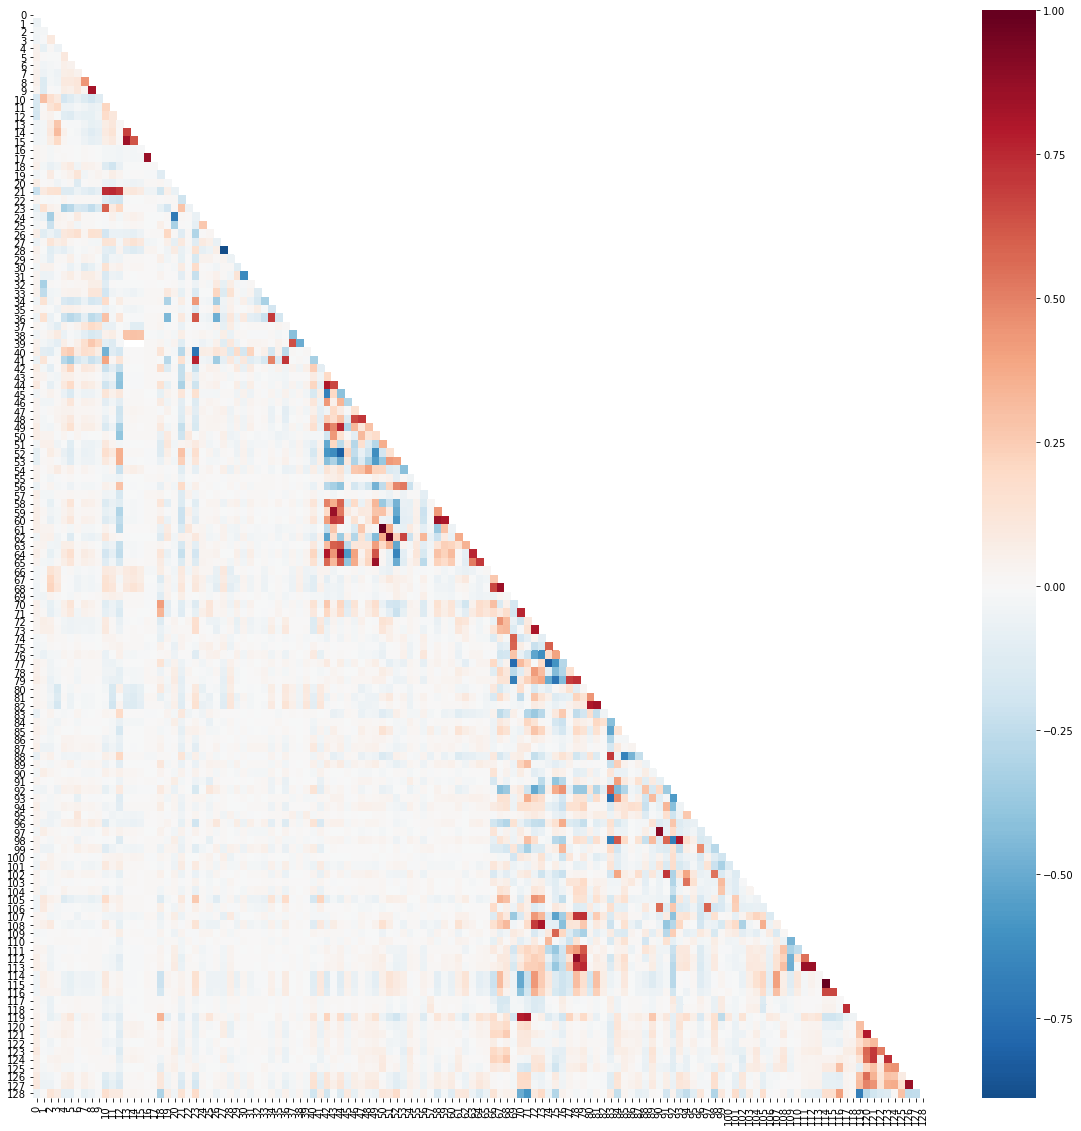

In [422]:
plt.figure(figsize=(20,20))
MASK = np.triu(corr)
sns.heatmap(corr,annot=False, fmt='.1f', cmap ="RdBu_r",
            center=0, mask=MASK,
            xticklabels=[i for i in range (corr.shape[0])],
            yticklabels=[i for i in range (corr.shape[0])])
plt.show()

In [425]:
corr.loc[:,:] = np.tril(corr.values, k=-1)
corr_ = corr[corr!=0]

# Filter according to threshold of 0.8 (taking out features already dealt with)
corr_ = corr_[((corr_ >= 0.9) | (corr_ <= -0.9))]

# Unstack, sort ascending, and reset the index, so features are in columns
# instead of indexes (allowing e.g. a pretty print in Jupyter).
# Also rename these it for good measure.
corr_cols = corr_.unstack().sort_values(ascending=False)\
    .drop_duplicates().dropna().reset_index()\
    .rename(columns={"level_0": "feature_a", "level_1": "feature_b", 0: "correlation"})
corr_cols

feature_a  feature_b  correlation
0  POS_MONTHS_BALANCE__size  POS_COUNT          1.0

In [426]:
# Why is there one left??????
# correcting this:
corr_feat_todrop_list = []
corr_feat_kept_list = []
nb_feat_before = df.shape[1]

for i in range(corr_cols.shape[0]):
    feat_a = [e for e in df.columns.tolist() if e.startswith(corr_cols.loc[i, 'feature_a']) == True][0]
    feat_b = [e for e in df.columns.tolist() if e.startswith(corr_cols.loc[i, 'feature_b']) == True][0]
    # For each pair of features highly correlated, we will keep the feature with less NaN, and drop the other
    if df[feat_a].isna().sum() < df[feat_b].isna().sum():
        feat_tokeep = feat_a
        feat_todrop = feat_b
    else:
        feat_tokeep = feat_b
        feat_todrop = feat_a
    corr_feat_todrop_list.append(feat_todrop)
    corr_feat_kept_list.append(feat_tokeep)
    # Before doing it, we will replace NaN of the feature to keep 
    # by normalized (relative to feat_tokeep) values from the feature to drop
    # For this we need min and max values of both features:
    min_k = np.min(df[feat_tokeep])
    max_k = np.max(df[feat_tokeep])
    min_d = np.min(df[feat_todrop])
    max_d = np.max(df[feat_todrop])
    # to track nb of nan replaced:
    nb_nan_before = df[feat_tokeep].isna().sum()
    # And we will rename the feature kept by adding to its initial name the dropped feature's name
    # in 2 different ways depending if these features are positively or negatively correlated
    if corr_cols.loc[i, 'correlation'] > 0:
        df[feat_tokeep].fillna((max_k-min_k)*(((df[feat_todrop]-min_d)/(max_d-min_d))+(min_k/(max_k-min_k))),
                            inplace=True)
        df.rename(columns={feat_tokeep: feat_tokeep+'_//_'+feat_todrop}, inplace=True)
        nb_nan_after = df[feat_tokeep+'_//_'+feat_todrop].isna().sum()
    if corr_cols.loc[i, 'correlation'] < 0:
        df[feat_tokeep].fillna((min_k-max_k)*(((df[feat_todrop]-min_d)/(max_d-min_d))+(max_k/(min_k-max_k))),
                            inplace=True)
        df.rename(columns={feat_tokeep: feat_tokeep+'_//INV_'+feat_todrop}, inplace=True)
        nb_nan_after = df[feat_tokeep+'_//INV_'+feat_todrop].isna().sum()
    print('{}-- feature kept: {}, feature to drop: {}, nb nan replaced:{}'.format(i,feat_tokeep, feat_todrop,
                                                                             (nb_nan_before-nb_nan_after)))

# Dropping features to drop
corr_feat_todrop_list = list(dict.fromkeys(corr_feat_todrop_list)) # to remove duplicates from the list of features to drop
corr_feat_todrop_list_ = [col for col in df.columns for e in corr_feat_todrop_list if col.startswith(e) == True]
corr_feat_todrop_list_ = list(dict.fromkeys(corr_feat_todrop_list_))
print('-' * 100)
print('####### dropping {} features now...'.format(len(corr_feat_todrop_list_)))
    # dropping them   
for feat in corr_feat_todrop_list_:
    print(feat)
    df.drop(feat, axis=1, inplace=True)
print('-' * 100)
print('df shape after dropping one feature from each pair of highly correlated (0.9) features:', df.shape)
print('nb of dropped features = ', nb_feat_before - df.shape[1]) # as a reminder at the bottom

0-- feature kept: POS_COUNT, feature to drop: POS_MONTHS_BALANCE__size, nb nan replaced:0
----------------------------------------------------------------------------------------------------
####### dropping 1 features now...
POS_MONTHS_BALANCE__size
----------------------------------------------------------------------------------------------------
df shape after dropping one feature from each pair of highly correlated (0.9) features: (307507, 129)
nb of dropped features =  1


In [430]:
# Export
df.to_csv('combined_light2_df.csv')

# EDA: additionnal plots regarding feature distribution or relation to other features (largely from kaggle kernel used here)
## Distribution of target feature

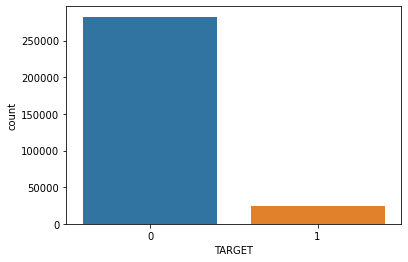

In [353]:
sns.countplot(x='TARGET', data=df)

In [377]:
target_val = df['TARGET'].value_counts()

Text(0.5, 1.0, 'TARGET')

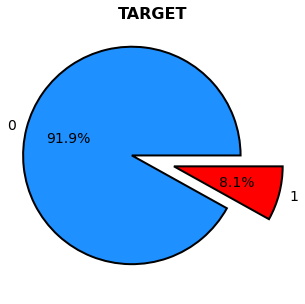

In [380]:
colors = ('dodgerblue', 'red')
target_val.plot.pie(autopct='%1.1f%%', label='', figsize=(5, 5), fontsize=14, 
                    #colormap='tab20', 
                    colors = colors,
                    wedgeprops={"edgecolor":"k",'linewidth': 2, 'antialiased': True},
                    explode=[0.2, 0.2])
plt.title('TARGET', fontsize=16, fontweight='bold')

## Bivariate plots: significant feature-feature relation 
## Effect of Age on Repayment

In [42]:
df=pd.read_csv('combined_light2_df.csv')

In [45]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [47]:
df.shape

(307507, 129)

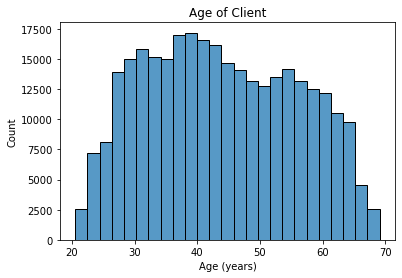

In [53]:
g1 = sns.histplot(x='NEW_AGE_//INV_DAYS_BIRTH', data=df, bins=25)
plt.title('Age of Client')
plt.xlabel('Age (years)')
plt.ylabel('Count')

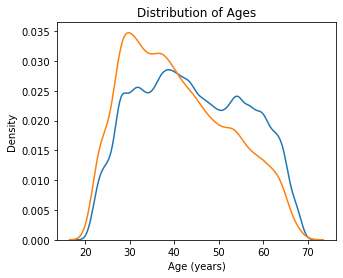

In [57]:
plt.figure(figsize = (5, 4))

# KDE plot of loans that were repaid on time
sns.kdeplot(df.loc[df['TARGET'] == 0, 'NEW_AGE_//INV_DAYS_BIRTH'], label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(df.loc[df['TARGET'] == 1, 'NEW_AGE_//INV_DAYS_BIRTH'], label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

<ipython-input-60-e773f2ece3ef>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data['YEARS_BINNED'] = pd.cut(age_data['NEW_AGE_//INV_DAYS_BIRTH'], bins = np.linspace(20, 70, num = 11))


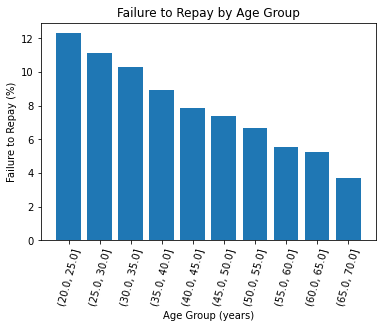

In [60]:
# Age information into a separate dataframe
age_data = df[['TARGET', 'NEW_AGE_//INV_DAYS_BIRTH']]
#age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['NEW_AGE_//INV_DAYS_BIRTH'], bins = np.linspace(20, 70, num = 11))

# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups


plt.figure(figsize = (6, 4))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

==> younger applicants are more likely not to repay their loan.

## Exterior source scores

Text(0.5, 1.0, 'Correlation Heatmap')

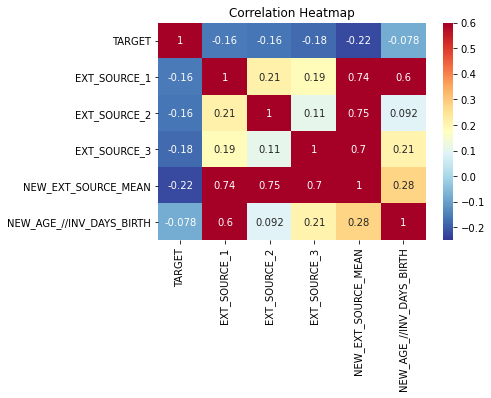

In [61]:
ext_data = df[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'NEW_EXT_SOURCE_MEAN', 'NEW_AGE_//INV_DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()

plt.figure(figsize = (6, 4))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')

* All EXT_SOURCE features are negatively correlated to the target ==> as the value of the EXT_SOURCE increases, the client is more likely to repay the loan.

* DAYS_BIRTH is positively correlated to EXT_SOURCE_1 ==> might be one element taken into consideration when calculating this score

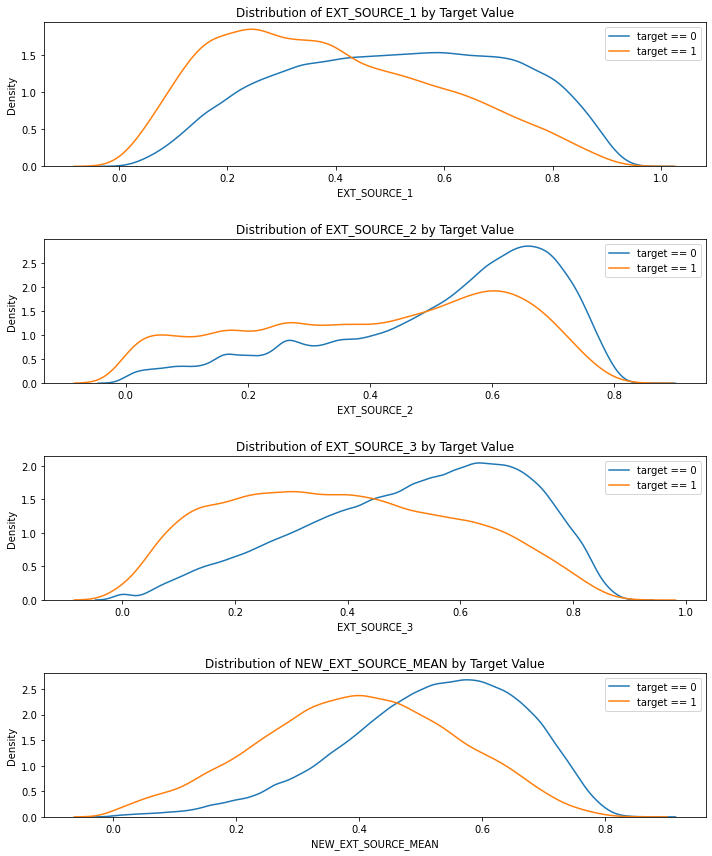

In [64]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'NEW_EXT_SOURCE_MEAN']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df.loc[df['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df.loc[df['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density'); 
    plt.legend()
    
plt.tight_layout(h_pad = 2.5)

## Exploring some features newly created

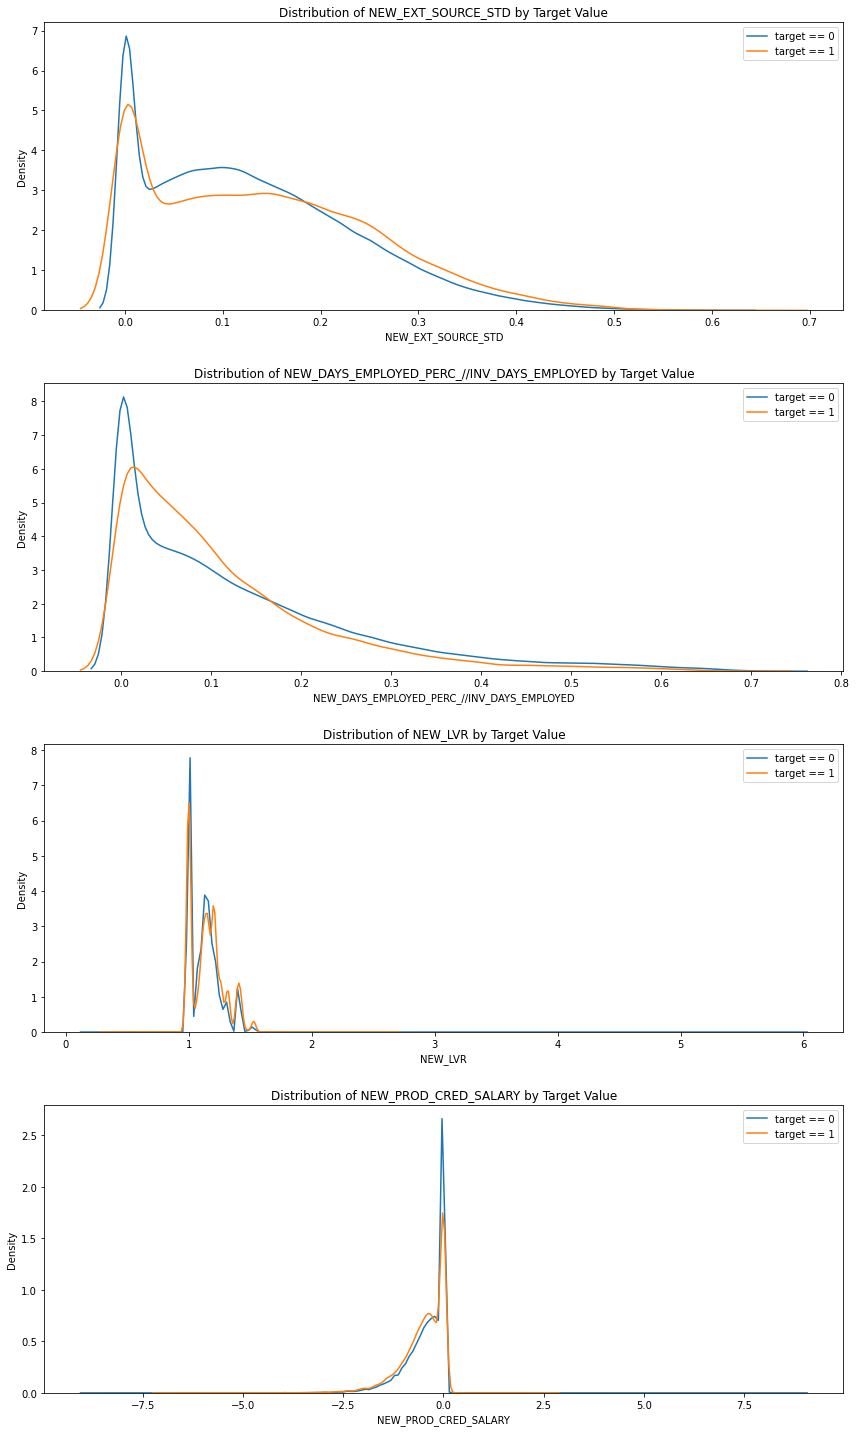

In [65]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['NEW_EXT_SOURCE_STD', 
                             'NEW_DAYS_EMPLOYED_PERC_//INV_DAYS_EMPLOYED',
                             'NEW_LVR',
                             'NEW_PROD_CRED_SALARY']):
    
    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(df.loc[df['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df.loc[df['TARGET'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');
    plt.legend()
    
plt.tight_layout(h_pad = 2.5)

==> no substancial differences within those variables between the two target classes... 